说明：  
&ensp;&ensp;本文件使用 Data clean 2 得到的数据集。里面的bank_detail_stats, browse_history_stats,bill_detail_stats 都有不同程度的缺失。当然，目标变量 target的未知数据集部分是缺失的。

<font face="微软雅黑" size=5> Contents： </font>  
1. 数据准备  
2. 过拟合XGB模型  
3. 调参  
&ensp;&ensp;&ensp;&ensp;3.1 自定义网络搜索函数  
4. 交叉验证  
5. 训练最终XGB模型并预测未知样本集  
6. 提交结果


In [45]:
import Custom_Functions as CF    # 此文档记录了部分自定义函数。
import numpy as np
import pandas as pd
import time
from scipy import special
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,rand
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import time
from sklearn.externals import joblib
import pickle
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# 数据准备  
使用 Data Clean 2 得到的数据集，是有缺失、未填充的。将此数据集进行二八分。

In [46]:
# 读取数据集 data1，记为 data

data = pd.read_csv(r'F:\RiskPre2\Data clean 2\data1.csv').set_index("userID")

In [47]:
# 从数据集 data中提取出训练集和未知样本集
# 训练集 data_tr，(55381, 719)。未知样本集 data_te，(13899, 719)

userIDtrain = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtrain.csv').values.flatten()
userIDtest = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv').values.flatten()
data_tr = data.loc[userIDtrain,:]
print("shape of data_tr is:",data_tr.shape )
data_te = data.loc[userIDtest,:]
print("shape of data_te is:",data_te.shape )

shape of data_tr is: (55381, 719)
shape of data_te is: (13899, 719)


In [48]:
data_tr.head(2)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.897688,0.8637,0.847896,0.944211,0.0,0.0,3.0,61.52325,5914855887,0.0


In [49]:
# 对训练集 data_tr 进行目标变量分离，分成 字段部分 X_tr和 目标变量部分 y_tr。
# 对未知样本集 data_te 进行目标变量分离，分成 字段部分 X_te和 目标变量部分 y_te。


X_tr = data_tr.drop(["target"],axis=1)
y_tr = data_tr.loc[:,"target"]
X_te = data_te.drop(["target"],axis=1)
y_te = data_te.loc[:,"target"]
print("shape of X_tr is:",X_tr.shape)
print("shape of y_tr is:",y_tr.shape)
print("shape of X_te is:",X_te.shape)
print("shape of y_te is:",y_te.shape)

shape of X_tr is: (55381, 718)
shape of y_tr is: (55381,)
shape of X_te is: (13899, 718)
shape of y_te is: (13899,)


In [50]:
X_tr.head(2)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887
2,0,1,0,0,0,1,0,0,0,0,...,0.487417,0.897688,0.8637,0.847896,0.944211,0.0,0.0,3.0,61.52325,5914855887


In [51]:
y_tr.head(2)

userID
1    0.0
2    0.0
Name: target, dtype: float64

In [52]:
# 使用 train_test_split 将 X_tr, y_tr 二八划分成训练集 X_tr_train,y_tr_train 和 验证集 X_tr_test, y_tr_test。
# 可见，训练集 44304 个用户，验证集 11077 个用户。
# train_test_split 默认 shuffle数据，所以不必担心。还可以设置 stratify 分层抽样。


X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y_tr, test_size = 0.2, shuffle=True, stratify=y_tr, random_state = 0)
print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)
scale_pos_weight_value=len(y_tr_train[y_tr_train==0])/len(y_tr_train[y_tr_train==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_train is:",scale_pos_weight_value)
scale_pos_weight_value1=len(y_tr_test[y_tr_test==0])/len(y_tr_test[y_tr_test==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_test is:",scale_pos_weight_value1)
# 可见，二八分得的训练集和验证集里的 正负样本比例基本相同，即实现了 stratify.

shape of X_tr_train is: (44304, 718)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 718)
shape of y_tr_test is: (11077,)
negative number/positive number in y_tr_train is: 6.7441006816990035
negative number/positive number in y_tr_test is: 6.746153846153846


In [53]:
X_tr_train.head(3)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
950,0,1,0,0,0,1,0,0,0,0,...,0.0,0.897324,0.895973,0.894623,0.967102,0.483551,0.0,2.0,42.631748,5915633487
52463,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,60.501599,5931617487
26796,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,39.814708,5928247887


# 过拟合XGB模型  
 
&ensp;&ensp;调参主要是调过拟合。我觉得应该先尝试最过拟合的可能性，比如树最深等等，看看对训练集和对验证集的auc相差多少。如果训练集的auc很高，验证集的auc很低，说明过拟合。这时可以逐步把与抑制过拟合相关的参数进行调整，使得出现：训练集auc降低，验证集auc提高的效果。   
&ensp;&ensp;这里，对整个训练集X_tr_train，y_tr_train的五折进行学习，学得5个模型，每个模型对自己的训练集和验证集进行预测并算auc，猜测应该训练集的auc很高（过拟合），而测试集的auc很低。

In [54]:
# 对训练集X_tr_train，y_tr_train进行一次性五折划分（此划分和 ModelLR 里的不同）。
# Xt 存储了 5个二维array，分别是5份训练集。  
# Xv 存储了 5个二维array，分别是对应的5份验证集。
# Yt 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yv 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=8)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xt = []
Yt = []
Xv = []
Yv = []
for train_index, validation_index in skf.split(X_tr_train.values,y_tr_train.values):  
    Xt.append(X_tr_train.values[train_index])
    Yt.append(y_tr_train.values[train_index])
    Xv.append(X_tr_train.values[validation_index])
    Yv.append(y_tr_train.values[validation_index])

In [55]:
# 设置 XGB 参数 使过拟合

XGB_param1 =dict(
    max_depth=10,                       # 树的最大深度
    learning_rate=1,                  # 提升树的学习率                     
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,                    # 此为默认设置，不打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    gamma=0,                            # （默认）设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    max_delta_step = 0,                 # （默认）此为默认设置，每棵树权重改变的最大步长。
    subsample=1,                        # （默认）训练每棵树时实例数据随机采样的比例
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    colsample_bylevel = 1,              # （默认）此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda =0,                      # （默认）此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,                   # （默认）此为默认设置，
    seed = 0,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。      
    )


In [56]:
# 对训练集的五折划分，每一折都训练一个XGB模型，每个模型分别对自己的训练集和验证集进行预测并计算 auc。
# Models1 保存了 5 个模型。 Scores1 保存了 5 个模型分别对各自的验证集进行预测算得的 auc。
# 并求 5 个验证集 auc 值 的均值。


timestart = time.time()
Scores1=[]
Models1=[XGBClassifier(**XGB_param1) for i in range(len(Xt))]  # 创建 5 个模型
for i in range(len(Xt)):
    Models1[i].fit(Xt[i],Yt[i], eval_set = [(Xt[i],Yt[i]),( Xv[i],Yv[i])],
                   eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
    Scores1.append(Models1[i].best_score)
    print("-------------------------------")
print("Time: {:.2f} seconds".format(time.time() - timestart))
print("Scores1 : ", Scores1)
print("The mean auc is :", np.mean(Scores1))

# 代码技巧：我之前是这样做的：Models1=[]，然后在for循环里 modelXGB1.fit数据集，再 Models1.append(modelXGB1)
# 但发现这样做，得到的 Models1 里的五个模型全相同，都是最终的模型。所以我认为，应该在每一轮创建新的模型，
# 而不是同一个模型 modelXGB1 反复 fit 不同的数据。所以上述代码是在每一轮创建新模型。

[0]	validation_0-logloss:0.50493	validation_0-auc:0.851628	validation_1-logloss:0.574244	validation_1-auc:0.715138
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.425091	validation_0-auc:0.899016	validation_1-logloss:0.55782	validation_1-auc:0.726198
[2]	validation_0-logloss:0.374897	validation_0-auc:0.923341	validation_1-logloss:0.554582	validation_1-auc:0.725626
[3]	validation_0-logloss:0.327195	validation_0-auc:0.944648	validation_1-logloss:0.581901	validation_1-auc:0.716698
[4]	validation_0-logloss:0.287193	validation_0-auc:0.957146	validation_1-logloss:0.5801	validation_1-auc:0.718263
[5]	validation_0-logloss:0.262779	validation_0-auc:0.965178	validation_1-logloss:0.579477	validation_1-auc:0.716275
[6]	validation_0-logloss:0.232537	validation_0-auc:0.974403	validation_1-logloss:0.590404	validation_1-auc:0.712104
[7]	validation_0-logloss:0.212339	v

[4]	validation_0-logloss:0.270028	validation_0-auc:0.96238	validation_1-logloss:0.57179	validation_1-auc:0.700123
[5]	validation_0-logloss:0.25211	validation_0-auc:0.968329	validation_1-logloss:0.57201	validation_1-auc:0.706298
[6]	validation_0-logloss:0.227284	validation_0-auc:0.975049	validation_1-logloss:0.580311	validation_1-auc:0.699114
[7]	validation_0-logloss:0.212531	validation_0-auc:0.979021	validation_1-logloss:0.587072	validation_1-auc:0.700105
[8]	validation_0-logloss:0.188596	validation_0-auc:0.984319	validation_1-logloss:0.590175	validation_1-auc:0.698454
[9]	validation_0-logloss:0.174556	validation_0-auc:0.987157	validation_1-logloss:0.594112	validation_1-auc:0.699817
[10]	validation_0-logloss:0.159156	validation_0-auc:0.989829	validation_1-logloss:0.597818	validation_1-auc:0.698126
[11]	validation_0-logloss:0.130266	validation_0-auc:0.994182	validation_1-logloss:0.612564	validation_1-auc:0.691533
Stopping. Best iteration:
[1]	validation_0-logloss:0.417	validation_0-auc:

结论：  
&ensp;&ensp;训练 5 个模型的过程如上，每个模型之间用 长虚线分隔。validation_0是此轮模型对自己的训练集进行预测算得的 logloss 和 auc值。validation_1是此轮模型对自己的验证集进行预测算得的 logloss 和 auc值。每个模型的训练都有好几轮的树，因设置了 early stopping，所以每个模型的最佳轮数会给出。  
&ensp;&ensp;从 5 个模型的训练过程可以看到，5个模型对各自的训练集的预测auc基本可以达到 0.9以上，而对自己的验证集的预测auc维持在 0.7。5个模型的平均auc值为 0.725.  
&ensp;&ensp;如果我们以后能通过超参数调节，让模型对训练集的预测auc降低，让模型对验证集的预测auc升高，就达到了抑制过拟合，提高预测未知的能力的效果。

In [57]:
Models1

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=1,
        max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=0, scale_pos_weight=6.7441006816990035, seed=0,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=1,
        max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=0, scale_pos_weight=6.7441006816990035, seed=0,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, le

In [58]:
# 将五折训练出的 五个模型 的具体情况 做成表。
# round 是第几个模型，一共 5 个模型，按计算顺序排列。best_iteration 给出了训练此模型时的最佳轮数（因为设置了 early stopping）。
# train_auc 是此模型对其训练集进行预测计算出的 auc 值，validation_auc 是此模型对其验证集进行预测计算出的 auc 值。

roundXGB=[]  
train_auc=[]  
validation_auc=[]  
best_iteration=[]

for i in range(len(Scores1)):
    
    # round 表是 五折中的第几个模型。一共 5 个模型。
    roundXGB.append(i+1)
    
    # 找出第 i个模型的最佳轮模型在自己训练集上预测时计算得到的auc值。
    train_auc.append(Models1[i].evals_result()["validation_0"]["auc"][ Models1[i].best_iteration])
    
    # 找出第i个模型的最佳轮模型在自己验证集上预测时计算得到的auc值。
    validation_auc.append(Models1[i].evals_result()["validation_1"]["auc"][ Models1[i].best_iteration])
    
    # i个模型的最佳轮是第几轮
    best_iteration.append(Models1[i].best_iteration)

d = {"model_round":roundXGB, "train_auc": train_auc , "validation_auc": validation_auc , "best_iteration": best_iteration }
auc_result = pd.DataFrame(d,index=[1,2,3,4,5])


In [59]:
auc_result

,best_iteration,model_round,train_auc,validation_auc
1,1,1,0.899016,0.726198
2,4,2,0.951195,0.729715
3,5,3,0.954552,0.737586
4,0,4,0.852321,0.716697
5,1,5,0.905869,0.716801


# 调参  
  
1. 因为之前试过GridSearchCV一次调节 6 个超参数，每个超参数都有若干取值，但计算太慢（几天时间也没有算出）。所以这里只做简单调参。
2. 我觉得只调3个参数：learning_rate. max_depth. subsample. 其它都使用默认值。（因为我觉得很多参数在防止过拟合方面也是相互影响的）
3. 调参测量为：先把 learning_rate 维持在较高值，subsample=0.8，然后调整 max_depth。然后，固定learning_rate和max_depth，调整 subsample。然后，固定subsample和max_depth，调整learning_rate。

In [60]:
# 固定参数

XGB_param2 = dict(                 
                      
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,                    # 此为默认设置，不打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    gamma=0,                            # （默认）设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    max_delta_step = 0,                 # （默认）此为默认设置，每棵树权重改变的最大步长。
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    colsample_bylevel = 1,              # （默认）此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda = 1,                     # （默认）此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,                   # （默认）此为默认设置，
    seed = 1,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。      
    )

In [61]:
# 因为用 GridSearchCV 对 XGBOOST 的超参数进行交叉验证实在太慢，所以我自定义了一个网格搜索函数 myGridSearchCV1 .
# 可以实现对一个超参数的若干可能取值的 5折 交叉验证。
# 参数：XGB_param是XGB模型的固定参数，param_grid_name 是XGB模型待交叉验证的超参数的名字（字符串），
# param_grid_values 是此超参数的可能取值（list）
# 此函数只能检测一个超参数。
# 返回值：返回一个 dataframe，记录了此超参数的每一个尝试的值 所对应的5个模型的对各自验证集计算的auc的均值。
# 所以，这张表中，mean_auc 最大的那个C值即最优 C。

def myGridSearchCV1(XGB_param,param_grid_name,param_grid_values,Xt,Yt,Xv,Yv):  
    
    records = []
    Info = []     

    for c in param_grid_values:       # 对此超参数的每个值进行尝试
        XGB_param_fix = XGB_param
        XGB_param_fix[param_grid_name] = c # 往固定参数里增添超参数的一个值
                
        Scores=[]
        Models=[XGBClassifier(**XGB_param_fix) for i in range(len(Xt))]  # 创建 5 个模型
        for i in range(len(Xt)):      # 此超参数在一个值下，创建 5 个模型，5个模型分别 fit
            Models[i].fit(Xt[i],Yt[i], eval_set = [(Xt[i],Yt[i]),( Xv[i],Yv[i])],
                       eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
            
            # 为 5 个模型中的每个收集信息
            k = Models[i].best_iteration  
            r = Models[i].evals_result()
            Infoi = []
            Infoi.append(c)                              # 此超参数值 c 
            Infoi.append(i+1)                            # 此超参数下的第 几 个模型
            Infoi.append(k)                              # 此模型的最佳轮数
            Infoi.append(r["validation_0"]["auc"][k])    # 此模型的最佳轮的训练集 auc
            Infoi.append(r["validation_1"]["auc"][k])    # 此模型的最佳轮的验证集 auc，也就是 Models[i].best_score
            Info.append(Infoi)
            
            Scores.append(Models[i].best_score)         # 此模型的最佳轮的验证集 auc
            print("--------------------------------")
        
        print("When %s is %f, five scores are :" % (param_grid_name,c))
        print(Scores)
        print("--------------------------------")
        print("--------------------------------")
        print("--------------------------------")
        
        records.append([c,np.mean(Scores)])
    
    Info = pd.DataFrame(Info,columns=[param_grid_name,"model_round","best_iteration","train_auc","validation_auc"])
    records = pd.DataFrame(records,columns=[param_grid_name,"mean_auc"]).sort_values(by="mean_auc",ascending=False)
    
    return Info, records

1. 固定 learning_rate=0.5，subsample=0.8，调整 max_depth。

In [62]:
# 固定参数更新

XGB_param3 = XGB_param2.copy()
XGB_param3.update({"learning_rate":0.5,"subsample":0.8})

# 注意，一定要对 XGB_param2 进行复制，再赋给 XGB_param3，这样 更改XGB_param3 不会影响到 XGB_param2。
# 若使用 XGB_param3 = XGB_param2，则对XGB_param3 的更改也同样会反应到 XGB_param2 里。

In [63]:
# 要调节的超参数 -- max_depth  [1,5,10,15]

timestart=time.time()
Info3_1,result3_1 = myGridSearchCV1(XGB_param3,"max_depth",[1,5,10,15],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.619054	validation_0-auc:0.724077	validation_1-logloss:0.622064	validation_1-auc:0.71808
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.600617	validation_0-auc:0.736443	validation_1-logloss:0.605757	validation_1-auc:0.729798
[2]	validation_0-logloss:0.591475	validation_0-auc:0.740247	validation_1-logloss:0.597164	validation_1-auc:0.732935
[3]	validation_0-logloss:0.580855	validation_0-auc:0.751737	validation_1-logloss:0.587776	validation_1-auc:0.741852
[4]	validation_0-logloss:0.578952	validation_0-auc:0.75627	validation_1-logloss:0.586807	validation_1-auc:0.744491
[5]	validation_0-logloss:0.575292	validation_0-auc:0.763863	validation_1-logloss:0.583005	validation_1-auc:0.753123
[6]	validation_0-logloss:0.574747	validation_0-auc:0.765462	validation_1-logloss:0.582948	validation_1-auc:0.755481
[7]	validation_0-logloss:0.574863

[70]	validation_0-logloss:0.534876	validation_0-auc:0.813639	validation_1-logloss:0.548226	validation_1-auc:0.791705
[71]	validation_0-logloss:0.53571	validation_0-auc:0.813984	validation_1-logloss:0.548929	validation_1-auc:0.791889
[72]	validation_0-logloss:0.536941	validation_0-auc:0.814483	validation_1-logloss:0.550224	validation_1-auc:0.791871
[73]	validation_0-logloss:0.538029	validation_0-auc:0.814528	validation_1-logloss:0.551128	validation_1-auc:0.792072
[74]	validation_0-logloss:0.538444	validation_0-auc:0.814864	validation_1-logloss:0.551662	validation_1-auc:0.792149
[75]	validation_0-logloss:0.536725	validation_0-auc:0.815116	validation_1-logloss:0.549864	validation_1-auc:0.79239
[76]	validation_0-logloss:0.536632	validation_0-auc:0.815405	validation_1-logloss:0.550014	validation_1-auc:0.792383
[77]	validation_0-logloss:0.536477	validation_0-auc:0.815645	validation_1-logloss:0.550036	validation_1-auc:0.792219
[78]	validation_0-logloss:0.536905	validation_0-auc:0.81591	valida

[24]	validation_0-logloss:0.553621	validation_0-auc:0.79709	validation_1-logloss:0.558125	validation_1-auc:0.788154
[25]	validation_0-logloss:0.55411	validation_0-auc:0.797505	validation_1-logloss:0.5582	validation_1-auc:0.788769
[26]	validation_0-logloss:0.554961	validation_0-auc:0.797834	validation_1-logloss:0.558968	validation_1-auc:0.789144
[27]	validation_0-logloss:0.554973	validation_0-auc:0.798509	validation_1-logloss:0.559284	validation_1-auc:0.789071
[28]	validation_0-logloss:0.553111	validation_0-auc:0.799236	validation_1-logloss:0.557402	validation_1-auc:0.789625
[29]	validation_0-logloss:0.550985	validation_0-auc:0.799625	validation_1-logloss:0.555435	validation_1-auc:0.789983
[30]	validation_0-logloss:0.552189	validation_0-auc:0.799985	validation_1-logloss:0.556754	validation_1-auc:0.789403
[31]	validation_0-logloss:0.551051	validation_0-auc:0.800377	validation_1-logloss:0.555418	validation_1-auc:0.789803
[32]	validation_0-logloss:0.551618	validation_0-auc:0.800826	validat

[0]	validation_0-logloss:0.621172	validation_0-auc:0.721723	validation_1-logloss:0.622446	validation_1-auc:0.729267
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.601191	validation_0-auc:0.733596	validation_1-logloss:0.601213	validation_1-auc:0.746708
[2]	validation_0-logloss:0.593449	validation_0-auc:0.73502	validation_1-logloss:0.593665	validation_1-auc:0.747341
[3]	validation_0-logloss:0.585072	validation_0-auc:0.746853	validation_1-logloss:0.585982	validation_1-auc:0.756574
[4]	validation_0-logloss:0.580176	validation_0-auc:0.755979	validation_1-logloss:0.581547	validation_1-auc:0.76474
[5]	validation_0-logloss:0.57778	validation_0-auc:0.759227	validation_1-logloss:0.579144	validation_1-auc:0.769108
[6]	validation_0-logloss:0.575083	validation_0-auc:0.765239	validation_1-logloss:0.576717	validation_1-auc:0.773685
[7]	validation_0-logloss:0.574436	

[69]	validation_0-logloss:0.540363	validation_0-auc:0.809865	validation_1-logloss:0.549775	validation_1-auc:0.808166
[70]	validation_0-logloss:0.541478	validation_0-auc:0.810008	validation_1-logloss:0.550903	validation_1-auc:0.808283
[71]	validation_0-logloss:0.540044	validation_0-auc:0.810406	validation_1-logloss:0.549853	validation_1-auc:0.808459
[72]	validation_0-logloss:0.540252	validation_0-auc:0.810629	validation_1-logloss:0.550194	validation_1-auc:0.808825
[73]	validation_0-logloss:0.539721	validation_0-auc:0.810976	validation_1-logloss:0.549699	validation_1-auc:0.809164
[74]	validation_0-logloss:0.540414	validation_0-auc:0.810788	validation_1-logloss:0.550602	validation_1-auc:0.808885
[75]	validation_0-logloss:0.540367	validation_0-auc:0.811157	validation_1-logloss:0.550603	validation_1-auc:0.808811
[76]	validation_0-logloss:0.539167	validation_0-auc:0.811443	validation_1-logloss:0.549425	validation_1-auc:0.808601
[77]	validation_0-logloss:0.539461	validation_0-auc:0.811667	val

[47]	validation_0-logloss:0.544413	validation_0-auc:0.803995	validation_1-logloss:0.535866	validation_1-auc:0.803114
[48]	validation_0-logloss:0.544307	validation_0-auc:0.804272	validation_1-logloss:0.53554	validation_1-auc:0.80337
[49]	validation_0-logloss:0.547122	validation_0-auc:0.804532	validation_1-logloss:0.538286	validation_1-auc:0.803538
[50]	validation_0-logloss:0.546187	validation_0-auc:0.804998	validation_1-logloss:0.537242	validation_1-auc:0.804362
[51]	validation_0-logloss:0.545071	validation_0-auc:0.805271	validation_1-logloss:0.53626	validation_1-auc:0.803975
[52]	validation_0-logloss:0.543818	validation_0-auc:0.805693	validation_1-logloss:0.535166	validation_1-auc:0.804051
[53]	validation_0-logloss:0.543393	validation_0-auc:0.805966	validation_1-logloss:0.534721	validation_1-auc:0.804389
[54]	validation_0-logloss:0.541526	validation_0-auc:0.80625	validation_1-logloss:0.533322	validation_1-auc:0.803924
[55]	validation_0-logloss:0.540545	validation_0-auc:0.806377	validat

[11]	validation_0-logloss:0.473516	validation_0-auc:0.864329	validation_1-logloss:0.524558	validation_1-auc:0.779745
[12]	validation_0-logloss:0.467864	validation_0-auc:0.867576	validation_1-logloss:0.521146	validation_1-auc:0.779127
[13]	validation_0-logloss:0.463998	validation_0-auc:0.871527	validation_1-logloss:0.520805	validation_1-auc:0.778001
[14]	validation_0-logloss:0.46203	validation_0-auc:0.873013	validation_1-logloss:0.519807	validation_1-auc:0.778002
[15]	validation_0-logloss:0.455869	validation_0-auc:0.877139	validation_1-logloss:0.517235	validation_1-auc:0.777213
[16]	validation_0-logloss:0.453887	validation_0-auc:0.879446	validation_1-logloss:0.518165	validation_1-auc:0.776863
[17]	validation_0-logloss:0.446113	validation_0-auc:0.884231	validation_1-logloss:0.513773	validation_1-auc:0.777161
[18]	validation_0-logloss:0.441837	validation_0-auc:0.887821	validation_1-logloss:0.512094	validation_1-auc:0.778409
Stopping. Best iteration:
[8]	validation_0-logloss:0.494517	valid

[9]	validation_0-logloss:0.488244	validation_0-auc:0.854196	validation_1-logloss:0.506289	validation_1-auc:0.804308
[10]	validation_0-logloss:0.480922	validation_0-auc:0.860106	validation_1-logloss:0.504901	validation_1-auc:0.801262
[11]	validation_0-logloss:0.477727	validation_0-auc:0.862717	validation_1-logloss:0.503229	validation_1-auc:0.801461
[12]	validation_0-logloss:0.473292	validation_0-auc:0.865273	validation_1-logloss:0.500856	validation_1-auc:0.801085
[13]	validation_0-logloss:0.468345	validation_0-auc:0.868959	validation_1-logloss:0.498623	validation_1-auc:0.800406
[14]	validation_0-logloss:0.462543	validation_0-auc:0.872176	validation_1-logloss:0.495985	validation_1-auc:0.800918
[15]	validation_0-logloss:0.459265	validation_0-auc:0.87552	validation_1-logloss:0.494733	validation_1-auc:0.800764
[16]	validation_0-logloss:0.452359	validation_0-auc:0.88039	validation_1-logloss:0.491746	validation_1-auc:0.8
[17]	validation_0-logloss:0.449757	validation_0-auc:0.882338	validation_

[13]	validation_0-logloss:0.22179	validation_0-auc:0.983584	validation_1-logloss:0.437445	validation_1-auc:0.756528
[14]	validation_0-logloss:0.207937	validation_0-auc:0.986694	validation_1-logloss:0.43553	validation_1-auc:0.755514
[15]	validation_0-logloss:0.19734	validation_0-auc:0.988783	validation_1-logloss:0.434198	validation_1-auc:0.755444
[16]	validation_0-logloss:0.182675	validation_0-auc:0.991335	validation_1-logloss:0.431519	validation_1-auc:0.754467
[17]	validation_0-logloss:0.169706	validation_0-auc:0.993025	validation_1-logloss:0.431666	validation_1-auc:0.752423
[18]	validation_0-logloss:0.163281	validation_0-auc:0.993981	validation_1-logloss:0.429454	validation_1-auc:0.753102
Stopping. Best iteration:
[8]	validation_0-logloss:0.294683	validation_0-auc:0.962168	validation_1-logloss:0.454847	validation_1-auc:0.756963

--------------------------------
[0]	validation_0-logloss:0.553332	validation_0-auc:0.838361	validation_1-logloss:0.583729	validation_1-auc:0.737105
Multiple 

[2]	validation_0-logloss:0.328402	validation_0-auc:0.955193	validation_1-logloss:0.479046	validation_1-auc:0.724541
[3]	validation_0-logloss:0.253993	validation_0-auc:0.975894	validation_1-logloss:0.448916	validation_1-auc:0.729495
[4]	validation_0-logloss:0.200689	validation_0-auc:0.987697	validation_1-logloss:0.435664	validation_1-auc:0.731537
[5]	validation_0-logloss:0.183615	validation_0-auc:0.990824	validation_1-logloss:0.432765	validation_1-auc:0.740263
[6]	validation_0-logloss:0.166009	validation_0-auc:0.993389	validation_1-logloss:0.433324	validation_1-auc:0.741929
[7]	validation_0-logloss:0.140506	validation_0-auc:0.99648	validation_1-logloss:0.4293	validation_1-auc:0.7422
[8]	validation_0-logloss:0.122123	validation_0-auc:0.997807	validation_1-logloss:0.429195	validation_1-auc:0.741017
[9]	validation_0-logloss:0.098055	validation_0-auc:0.999017	validation_1-logloss:0.42467	validation_1-auc:0.741814
[10]	validation_0-logloss:0.08904	validation_0-auc:0.99935	validation_1-loglos

--------------------------------
[0]	validation_0-logloss:0.485702	validation_0-auc:0.890713	validation_1-logloss:0.548842	validation_1-auc:0.708707
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.388844	validation_0-auc:0.934706	validation_1-logloss:0.494429	validation_1-auc:0.712989
[2]	validation_0-logloss:0.31103	validation_0-auc:0.961362	validation_1-logloss:0.460891	validation_1-auc:0.729729
[3]	validation_0-logloss:0.257613	validation_0-auc:0.976957	validation_1-logloss:0.444659	validation_1-auc:0.735846
[4]	validation_0-logloss:0.211546	validation_0-auc:0.986407	validation_1-logloss:0.429836	validation_1-auc:0.741039
[5]	validation_0-logloss:0.176821	validation_0-auc:0.992383	validation_1-logloss:0.423655	validation_1-auc:0.7414
[6]	validation_0-logloss:0.151648	validation_0-auc:0.995194	validation_1-logloss:0.421994	validation_1-auc:0.740558
[

[72]	validation_0-logloss:0.003427	validation_0-auc:1	validation_1-logloss:0.506219	validation_1-auc:0.768396
[73]	validation_0-logloss:0.003345	validation_0-auc:1	validation_1-logloss:0.507337	validation_1-auc:0.768108
[74]	validation_0-logloss:0.003288	validation_0-auc:1	validation_1-logloss:0.508188	validation_1-auc:0.768271
[75]	validation_0-logloss:0.003232	validation_0-auc:1	validation_1-logloss:0.508631	validation_1-auc:0.76865
[76]	validation_0-logloss:0.003166	validation_0-auc:1	validation_1-logloss:0.510218	validation_1-auc:0.768438
[77]	validation_0-logloss:0.003113	validation_0-auc:1	validation_1-logloss:0.510672	validation_1-auc:0.768527
[78]	validation_0-logloss:0.003049	validation_0-auc:1	validation_1-logloss:0.512454	validation_1-auc:0.768394
Stopping. Best iteration:
[68]	validation_0-logloss:0.003721	validation_0-auc:1	validation_1-logloss:0.501135	validation_1-auc:0.769088

--------------------------------
[0]	validation_0-logloss:0.48759	validation_0-auc:0.89292	val

[64]	validation_0-logloss:0.004025	validation_0-auc:1	validation_1-logloss:0.487877	validation_1-auc:0.775723
[65]	validation_0-logloss:0.003935	validation_0-auc:1	validation_1-logloss:0.489051	validation_1-auc:0.775957
[66]	validation_0-logloss:0.003836	validation_0-auc:1	validation_1-logloss:0.490435	validation_1-auc:0.776013
[67]	validation_0-logloss:0.003742	validation_0-auc:1	validation_1-logloss:0.491805	validation_1-auc:0.776022
[68]	validation_0-logloss:0.003663	validation_0-auc:1	validation_1-logloss:0.492277	validation_1-auc:0.776099
[69]	validation_0-logloss:0.003573	validation_0-auc:1	validation_1-logloss:0.493741	validation_1-auc:0.775994
[70]	validation_0-logloss:0.003505	validation_0-auc:1	validation_1-logloss:0.494358	validation_1-auc:0.776292
[71]	validation_0-logloss:0.003431	validation_0-auc:1	validation_1-logloss:0.495205	validation_1-auc:0.776275
[72]	validation_0-logloss:0.003377	validation_0-auc:1	validation_1-logloss:0.496022	validation_1-auc:0.776233
[73]	valid

[14]	validation_0-logloss:0.052432	validation_0-auc:0.999935	validation_1-logloss:0.437933	validation_1-auc:0.735693
[15]	validation_0-logloss:0.045875	validation_0-auc:0.99995	validation_1-logloss:0.441699	validation_1-auc:0.734338
[16]	validation_0-logloss:0.041664	validation_0-auc:0.999974	validation_1-logloss:0.444385	validation_1-auc:0.733714
Stopping. Best iteration:
[6]	validation_0-logloss:0.161773	validation_0-auc:0.993743	validation_1-logloss:0.425377	validation_1-auc:0.743018

--------------------------------
When max_depth is 15.000000, five scores are :
[0.762847, 0.769088, 0.777122, 0.766268, 0.743018]
--------------------------------
--------------------------------
--------------------------------
Time: 0.993 hours


In [64]:
result3_1

,max_depth,mean_auc
0,1,0.799058
1,5,0.789020
3,15,0.763669
2,10,0.758311


结论：  

max_depth=1时， 对训练集的auc值约为0.81，对验证集的auc均值0.799  
max_depth=5时， 对训练集的auc值约为0.85，对验证集的auc均值0.789  
max_depth=10时，对训练集的auc值约为0.95，对验证集的auc均值0.764  
max_depth=15时，对训练集的auc值约为1，   对验证集的auc均值0.758  
&ensp;&ensp;可见，随着 max_depth 值的增加，得到的模型对训练集逐渐拟合得好，但对验证集的预测结果逐渐变差。  
&ensp;&ensp;我想，是不是因为设置了 early stopping，使得集成树的树个数是依据训练情况自行决定的，导致树的深度max_depth其实不重要？树深度设的低，可以通过增加数个数来弥补？因为max_depth取1,5,10,15这些值时，训练出的模型的树个数是不一样的。


In [65]:
# 要调节的超参数 -- max_depth  [2,3,4]

timestart=time.time()
Info3_2,result3_2 = myGridSearchCV1(XGB_param3,"max_depth",[2,3,4],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.613584	validation_0-auc:0.746776	validation_1-logloss:0.61782	validation_1-auc:0.736327
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.590938	validation_0-auc:0.759874	validation_1-logloss:0.596927	validation_1-auc:0.750883
[2]	validation_0-logloss:0.57977	validation_0-auc:0.770822	validation_1-logloss:0.587629	validation_1-auc:0.760521
[3]	validation_0-logloss:0.571413	validation_0-auc:0.776542	validation_1-logloss:0.579967	validation_1-auc:0.765607
[4]	validation_0-logloss:0.568075	validation_0-auc:0.779807	validation_1-logloss:0.577163	validation_1-auc:0.76789
[5]	validation_0-logloss:0.563632	validation_0-auc:0.783054	validation_1-logloss:0.574147	validation_1-auc:0.768221
[6]	validation_0-logloss:0.561262	validation_0-auc:0.789431	validation_1-logloss:0.571688	validation_1-auc:0.77342
[7]	validation_0-logloss:0.561868	v

[29]	validation_0-logloss:0.525032	validation_0-auc:0.821605	validation_1-logloss:0.535397	validation_1-auc:0.800191
[30]	validation_0-logloss:0.526141	validation_0-auc:0.822373	validation_1-logloss:0.537287	validation_1-auc:0.799301
[31]	validation_0-logloss:0.524795	validation_0-auc:0.822781	validation_1-logloss:0.536582	validation_1-auc:0.798898
[32]	validation_0-logloss:0.524164	validation_0-auc:0.823482	validation_1-logloss:0.536368	validation_1-auc:0.799011
[33]	validation_0-logloss:0.523972	validation_0-auc:0.824434	validation_1-logloss:0.535987	validation_1-auc:0.800259
[34]	validation_0-logloss:0.52532	validation_0-auc:0.825147	validation_1-logloss:0.538599	validation_1-auc:0.799009
[35]	validation_0-logloss:0.521573	validation_0-auc:0.825874	validation_1-logloss:0.53529	validation_1-auc:0.799098
[36]	validation_0-logloss:0.521037	validation_0-auc:0.826015	validation_1-logloss:0.535086	validation_1-auc:0.799293
[37]	validation_0-logloss:0.520958	validation_0-auc:0.826764	valid

[26]	validation_0-logloss:0.528921	validation_0-auc:0.817512	validation_1-logloss:0.527997	validation_1-auc:0.805245
[27]	validation_0-logloss:0.528568	validation_0-auc:0.818591	validation_1-logloss:0.52808	validation_1-auc:0.805561
[28]	validation_0-logloss:0.528833	validation_0-auc:0.819058	validation_1-logloss:0.528888	validation_1-auc:0.804764
[29]	validation_0-logloss:0.5279	validation_0-auc:0.819829	validation_1-logloss:0.529177	validation_1-auc:0.804257
[30]	validation_0-logloss:0.52624	validation_0-auc:0.821012	validation_1-logloss:0.527457	validation_1-auc:0.805626
Stopping. Best iteration:
[20]	validation_0-logloss:0.538137	validation_0-auc:0.81231	validation_1-logloss:0.533377	validation_1-auc:0.806742

--------------------------------
[0]	validation_0-logloss:0.611904	validation_0-auc:0.746811	validation_1-logloss:0.612192	validation_1-auc:0.737672
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc 

[10]	validation_0-logloss:0.534108	validation_0-auc:0.816274	validation_1-logloss:0.553808	validation_1-auc:0.785556
[11]	validation_0-logloss:0.53162	validation_0-auc:0.818097	validation_1-logloss:0.551159	validation_1-auc:0.787554
[12]	validation_0-logloss:0.527996	validation_0-auc:0.820383	validation_1-logloss:0.54864	validation_1-auc:0.786832
[13]	validation_0-logloss:0.527369	validation_0-auc:0.822621	validation_1-logloss:0.548136	validation_1-auc:0.789373
[14]	validation_0-logloss:0.524781	validation_0-auc:0.824253	validation_1-logloss:0.546951	validation_1-auc:0.789507
[15]	validation_0-logloss:0.521875	validation_0-auc:0.825635	validation_1-logloss:0.544809	validation_1-auc:0.790133
[16]	validation_0-logloss:0.521533	validation_0-auc:0.827512	validation_1-logloss:0.545114	validation_1-auc:0.790547
[17]	validation_0-logloss:0.518338	validation_0-auc:0.829444	validation_1-logloss:0.542742	validation_1-auc:0.789824
[18]	validation_0-logloss:0.516768	validation_0-auc:0.83112	valida

[16]	validation_0-logloss:0.518705	validation_0-auc:0.82916	validation_1-logloss:0.537993	validation_1-auc:0.795238
[17]	validation_0-logloss:0.516754	validation_0-auc:0.830564	validation_1-logloss:0.536502	validation_1-auc:0.795475
[18]	validation_0-logloss:0.514328	validation_0-auc:0.832505	validation_1-logloss:0.535738	validation_1-auc:0.795959
[19]	validation_0-logloss:0.511076	validation_0-auc:0.834078	validation_1-logloss:0.532933	validation_1-auc:0.796132
[20]	validation_0-logloss:0.509402	validation_0-auc:0.836284	validation_1-logloss:0.53252	validation_1-auc:0.797576
[21]	validation_0-logloss:0.509692	validation_0-auc:0.837857	validation_1-logloss:0.532701	validation_1-auc:0.79838
[22]	validation_0-logloss:0.505731	validation_0-auc:0.839541	validation_1-logloss:0.529641	validation_1-auc:0.799515
[23]	validation_0-logloss:0.502792	validation_0-auc:0.841216	validation_1-logloss:0.527395	validation_1-auc:0.800132
[24]	validation_0-logloss:0.501087	validation_0-auc:0.842857	valida

[7]	validation_0-logloss:0.546806	validation_0-auc:0.805552	validation_1-logloss:0.542445	validation_1-auc:0.7977
[8]	validation_0-logloss:0.542593	validation_0-auc:0.808767	validation_1-logloss:0.538553	validation_1-auc:0.800731
[9]	validation_0-logloss:0.540641	validation_0-auc:0.810739	validation_1-logloss:0.537615	validation_1-auc:0.800186
[10]	validation_0-logloss:0.537977	validation_0-auc:0.814138	validation_1-logloss:0.535391	validation_1-auc:0.802754
[11]	validation_0-logloss:0.535343	validation_0-auc:0.816379	validation_1-logloss:0.532882	validation_1-auc:0.803129
[12]	validation_0-logloss:0.530697	validation_0-auc:0.81946	validation_1-logloss:0.529194	validation_1-auc:0.804438
[13]	validation_0-logloss:0.528862	validation_0-auc:0.821651	validation_1-logloss:0.529667	validation_1-auc:0.803968
[14]	validation_0-logloss:0.526282	validation_0-auc:0.823402	validation_1-logloss:0.52741	validation_1-auc:0.804467
[15]	validation_0-logloss:0.525296	validation_0-auc:0.825144	validation

[6]	validation_0-logloss:0.52664	validation_0-auc:0.82317	validation_1-logloss:0.55078	validation_1-auc:0.783429
[7]	validation_0-logloss:0.524706	validation_0-auc:0.827081	validation_1-logloss:0.551091	validation_1-auc:0.784189
[8]	validation_0-logloss:0.52091	validation_0-auc:0.831089	validation_1-logloss:0.549956	validation_1-auc:0.783522
[9]	validation_0-logloss:0.514275	validation_0-auc:0.834013	validation_1-logloss:0.545492	validation_1-auc:0.78344
[10]	validation_0-logloss:0.510711	validation_0-auc:0.837624	validation_1-logloss:0.543161	validation_1-auc:0.784636
[11]	validation_0-logloss:0.506247	validation_0-auc:0.840153	validation_1-logloss:0.541125	validation_1-auc:0.785584
[12]	validation_0-logloss:0.501981	validation_0-auc:0.842268	validation_1-logloss:0.538063	validation_1-auc:0.786434
[13]	validation_0-logloss:0.500192	validation_0-auc:0.845345	validation_1-logloss:0.538606	validation_1-auc:0.7857
[14]	validation_0-logloss:0.497498	validation_0-auc:0.847247	validation_1-l

[25]	validation_0-logloss:0.472748	validation_0-auc:0.866069	validation_1-logloss:0.517408	validation_1-auc:0.803332
[26]	validation_0-logloss:0.469528	validation_0-auc:0.868413	validation_1-logloss:0.516566	validation_1-auc:0.802341
[27]	validation_0-logloss:0.4669	validation_0-auc:0.870128	validation_1-logloss:0.515119	validation_1-auc:0.801543
[28]	validation_0-logloss:0.463927	validation_0-auc:0.872217	validation_1-logloss:0.514084	validation_1-auc:0.801342
[29]	validation_0-logloss:0.460457	validation_0-auc:0.873753	validation_1-logloss:0.511703	validation_1-auc:0.800984
Stopping. Best iteration:
[19]	validation_0-logloss:0.48494	validation_0-auc:0.856791	validation_1-logloss:0.521845	validation_1-auc:0.804456

--------------------------------
[0]	validation_0-logloss:0.602619	validation_0-auc:0.762698	validation_1-logloss:0.598928	validation_1-auc:0.761022
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-au

In [66]:
result3_2

,max_depth,mean_auc
0,2,0.800527
1,3,0.799425
2,4,0.794246


结论：  

max_depth=2时， 对训练集的auc值约为0.82，对验证集的auc均值0.800  
max_depth=3时， 对训练集的auc值约为0.84，对验证集的auc均值0.799  
max_depth=4时， 对训练集的auc值约为0.84，对验证集的auc均值0.794  

&ensp;&ensp;结合result3_1，可知，max_depth=2时最优。

2. 固定learning_rate=0.5，max_depth=2，调整 subsample。

In [67]:
# 固定参数更新

XGB_param4 = XGB_param2.copy()
XGB_param4.update({"learning_rate":0.5,"max_depth":2})

In [68]:
# 要调节的超参数 -- subsample  [0.4,0.6,0.8,1.0]

timestart=time.time()
Info4_1,result4_1 = myGridSearchCV1(XGB_param4,"subsample",[0.4,0.6,0.8,1.0],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.613942	validation_0-auc:0.744032	validation_1-logloss:0.618195	validation_1-auc:0.734941
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.587525	validation_0-auc:0.756963	validation_1-logloss:0.59437	validation_1-auc:0.744319
[2]	validation_0-logloss:0.58178	validation_0-auc:0.76907	validation_1-logloss:0.591424	validation_1-auc:0.750955
[3]	validation_0-logloss:0.570029	validation_0-auc:0.774657	validation_1-logloss:0.580538	validation_1-auc:0.757565
[4]	validation_0-logloss:0.565814	validation_0-auc:0.782009	validation_1-logloss:0.57572	validation_1-auc:0.768472
[5]	validation_0-logloss:0.564783	validation_0-auc:0.785297	validation_1-logloss:0.574624	validation_1-auc:0.772611
[6]	validation_0-logloss:0.561313	validation_0-auc:0.787819	validation_1-logloss:0.571802	validation_1-auc:0.77333
[7]	validation_0-logloss:0.554731	va

[29]	validation_0-logloss:0.531923	validation_0-auc:0.81588	validation_1-logloss:0.548418	validation_1-auc:0.785091
[30]	validation_0-logloss:0.5312	validation_0-auc:0.816628	validation_1-logloss:0.547948	validation_1-auc:0.785183
Stopping. Best iteration:
[20]	validation_0-logloss:0.539385	validation_0-auc:0.810501	validation_1-logloss:0.553554	validation_1-auc:0.787112

--------------------------------
[0]	validation_0-logloss:0.621601	validation_0-auc:0.741671	validation_1-logloss:0.622932	validation_1-auc:0.751907
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.595105	validation_0-auc:0.754993	validation_1-logloss:0.595901	validation_1-auc:0.767021
[2]	validation_0-logloss:0.582256	validation_0-auc:0.763515	validation_1-logloss:0.583046	validation_1-auc:0.775047
[3]	validation_0-logloss:0.573205	validation_0-auc:0.767082	validation_1-logloss:0.5741

[33]	validation_0-logloss:0.538558	validation_0-auc:0.812619	validation_1-logloss:0.536868	validation_1-auc:0.796619
[34]	validation_0-logloss:0.53416	validation_0-auc:0.813248	validation_1-logloss:0.532773	validation_1-auc:0.796704
[35]	validation_0-logloss:0.530667	validation_0-auc:0.813663	validation_1-logloss:0.528835	validation_1-auc:0.797217
[36]	validation_0-logloss:0.529538	validation_0-auc:0.813948	validation_1-logloss:0.52821	validation_1-auc:0.796829
[37]	validation_0-logloss:0.531745	validation_0-auc:0.814351	validation_1-logloss:0.530787	validation_1-auc:0.796012
[38]	validation_0-logloss:0.530489	validation_0-auc:0.814497	validation_1-logloss:0.529622	validation_1-auc:0.795975
Stopping. Best iteration:
[28]	validation_0-logloss:0.541831	validation_0-auc:0.810195	validation_1-logloss:0.536712	validation_1-auc:0.800406

--------------------------------
[0]	validation_0-logloss:0.612574	validation_0-auc:0.744254	validation_1-logloss:0.613057	validation_1-auc:0.73176
Multiple

[35]	validation_0-logloss:0.521006	validation_0-auc:0.822886	validation_1-logloss:0.541227	validation_1-auc:0.792416
[36]	validation_0-logloss:0.52294	validation_0-auc:0.823892	validation_1-logloss:0.54269	validation_1-auc:0.79399
[37]	validation_0-logloss:0.519121	validation_0-auc:0.824985	validation_1-logloss:0.540176	validation_1-auc:0.794732
[38]	validation_0-logloss:0.516402	validation_0-auc:0.825646	validation_1-logloss:0.537662	validation_1-auc:0.794663
[39]	validation_0-logloss:0.516633	validation_0-auc:0.826126	validation_1-logloss:0.538606	validation_1-auc:0.794687
[40]	validation_0-logloss:0.516046	validation_0-auc:0.827589	validation_1-logloss:0.53915	validation_1-auc:0.794979
[41]	validation_0-logloss:0.516936	validation_0-auc:0.828352	validation_1-logloss:0.539949	validation_1-auc:0.79677
[42]	validation_0-logloss:0.518795	validation_0-auc:0.82902	validation_1-logloss:0.542162	validation_1-auc:0.796674
[43]	validation_0-logloss:0.519792	validation_0-auc:0.829527	validatio

[12]	validation_0-logloss:0.550095	validation_0-auc:0.800356	validation_1-logloss:0.557477	validation_1-auc:0.80064
[13]	validation_0-logloss:0.549172	validation_0-auc:0.802061	validation_1-logloss:0.557133	validation_1-auc:0.802169
[14]	validation_0-logloss:0.550206	validation_0-auc:0.803541	validation_1-logloss:0.558469	validation_1-auc:0.803073
[15]	validation_0-logloss:0.55092	validation_0-auc:0.804666	validation_1-logloss:0.559507	validation_1-auc:0.803904
[16]	validation_0-logloss:0.547631	validation_0-auc:0.805418	validation_1-logloss:0.555958	validation_1-auc:0.804597
[17]	validation_0-logloss:0.544767	validation_0-auc:0.805895	validation_1-logloss:0.553761	validation_1-auc:0.804854
[18]	validation_0-logloss:0.539748	validation_0-auc:0.80729	validation_1-logloss:0.549476	validation_1-auc:0.804211
[19]	validation_0-logloss:0.539191	validation_0-auc:0.808544	validation_1-logloss:0.549319	validation_1-auc:0.804189
[20]	validation_0-logloss:0.537345	validation_0-auc:0.809269	valida

[25]	validation_0-logloss:0.532856	validation_0-auc:0.81314	validation_1-logloss:0.529259	validation_1-auc:0.79912
[26]	validation_0-logloss:0.529323	validation_0-auc:0.814875	validation_1-logloss:0.5259	validation_1-auc:0.801125
[27]	validation_0-logloss:0.53006	validation_0-auc:0.815313	validation_1-logloss:0.526798	validation_1-auc:0.801016
[28]	validation_0-logloss:0.532125	validation_0-auc:0.815993	validation_1-logloss:0.529355	validation_1-auc:0.801148
[29]	validation_0-logloss:0.530561	validation_0-auc:0.816333	validation_1-logloss:0.527741	validation_1-auc:0.801762
[30]	validation_0-logloss:0.527519	validation_0-auc:0.817079	validation_1-logloss:0.525433	validation_1-auc:0.801761
[31]	validation_0-logloss:0.531077	validation_0-auc:0.818015	validation_1-logloss:0.529374	validation_1-auc:0.801682
[32]	validation_0-logloss:0.531707	validation_0-auc:0.81911	validation_1-logloss:0.5301	validation_1-auc:0.802019
[33]	validation_0-logloss:0.529209	validation_0-auc:0.819738	validation_

[29]	validation_0-logloss:0.525441	validation_0-auc:0.821034	validation_1-logloss:0.538506	validation_1-auc:0.786803
[30]	validation_0-logloss:0.527432	validation_0-auc:0.821944	validation_1-logloss:0.541517	validation_1-auc:0.785187
[31]	validation_0-logloss:0.524926	validation_0-auc:0.82277	validation_1-logloss:0.539363	validation_1-auc:0.784957
[32]	validation_0-logloss:0.523942	validation_0-auc:0.823555	validation_1-logloss:0.539982	validation_1-auc:0.78485
[33]	validation_0-logloss:0.52063	validation_0-auc:0.824616	validation_1-logloss:0.537131	validation_1-auc:0.783894
Stopping. Best iteration:
[23]	validation_0-logloss:0.532366	validation_0-auc:0.817101	validation_1-logloss:0.541978	validation_1-auc:0.786911

--------------------------------
When subsample is 0.600000, five scores are :
[0.797073, 0.791399, 0.809415, 0.806419, 0.786911]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.613584	validation_

[21]	validation_0-logloss:0.535961	validation_0-auc:0.815207	validation_1-logloss:0.541809	validation_1-auc:0.800494
[22]	validation_0-logloss:0.533897	validation_0-auc:0.815757	validation_1-logloss:0.540254	validation_1-auc:0.79991
[23]	validation_0-logloss:0.531289	validation_0-auc:0.816912	validation_1-logloss:0.538003	validation_1-auc:0.799795
[24]	validation_0-logloss:0.529661	validation_0-auc:0.81779	validation_1-logloss:0.537197	validation_1-auc:0.799761
[25]	validation_0-logloss:0.529607	validation_0-auc:0.818662	validation_1-logloss:0.537887	validation_1-auc:0.800108
[26]	validation_0-logloss:0.52899	validation_0-auc:0.819448	validation_1-logloss:0.537936	validation_1-auc:0.800505
[27]	validation_0-logloss:0.528321	validation_0-auc:0.820625	validation_1-logloss:0.537367	validation_1-auc:0.800645
[28]	validation_0-logloss:0.526967	validation_0-auc:0.821001	validation_1-logloss:0.536125	validation_1-auc:0.800925
[29]	validation_0-logloss:0.525032	validation_0-auc:0.821605	valida

[18]	validation_0-logloss:0.540678	validation_0-auc:0.810287	validation_1-logloss:0.535682	validation_1-auc:0.80445
[19]	validation_0-logloss:0.53917	validation_0-auc:0.811194	validation_1-logloss:0.534451	validation_1-auc:0.805872
[20]	validation_0-logloss:0.538137	validation_0-auc:0.81231	validation_1-logloss:0.533377	validation_1-auc:0.806742
[21]	validation_0-logloss:0.537636	validation_0-auc:0.813123	validation_1-logloss:0.533676	validation_1-auc:0.806207
[22]	validation_0-logloss:0.536126	validation_0-auc:0.814001	validation_1-logloss:0.532817	validation_1-auc:0.806253
[23]	validation_0-logloss:0.531523	validation_0-auc:0.814473	validation_1-logloss:0.52863	validation_1-auc:0.805514
[24]	validation_0-logloss:0.531237	validation_0-auc:0.815287	validation_1-logloss:0.528919	validation_1-auc:0.805083
[25]	validation_0-logloss:0.530568	validation_0-auc:0.816905	validation_1-logloss:0.529058	validation_1-auc:0.805301
[26]	validation_0-logloss:0.528921	validation_0-auc:0.817512	validat

[2]	validation_0-logloss:0.577936	validation_0-auc:0.769988	validation_1-logloss:0.585419	validation_1-auc:0.761213
[3]	validation_0-logloss:0.572606	validation_0-auc:0.777251	validation_1-logloss:0.5807	validation_1-auc:0.766613
[4]	validation_0-logloss:0.568607	validation_0-auc:0.782053	validation_1-logloss:0.577856	validation_1-auc:0.768229
[5]	validation_0-logloss:0.564063	validation_0-auc:0.785709	validation_1-logloss:0.57465	validation_1-auc:0.770271
[6]	validation_0-logloss:0.561525	validation_0-auc:0.78916	validation_1-logloss:0.572869	validation_1-auc:0.77344
[7]	validation_0-logloss:0.558613	validation_0-auc:0.7926	validation_1-logloss:0.570445	validation_1-auc:0.776714
[8]	validation_0-logloss:0.554364	validation_0-auc:0.796315	validation_1-logloss:0.566833	validation_1-auc:0.778449
[9]	validation_0-logloss:0.552154	validation_0-auc:0.799716	validation_1-logloss:0.563632	validation_1-auc:0.783292
[10]	validation_0-logloss:0.550388	validation_0-auc:0.801703	validation_1-loglo

[4]	validation_0-logloss:0.569424	validation_0-auc:0.781042	validation_1-logloss:0.572923	validation_1-auc:0.768464
[5]	validation_0-logloss:0.565681	validation_0-auc:0.785234	validation_1-logloss:0.569693	validation_1-auc:0.774443
[6]	validation_0-logloss:0.562764	validation_0-auc:0.789494	validation_1-logloss:0.567101	validation_1-auc:0.778056
[7]	validation_0-logloss:0.558621	validation_0-auc:0.791998	validation_1-logloss:0.563507	validation_1-auc:0.778826
[8]	validation_0-logloss:0.557014	validation_0-auc:0.794259	validation_1-logloss:0.562029	validation_1-auc:0.779811
[9]	validation_0-logloss:0.553108	validation_0-auc:0.798976	validation_1-logloss:0.557326	validation_1-auc:0.784772
[10]	validation_0-logloss:0.550444	validation_0-auc:0.801316	validation_1-logloss:0.555266	validation_1-auc:0.786016
[11]	validation_0-logloss:0.549172	validation_0-auc:0.802421	validation_1-logloss:0.554718	validation_1-auc:0.785813
[12]	validation_0-logloss:0.547212	validation_0-auc:0.804117	validatio

[12]	validation_0-logloss:0.548279	validation_0-auc:0.802798	validation_1-logloss:0.554859	validation_1-auc:0.804651
[13]	validation_0-logloss:0.54678	validation_0-auc:0.805211	validation_1-logloss:0.554401	validation_1-auc:0.805624
[14]	validation_0-logloss:0.54501	validation_0-auc:0.807267	validation_1-logloss:0.553079	validation_1-auc:0.806413
[15]	validation_0-logloss:0.542895	validation_0-auc:0.809088	validation_1-logloss:0.551399	validation_1-auc:0.807778
[16]	validation_0-logloss:0.541459	validation_0-auc:0.810685	validation_1-logloss:0.550793	validation_1-auc:0.808244
[17]	validation_0-logloss:0.540072	validation_0-auc:0.811835	validation_1-logloss:0.549967	validation_1-auc:0.80854
[18]	validation_0-logloss:0.539426	validation_0-auc:0.812731	validation_1-logloss:0.549822	validation_1-auc:0.809149
[19]	validation_0-logloss:0.538374	validation_0-auc:0.813592	validation_1-logloss:0.549063	validation_1-auc:0.80889
[20]	validation_0-logloss:0.537105	validation_0-auc:0.814591	validat

[83]	validation_0-logloss:0.492981	validation_0-auc:0.8509	validation_1-logloss:0.523966	validation_1-auc:0.816691
[84]	validation_0-logloss:0.492413	validation_0-auc:0.851417	validation_1-logloss:0.523898	validation_1-auc:0.816404
[85]	validation_0-logloss:0.491734	validation_0-auc:0.852004	validation_1-logloss:0.523325	validation_1-auc:0.816303
[86]	validation_0-logloss:0.49134	validation_0-auc:0.852289	validation_1-logloss:0.522825	validation_1-auc:0.816628
[87]	validation_0-logloss:0.490863	validation_0-auc:0.852683	validation_1-logloss:0.52286	validation_1-auc:0.816039
Stopping. Best iteration:
[77]	validation_0-logloss:0.495596	validation_0-auc:0.84903	validation_1-logloss:0.524547	validation_1-auc:0.817121

--------------------------------
[0]	validation_0-logloss:0.614517	validation_0-auc:0.7434	validation_1-logloss:0.610246	validation_1-auc:0.748094
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc ha

[63]	validation_0-logloss:0.504833	validation_0-auc:0.840246	validation_1-logloss:0.510005	validation_1-auc:0.812748
[64]	validation_0-logloss:0.503387	validation_0-auc:0.841232	validation_1-logloss:0.5089	validation_1-auc:0.813301
[65]	validation_0-logloss:0.502087	validation_0-auc:0.842277	validation_1-logloss:0.507795	validation_1-auc:0.81423
[66]	validation_0-logloss:0.501759	validation_0-auc:0.842707	validation_1-logloss:0.507502	validation_1-auc:0.814496
[67]	validation_0-logloss:0.50165	validation_0-auc:0.842796	validation_1-logloss:0.50735	validation_1-auc:0.814626
[68]	validation_0-logloss:0.501284	validation_0-auc:0.843156	validation_1-logloss:0.507059	validation_1-auc:0.814568
[69]	validation_0-logloss:0.500701	validation_0-auc:0.843619	validation_1-logloss:0.506515	validation_1-auc:0.814812
[70]	validation_0-logloss:0.499918	validation_0-auc:0.844274	validation_1-logloss:0.506122	validation_1-auc:0.814799
[71]	validation_0-logloss:0.499224	validation_0-auc:0.844786	validati

Time: 0.324 hours


In [69]:
result4_1

,subsample,mean_auc
3,1.0,0.804851
2,0.8,0.800527
1,0.6,0.798243
0,0.4,0.790550


结论：  

subsample=0.4时， 对训练集的auc值约为0.81，对验证集的auc均值0.791  
subsample=0.6时， 对训练集的auc值约为0.82，对验证集的auc均值0.798  
subsample=0.8时， 对训练集的auc值约为0.82，对验证集的auc均值0.801  
subsample=1.0时， 对训练集的auc值约为0.84，对验证集的auc均值0.805  

&ensp;&ensp;可知，subsample=1.0时最优。

3. 固定subsample=1.0，max_depth=2，调整learning_rate。

In [70]:
# 固定参数更新

XGB_param5 = XGB_param2.copy()
XGB_param5.update({"subsample":1.0,"max_depth":2})

In [71]:
# 要调节的超参数 -- learning_rate  [0.1,0.2,0.3,0.4,0.5]

timestart=time.time()
Info5_1,result5_1 = myGridSearchCV1(XGB_param5,"learning_rate",[0.1,0.2,0.3,0.4,0.5],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.672342	validation_0-auc:0.747286	validation_1-logloss:0.673167	validation_1-auc:0.736045
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.655471	validation_0-auc:0.751286	validation_1-logloss:0.657059	validation_1-auc:0.743261
[2]	validation_0-logloss:0.641657	validation_0-auc:0.75435	validation_1-logloss:0.643801	validation_1-auc:0.745442
[3]	validation_0-logloss:0.630334	validation_0-auc:0.764752	validation_1-logloss:0.63304	validation_1-auc:0.752081
[4]	validation_0-logloss:0.621005	validation_0-auc:0.7651	validation_1-logloss:0.624229	validation_1-auc:0.751991
[5]	validation_0-logloss:0.613225	validation_0-auc:0.771524	validation_1-logloss:0.616868	validation_1-auc:0.758166
[6]	validation_0-logloss:0.606736	validation_0-auc:0.771499	validation_1-logloss:0.610916	validation_1-auc:0.756886
[7]	validation_0-logloss:0.601291	v

[70]	validation_0-logloss:0.544518	validation_0-auc:0.811028	validation_1-logloss:0.558065	validation_1-auc:0.789261
[71]	validation_0-logloss:0.543625	validation_0-auc:0.811907	validation_1-logloss:0.557258	validation_1-auc:0.79028
[72]	validation_0-logloss:0.543289	validation_0-auc:0.812265	validation_1-logloss:0.556752	validation_1-auc:0.790794
[73]	validation_0-logloss:0.542956	validation_0-auc:0.812423	validation_1-logloss:0.55631	validation_1-auc:0.79118
[74]	validation_0-logloss:0.542607	validation_0-auc:0.812545	validation_1-logloss:0.556062	validation_1-auc:0.791142
[75]	validation_0-logloss:0.54234	validation_0-auc:0.812854	validation_1-logloss:0.555929	validation_1-auc:0.791141
[76]	validation_0-logloss:0.542134	validation_0-auc:0.813004	validation_1-logloss:0.555852	validation_1-auc:0.791201
[77]	validation_0-logloss:0.541849	validation_0-auc:0.813184	validation_1-logloss:0.555653	validation_1-auc:0.791368
[78]	validation_0-logloss:0.541557	validation_0-auc:0.813688	validat

[140]	validation_0-logloss:0.525903	validation_0-auc:0.82699	validation_1-logloss:0.543384	validation_1-auc:0.796793
[141]	validation_0-logloss:0.525744	validation_0-auc:0.827196	validation_1-logloss:0.543242	validation_1-auc:0.796877
[142]	validation_0-logloss:0.525611	validation_0-auc:0.827264	validation_1-logloss:0.543123	validation_1-auc:0.796899
[143]	validation_0-logloss:0.525438	validation_0-auc:0.827331	validation_1-logloss:0.543095	validation_1-auc:0.796766
[144]	validation_0-logloss:0.525237	validation_0-auc:0.827566	validation_1-logloss:0.542911	validation_1-auc:0.796955
[145]	validation_0-logloss:0.525033	validation_0-auc:0.827799	validation_1-logloss:0.542755	validation_1-auc:0.797038
[146]	validation_0-logloss:0.524801	validation_0-auc:0.828011	validation_1-logloss:0.542537	validation_1-auc:0.797101
[147]	validation_0-logloss:0.524597	validation_0-auc:0.828161	validation_1-logloss:0.542363	validation_1-auc:0.797295
[148]	validation_0-logloss:0.524447	validation_0-auc:0.82

[44]	validation_0-logloss:0.555945	validation_0-auc:0.801135	validation_1-logloss:0.560124	validation_1-auc:0.788954
[45]	validation_0-logloss:0.555468	validation_0-auc:0.80159	validation_1-logloss:0.559802	validation_1-auc:0.789133
[46]	validation_0-logloss:0.55494	validation_0-auc:0.801966	validation_1-logloss:0.5595	validation_1-auc:0.788908
[47]	validation_0-logloss:0.554134	validation_0-auc:0.803082	validation_1-logloss:0.558549	validation_1-auc:0.789762
[48]	validation_0-logloss:0.553433	validation_0-auc:0.803907	validation_1-logloss:0.557957	validation_1-auc:0.790282
[49]	validation_0-logloss:0.553009	validation_0-auc:0.804179	validation_1-logloss:0.55762	validation_1-auc:0.790172
[50]	validation_0-logloss:0.552584	validation_0-auc:0.804696	validation_1-logloss:0.557335	validation_1-auc:0.790758
[51]	validation_0-logloss:0.551841	validation_0-auc:0.80523	validation_1-logloss:0.556694	validation_1-auc:0.79111
[52]	validation_0-logloss:0.55151	validation_0-auc:0.805514	validation_

[115]	validation_0-logloss:0.531892	validation_0-auc:0.820938	validation_1-logloss:0.539973	validation_1-auc:0.800901
[116]	validation_0-logloss:0.531679	validation_0-auc:0.821133	validation_1-logloss:0.539855	validation_1-auc:0.80089
[117]	validation_0-logloss:0.531546	validation_0-auc:0.821288	validation_1-logloss:0.539779	validation_1-auc:0.800902
[118]	validation_0-logloss:0.531383	validation_0-auc:0.821467	validation_1-logloss:0.539693	validation_1-auc:0.800995
[119]	validation_0-logloss:0.531194	validation_0-auc:0.821583	validation_1-logloss:0.539602	validation_1-auc:0.800994
[120]	validation_0-logloss:0.531046	validation_0-auc:0.821719	validation_1-logloss:0.539541	validation_1-auc:0.800924
[121]	validation_0-logloss:0.530772	validation_0-auc:0.821887	validation_1-logloss:0.539378	validation_1-auc:0.801061
[122]	validation_0-logloss:0.530524	validation_0-auc:0.822069	validation_1-logloss:0.539225	validation_1-auc:0.801035
[123]	validation_0-logloss:0.530262	validation_0-auc:0.82

[185]	validation_0-logloss:0.518588	validation_0-auc:0.832067	validation_1-logloss:0.531417	validation_1-auc:0.804347
[186]	validation_0-logloss:0.518476	validation_0-auc:0.83216	validation_1-logloss:0.531345	validation_1-auc:0.804437
[187]	validation_0-logloss:0.518367	validation_0-auc:0.83226	validation_1-logloss:0.531373	validation_1-auc:0.804395
[188]	validation_0-logloss:0.518264	validation_0-auc:0.832371	validation_1-logloss:0.531335	validation_1-auc:0.804329
[189]	validation_0-logloss:0.518114	validation_0-auc:0.832543	validation_1-logloss:0.531209	validation_1-auc:0.804302
[190]	validation_0-logloss:0.517945	validation_0-auc:0.832688	validation_1-logloss:0.531063	validation_1-auc:0.804442
[191]	validation_0-logloss:0.517795	validation_0-auc:0.83279	validation_1-logloss:0.531021	validation_1-auc:0.804293
[192]	validation_0-logloss:0.517656	validation_0-auc:0.832941	validation_1-logloss:0.530918	validation_1-auc:0.804307
[193]	validation_0-logloss:0.51749	validation_0-auc:0.83310

[255]	validation_0-logloss:0.508014	validation_0-auc:0.841035	validation_1-logloss:0.524983	validation_1-auc:0.806824
[256]	validation_0-logloss:0.507893	validation_0-auc:0.8411	validation_1-logloss:0.524958	validation_1-auc:0.806798
[257]	validation_0-logloss:0.507781	validation_0-auc:0.841227	validation_1-logloss:0.524823	validation_1-auc:0.806947
[258]	validation_0-logloss:0.507548	validation_0-auc:0.841509	validation_1-logloss:0.524589	validation_1-auc:0.807129
[259]	validation_0-logloss:0.50748	validation_0-auc:0.841529	validation_1-logloss:0.524538	validation_1-auc:0.807139
[260]	validation_0-logloss:0.507348	validation_0-auc:0.841612	validation_1-logloss:0.524426	validation_1-auc:0.807314
[261]	validation_0-logloss:0.507145	validation_0-auc:0.841722	validation_1-logloss:0.524321	validation_1-auc:0.807312
[262]	validation_0-logloss:0.507057	validation_0-auc:0.841798	validation_1-logloss:0.524293	validation_1-auc:0.80727
[263]	validation_0-logloss:0.506816	validation_0-auc:0.84199

[48]	validation_0-logloss:0.556687	validation_0-auc:0.800474	validation_1-logloss:0.561353	validation_1-auc:0.80342
[49]	validation_0-logloss:0.556318	validation_0-auc:0.800925	validation_1-logloss:0.561072	validation_1-auc:0.80351
[50]	validation_0-logloss:0.555774	validation_0-auc:0.801841	validation_1-logloss:0.560652	validation_1-auc:0.80417
[51]	validation_0-logloss:0.555419	validation_0-auc:0.802	validation_1-logloss:0.560398	validation_1-auc:0.804382
[52]	validation_0-logloss:0.55451	validation_0-auc:0.803425	validation_1-logloss:0.559861	validation_1-auc:0.805858
[53]	validation_0-logloss:0.554092	validation_0-auc:0.803835	validation_1-logloss:0.55955	validation_1-auc:0.805909
[54]	validation_0-logloss:0.553699	validation_0-auc:0.804142	validation_1-logloss:0.55914	validation_1-auc:0.806289
[55]	validation_0-logloss:0.553165	validation_0-auc:0.804509	validation_1-logloss:0.558698	validation_1-auc:0.806516
[56]	validation_0-logloss:0.55255	validation_0-auc:0.804695	validation_1-

[119]	validation_0-logloss:0.533465	validation_0-auc:0.820546	validation_1-logloss:0.543794	validation_1-auc:0.814286
[120]	validation_0-logloss:0.533257	validation_0-auc:0.820748	validation_1-logloss:0.543641	validation_1-auc:0.814437
[121]	validation_0-logloss:0.533067	validation_0-auc:0.820979	validation_1-logloss:0.54353	validation_1-auc:0.814373
[122]	validation_0-logloss:0.532862	validation_0-auc:0.821237	validation_1-logloss:0.543431	validation_1-auc:0.814492
[123]	validation_0-logloss:0.532652	validation_0-auc:0.821443	validation_1-logloss:0.543345	validation_1-auc:0.814572
[124]	validation_0-logloss:0.532203	validation_0-auc:0.821799	validation_1-logloss:0.543133	validation_1-auc:0.81491
[125]	validation_0-logloss:0.531968	validation_0-auc:0.8219	validation_1-logloss:0.542928	validation_1-auc:0.814961
[126]	validation_0-logloss:0.531694	validation_0-auc:0.82202	validation_1-logloss:0.542739	validation_1-auc:0.815042
[127]	validation_0-logloss:0.531495	validation_0-auc:0.822161

[189]	validation_0-logloss:0.519949	validation_0-auc:0.832392	validation_1-logloss:0.535191	validation_1-auc:0.817793
[190]	validation_0-logloss:0.519723	validation_0-auc:0.832589	validation_1-logloss:0.535024	validation_1-auc:0.817953
[191]	validation_0-logloss:0.519572	validation_0-auc:0.832764	validation_1-logloss:0.534892	validation_1-auc:0.818105
[192]	validation_0-logloss:0.519425	validation_0-auc:0.832884	validation_1-logloss:0.534771	validation_1-auc:0.818141
[193]	validation_0-logloss:0.519262	validation_0-auc:0.833026	validation_1-logloss:0.534757	validation_1-auc:0.818151
[194]	validation_0-logloss:0.519126	validation_0-auc:0.833098	validation_1-logloss:0.534666	validation_1-auc:0.818172
[195]	validation_0-logloss:0.518986	validation_0-auc:0.833282	validation_1-logloss:0.534578	validation_1-auc:0.818142
[196]	validation_0-logloss:0.518798	validation_0-auc:0.833412	validation_1-logloss:0.53442	validation_1-auc:0.818329
[197]	validation_0-logloss:0.51861	validation_0-auc:0.833

[26]	validation_0-logloss:0.568951	validation_0-auc:0.789916	validation_1-logloss:0.561129	validation_1-auc:0.791303
[27]	validation_0-logloss:0.568032	validation_0-auc:0.790159	validation_1-logloss:0.560142	validation_1-auc:0.791568
[28]	validation_0-logloss:0.567229	validation_0-auc:0.792123	validation_1-logloss:0.559423	validation_1-auc:0.79299
[29]	validation_0-logloss:0.566662	validation_0-auc:0.79233	validation_1-logloss:0.558897	validation_1-auc:0.792978
[30]	validation_0-logloss:0.566046	validation_0-auc:0.792748	validation_1-logloss:0.558259	validation_1-auc:0.792666
[31]	validation_0-logloss:0.56535	validation_0-auc:0.79316	validation_1-logloss:0.557716	validation_1-auc:0.792885
[32]	validation_0-logloss:0.564622	validation_0-auc:0.793892	validation_1-logloss:0.557015	validation_1-auc:0.793627
[33]	validation_0-logloss:0.563877	validation_0-auc:0.794089	validation_1-logloss:0.556231	validation_1-auc:0.79377
[34]	validation_0-logloss:0.563451	validation_0-auc:0.794146	validati

[97]	validation_0-logloss:0.538863	validation_0-auc:0.81562	validation_1-logloss:0.533214	validation_1-auc:0.810279
[98]	validation_0-logloss:0.538526	validation_0-auc:0.815892	validation_1-logloss:0.53289	validation_1-auc:0.810577
[99]	validation_0-logloss:0.538372	validation_0-auc:0.816062	validation_1-logloss:0.532788	validation_1-auc:0.810557
[100]	validation_0-logloss:0.538202	validation_0-auc:0.816213	validation_1-logloss:0.532635	validation_1-auc:0.810578
[101]	validation_0-logloss:0.537951	validation_0-auc:0.816496	validation_1-logloss:0.532453	validation_1-auc:0.810581
[102]	validation_0-logloss:0.537732	validation_0-auc:0.816717	validation_1-logloss:0.532254	validation_1-auc:0.810483
[103]	validation_0-logloss:0.537084	validation_0-auc:0.817345	validation_1-logloss:0.531446	validation_1-auc:0.811348
[104]	validation_0-logloss:0.536875	validation_0-auc:0.817572	validation_1-logloss:0.531316	validation_1-auc:0.811355
[105]	validation_0-logloss:0.53675	validation_0-auc:0.817722	

[167]	validation_0-logloss:0.524089	validation_0-auc:0.827729	validation_1-logloss:0.521885	validation_1-auc:0.814788
[168]	validation_0-logloss:0.523938	validation_0-auc:0.827794	validation_1-logloss:0.521715	validation_1-auc:0.814844
[169]	validation_0-logloss:0.523794	validation_0-auc:0.827923	validation_1-logloss:0.521658	validation_1-auc:0.814689
[170]	validation_0-logloss:0.523597	validation_0-auc:0.828107	validation_1-logloss:0.521625	validation_1-auc:0.814708
[171]	validation_0-logloss:0.523439	validation_0-auc:0.828278	validation_1-logloss:0.521555	validation_1-auc:0.814668
[172]	validation_0-logloss:0.523247	validation_0-auc:0.828472	validation_1-logloss:0.521476	validation_1-auc:0.8147
[173]	validation_0-logloss:0.523053	validation_0-auc:0.828701	validation_1-logloss:0.521261	validation_1-auc:0.814847
[174]	validation_0-logloss:0.522925	validation_0-auc:0.828818	validation_1-logloss:0.521134	validation_1-auc:0.814994
[175]	validation_0-logloss:0.522792	validation_0-auc:0.828

[30]	validation_0-logloss:0.563866	validation_0-auc:0.794382	validation_1-logloss:0.566991	validation_1-auc:0.777625
[31]	validation_0-logloss:0.56329	validation_0-auc:0.794676	validation_1-logloss:0.566434	validation_1-auc:0.778033
[32]	validation_0-logloss:0.562609	validation_0-auc:0.795669	validation_1-logloss:0.565772	validation_1-auc:0.779586
[33]	validation_0-logloss:0.561919	validation_0-auc:0.796998	validation_1-logloss:0.565121	validation_1-auc:0.780192
[34]	validation_0-logloss:0.561416	validation_0-auc:0.79727	validation_1-logloss:0.564744	validation_1-auc:0.779776
[35]	validation_0-logloss:0.560789	validation_0-auc:0.797572	validation_1-logloss:0.564271	validation_1-auc:0.780021
[36]	validation_0-logloss:0.560164	validation_0-auc:0.798413	validation_1-logloss:0.563583	validation_1-auc:0.780736
[37]	validation_0-logloss:0.559606	validation_0-auc:0.798662	validation_1-logloss:0.563025	validation_1-auc:0.78123
[38]	validation_0-logloss:0.558867	validation_0-auc:0.79954	validat

[101]	validation_0-logloss:0.533793	validation_0-auc:0.821943	validation_1-logloss:0.542625	validation_1-auc:0.792963
[102]	validation_0-logloss:0.533529	validation_0-auc:0.821959	validation_1-logloss:0.542464	validation_1-auc:0.793004
[103]	validation_0-logloss:0.533256	validation_0-auc:0.822196	validation_1-logloss:0.542318	validation_1-auc:0.793021
[104]	validation_0-logloss:0.532986	validation_0-auc:0.822541	validation_1-logloss:0.542144	validation_1-auc:0.793174
[105]	validation_0-logloss:0.532753	validation_0-auc:0.822794	validation_1-logloss:0.542003	validation_1-auc:0.793327
[106]	validation_0-logloss:0.532479	validation_0-auc:0.822816	validation_1-logloss:0.541682	validation_1-auc:0.793574
[107]	validation_0-logloss:0.532186	validation_0-auc:0.823017	validation_1-logloss:0.541494	validation_1-auc:0.793671
[108]	validation_0-logloss:0.531873	validation_0-auc:0.823258	validation_1-logloss:0.541265	validation_1-auc:0.793719
[109]	validation_0-logloss:0.531626	validation_0-auc:0.8

[43]	validation_0-logloss:0.53872	validation_0-auc:0.814937	validation_1-logloss:0.554493	validation_1-auc:0.789822
[44]	validation_0-logloss:0.538154	validation_0-auc:0.815373	validation_1-logloss:0.553935	validation_1-auc:0.78984
[45]	validation_0-logloss:0.537699	validation_0-auc:0.815991	validation_1-logloss:0.55367	validation_1-auc:0.789876
[46]	validation_0-logloss:0.537155	validation_0-auc:0.816558	validation_1-logloss:0.553296	validation_1-auc:0.790124
[47]	validation_0-logloss:0.536563	validation_0-auc:0.8174	validation_1-logloss:0.552871	validation_1-auc:0.790591
[48]	validation_0-logloss:0.535679	validation_0-auc:0.818098	validation_1-logloss:0.552119	validation_1-auc:0.791447
[49]	validation_0-logloss:0.535131	validation_0-auc:0.81848	validation_1-logloss:0.55183	validation_1-auc:0.791705
[50]	validation_0-logloss:0.534647	validation_0-auc:0.818778	validation_1-logloss:0.551614	validation_1-auc:0.791789
[51]	validation_0-logloss:0.534367	validation_0-auc:0.818919	validation

[11]	validation_0-logloss:0.569287	validation_0-auc:0.785715	validation_1-logloss:0.572264	validation_1-auc:0.777438
[12]	validation_0-logloss:0.567725	validation_0-auc:0.788255	validation_1-logloss:0.570616	validation_1-auc:0.778135
[13]	validation_0-logloss:0.566545	validation_0-auc:0.789933	validation_1-logloss:0.569602	validation_1-auc:0.780124
[14]	validation_0-logloss:0.564934	validation_0-auc:0.792053	validation_1-logloss:0.568573	validation_1-auc:0.781432
[15]	validation_0-logloss:0.563156	validation_0-auc:0.792988	validation_1-logloss:0.567007	validation_1-auc:0.781698
[16]	validation_0-logloss:0.561554	validation_0-auc:0.795118	validation_1-logloss:0.565678	validation_1-auc:0.782564
[17]	validation_0-logloss:0.560501	validation_0-auc:0.795636	validation_1-logloss:0.564778	validation_1-auc:0.783082
[18]	validation_0-logloss:0.559373	validation_0-auc:0.796427	validation_1-logloss:0.563745	validation_1-auc:0.783784
[19]	validation_0-logloss:0.557439	validation_0-auc:0.799612	val

[82]	validation_0-logloss:0.521956	validation_0-auc:0.829401	validation_1-logloss:0.534065	validation_1-auc:0.803258
[83]	validation_0-logloss:0.521634	validation_0-auc:0.829817	validation_1-logloss:0.533927	validation_1-auc:0.803067
[84]	validation_0-logloss:0.521331	validation_0-auc:0.830014	validation_1-logloss:0.533726	validation_1-auc:0.803033
[85]	validation_0-logloss:0.521043	validation_0-auc:0.830044	validation_1-logloss:0.533475	validation_1-auc:0.803028
[86]	validation_0-logloss:0.520718	validation_0-auc:0.830252	validation_1-logloss:0.533366	validation_1-auc:0.802827
[87]	validation_0-logloss:0.520422	validation_0-auc:0.83054	validation_1-logloss:0.533309	validation_1-auc:0.80255
[88]	validation_0-logloss:0.520074	validation_0-auc:0.830857	validation_1-logloss:0.532937	validation_1-auc:0.802937
[89]	validation_0-logloss:0.519771	validation_0-auc:0.831196	validation_1-logloss:0.53274	validation_1-auc:0.803012
[90]	validation_0-logloss:0.519518	validation_0-auc:0.831364	valida

[57]	validation_0-logloss:0.534287	validation_0-auc:0.819342	validation_1-logloss:0.544481	validation_1-auc:0.811774
[58]	validation_0-logloss:0.53369	validation_0-auc:0.819834	validation_1-logloss:0.543993	validation_1-auc:0.812033
[59]	validation_0-logloss:0.53245	validation_0-auc:0.820743	validation_1-logloss:0.54309	validation_1-auc:0.813238
[60]	validation_0-logloss:0.532181	validation_0-auc:0.821116	validation_1-logloss:0.542934	validation_1-auc:0.813182
[61]	validation_0-logloss:0.531862	validation_0-auc:0.821349	validation_1-logloss:0.542973	validation_1-auc:0.813093
[62]	validation_0-logloss:0.531492	validation_0-auc:0.821796	validation_1-logloss:0.542777	validation_1-auc:0.812985
[63]	validation_0-logloss:0.531004	validation_0-auc:0.822289	validation_1-logloss:0.542656	validation_1-auc:0.812921
[64]	validation_0-logloss:0.530656	validation_0-auc:0.822627	validation_1-logloss:0.542409	validation_1-auc:0.813038
[65]	validation_0-logloss:0.530284	validation_0-auc:0.823022	valida

[8]	validation_0-logloss:0.577183	validation_0-auc:0.781535	validation_1-logloss:0.570191	validation_1-auc:0.785423
[9]	validation_0-logloss:0.575034	validation_0-auc:0.78385	validation_1-logloss:0.567847	validation_1-auc:0.786099
[10]	validation_0-logloss:0.573152	validation_0-auc:0.78446	validation_1-logloss:0.566048	validation_1-auc:0.786299
[11]	validation_0-logloss:0.571335	validation_0-auc:0.784833	validation_1-logloss:0.563854	validation_1-auc:0.786896
[12]	validation_0-logloss:0.569643	validation_0-auc:0.788698	validation_1-logloss:0.562326	validation_1-auc:0.789464
[13]	validation_0-logloss:0.568306	validation_0-auc:0.790384	validation_1-logloss:0.560987	validation_1-auc:0.790401
[14]	validation_0-logloss:0.566071	validation_0-auc:0.791561	validation_1-logloss:0.55892	validation_1-auc:0.791334
[15]	validation_0-logloss:0.565156	validation_0-auc:0.792133	validation_1-logloss:0.557847	validation_1-auc:0.791982
[16]	validation_0-logloss:0.563806	validation_0-auc:0.792812	validati

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.628291	validation_0-auc:0.751733	validation_1-logloss:0.628991	validation_1-auc:0.741938
[2]	validation_0-logloss:0.611312	validation_0-auc:0.755733	validation_1-logloss:0.612036	validation_1-auc:0.744179
[3]	validation_0-logloss:0.599566	validation_0-auc:0.761506	validation_1-logloss:0.600818	validation_1-auc:0.750253
[4]	validation_0-logloss:0.591547	validation_0-auc:0.767826	validation_1-logloss:0.592547	validation_1-auc:0.756233
[5]	validation_0-logloss:0.585329	validation_0-auc:0.775219	validation_1-logloss:0.58633	validation_1-auc:0.766306
[6]	validation_0-logloss:0.580815	validation_0-auc:0.78027	validation_1-logloss:0.582343	validation_1-auc:0.768487
[7]	validation_0-logloss:0.577406	validation_0-auc:0.783836	validation_1-logloss:0.57903	validation_1-auc:0.771511
[8]	validation_0-logloss:0.574621	

[70]	validation_0-logloss:0.524433	validation_0-auc:0.828557	validation_1-logloss:0.537674	validation_1-auc:0.793523
[71]	validation_0-logloss:0.524167	validation_0-auc:0.828887	validation_1-logloss:0.53754	validation_1-auc:0.793538
[72]	validation_0-logloss:0.523575	validation_0-auc:0.829422	validation_1-logloss:0.536863	validation_1-auc:0.794048
[73]	validation_0-logloss:0.523269	validation_0-auc:0.829796	validation_1-logloss:0.536663	validation_1-auc:0.794081
[74]	validation_0-logloss:0.522878	validation_0-auc:0.830215	validation_1-logloss:0.53655	validation_1-auc:0.794016
[75]	validation_0-logloss:0.522689	validation_0-auc:0.830418	validation_1-logloss:0.536513	validation_1-auc:0.793989
[76]	validation_0-logloss:0.522479	validation_0-auc:0.830595	validation_1-logloss:0.536514	validation_1-auc:0.79388
[77]	validation_0-logloss:0.521666	validation_0-auc:0.831229	validation_1-logloss:0.5357	validation_1-auc:0.794767
[78]	validation_0-logloss:0.521212	validation_0-auc:0.831325	validati

[48]	validation_0-logloss:0.52503	validation_0-auc:0.826242	validation_1-logloss:0.54265	validation_1-auc:0.796614
[49]	validation_0-logloss:0.524375	validation_0-auc:0.826769	validation_1-logloss:0.5421	validation_1-auc:0.796776
[50]	validation_0-logloss:0.523878	validation_0-auc:0.827261	validation_1-logloss:0.541616	validation_1-auc:0.797254
[51]	validation_0-logloss:0.523211	validation_0-auc:0.827756	validation_1-logloss:0.541157	validation_1-auc:0.797085
[52]	validation_0-logloss:0.522547	validation_0-auc:0.828449	validation_1-logloss:0.540109	validation_1-auc:0.797809
[53]	validation_0-logloss:0.521252	validation_0-auc:0.829186	validation_1-logloss:0.539211	validation_1-auc:0.798254
[54]	validation_0-logloss:0.520678	validation_0-auc:0.829645	validation_1-logloss:0.538577	validation_1-auc:0.798539
[55]	validation_0-logloss:0.519696	validation_0-auc:0.830293	validation_1-logloss:0.538078	validation_1-auc:0.798728
[56]	validation_0-logloss:0.519085	validation_0-auc:0.830815	validat

[36]	validation_0-logloss:0.533187	validation_0-auc:0.818264	validation_1-logloss:0.541195	validation_1-auc:0.798991
[37]	validation_0-logloss:0.532435	validation_0-auc:0.818997	validation_1-logloss:0.540764	validation_1-auc:0.799265
[38]	validation_0-logloss:0.531138	validation_0-auc:0.819721	validation_1-logloss:0.539417	validation_1-auc:0.800468
[39]	validation_0-logloss:0.530334	validation_0-auc:0.820405	validation_1-logloss:0.538685	validation_1-auc:0.801016
[40]	validation_0-logloss:0.529656	validation_0-auc:0.820907	validation_1-logloss:0.537718	validation_1-auc:0.801885
[41]	validation_0-logloss:0.52927	validation_0-auc:0.821209	validation_1-logloss:0.537574	validation_1-auc:0.801717
[42]	validation_0-logloss:0.528998	validation_0-auc:0.821376	validation_1-logloss:0.537517	validation_1-auc:0.801631
[43]	validation_0-logloss:0.528401	validation_0-auc:0.822213	validation_1-logloss:0.537207	validation_1-auc:0.802145
[44]	validation_0-logloss:0.528002	validation_0-auc:0.822596	vali

[17]	validation_0-logloss:0.555508	validation_0-auc:0.799365	validation_1-logloss:0.561312	validation_1-auc:0.80092
[18]	validation_0-logloss:0.553632	validation_0-auc:0.800672	validation_1-logloss:0.559253	validation_1-auc:0.802564
[19]	validation_0-logloss:0.551366	validation_0-auc:0.803641	validation_1-logloss:0.557784	validation_1-auc:0.805006
[20]	validation_0-logloss:0.550173	validation_0-auc:0.805195	validation_1-logloss:0.55674	validation_1-auc:0.805641
[21]	validation_0-logloss:0.548987	validation_0-auc:0.806443	validation_1-logloss:0.555729	validation_1-auc:0.806233
[22]	validation_0-logloss:0.547585	validation_0-auc:0.807331	validation_1-logloss:0.554749	validation_1-auc:0.805732
[23]	validation_0-logloss:0.546225	validation_0-auc:0.808189	validation_1-logloss:0.553663	validation_1-auc:0.806438
[24]	validation_0-logloss:0.545038	validation_0-auc:0.808814	validation_1-logloss:0.552724	validation_1-auc:0.807094
[25]	validation_0-logloss:0.544387	validation_0-auc:0.809628	valid

[88]	validation_0-logloss:0.510304	validation_0-auc:0.838781	validation_1-logloss:0.531078	validation_1-auc:0.816761
[89]	validation_0-logloss:0.509953	validation_0-auc:0.838953	validation_1-logloss:0.531177	validation_1-auc:0.816581
[90]	validation_0-logloss:0.509519	validation_0-auc:0.83934	validation_1-logloss:0.53085	validation_1-auc:0.816838
Stopping. Best iteration:
[80]	validation_0-logloss:0.513347	validation_0-auc:0.836241	validation_1-logloss:0.532266	validation_1-auc:0.81732

--------------------------------
[0]	validation_0-logloss:0.639015	validation_0-auc:0.7434	validation_1-logloss:0.636456	validation_1-auc:0.748094
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.611216	validation_0-auc:0.754047	validation_1-logloss:0.60674	validation_1-auc:0.758416
[2]	validation_0-logloss:0.596075	validation_0-auc:0.762562	validation_1-logloss:0.590769

[65]	validation_0-logloss:0.518962	validation_0-auc:0.82985	validation_1-logloss:0.517567	validation_1-auc:0.814545
[66]	validation_0-logloss:0.518333	validation_0-auc:0.830529	validation_1-logloss:0.517268	validation_1-auc:0.814299
[67]	validation_0-logloss:0.517921	validation_0-auc:0.8309	validation_1-logloss:0.517178	validation_1-auc:0.814205
[68]	validation_0-logloss:0.517221	validation_0-auc:0.831469	validation_1-logloss:0.516661	validation_1-auc:0.814548
[69]	validation_0-logloss:0.516802	validation_0-auc:0.83196	validation_1-logloss:0.516644	validation_1-auc:0.814107
[70]	validation_0-logloss:0.51599	validation_0-auc:0.832368	validation_1-logloss:0.515957	validation_1-auc:0.814309
[71]	validation_0-logloss:0.515658	validation_0-auc:0.832658	validation_1-logloss:0.51587	validation_1-auc:0.81433
[72]	validation_0-logloss:0.515225	validation_0-auc:0.833179	validation_1-logloss:0.515629	validation_1-auc:0.814373
[73]	validation_0-logloss:0.514902	validation_0-auc:0.833483	validation

[32]	validation_0-logloss:0.534737	validation_0-auc:0.818793	validation_1-logloss:0.544957	validation_1-auc:0.787191
[33]	validation_0-logloss:0.533949	validation_0-auc:0.819524	validation_1-logloss:0.544168	validation_1-auc:0.787871
[34]	validation_0-logloss:0.532653	validation_0-auc:0.820471	validation_1-logloss:0.542896	validation_1-auc:0.788798
[35]	validation_0-logloss:0.531962	validation_0-auc:0.820956	validation_1-logloss:0.542216	validation_1-auc:0.789542
[36]	validation_0-logloss:0.53045	validation_0-auc:0.821761	validation_1-logloss:0.540509	validation_1-auc:0.790597
[37]	validation_0-logloss:0.529823	validation_0-auc:0.822124	validation_1-logloss:0.540183	validation_1-auc:0.79093
[38]	validation_0-logloss:0.529395	validation_0-auc:0.822617	validation_1-logloss:0.539954	validation_1-auc:0.791004
[39]	validation_0-logloss:0.528772	validation_0-auc:0.823315	validation_1-logloss:0.539621	validation_1-auc:0.791261
[40]	validation_0-logloss:0.528127	validation_0-auc:0.823865	valid

[32]	validation_0-logloss:0.526422	validation_0-auc:0.82373	validation_1-logloss:0.544644	validation_1-auc:0.794245
[33]	validation_0-logloss:0.525393	validation_0-auc:0.824481	validation_1-logloss:0.544109	validation_1-auc:0.794436
[34]	validation_0-logloss:0.524912	validation_0-auc:0.824898	validation_1-logloss:0.543805	validation_1-auc:0.794547
[35]	validation_0-logloss:0.5241	validation_0-auc:0.825691	validation_1-logloss:0.543318	validation_1-auc:0.795256
[36]	validation_0-logloss:0.523074	validation_0-auc:0.826667	validation_1-logloss:0.541788	validation_1-auc:0.796535
[37]	validation_0-logloss:0.521972	validation_0-auc:0.827169	validation_1-logloss:0.540759	validation_1-auc:0.797084
[38]	validation_0-logloss:0.521075	validation_0-auc:0.827951	validation_1-logloss:0.539812	validation_1-auc:0.798069
[39]	validation_0-logloss:0.520321	validation_0-auc:0.828507	validation_1-logloss:0.539495	validation_1-auc:0.797641
[40]	validation_0-logloss:0.51973	validation_0-auc:0.829058	validat

[37]	validation_0-logloss:0.526912	validation_0-auc:0.823128	validation_1-logloss:0.539199	validation_1-auc:0.798506
[38]	validation_0-logloss:0.526143	validation_0-auc:0.82397	validation_1-logloss:0.538373	validation_1-auc:0.799234
[39]	validation_0-logloss:0.525292	validation_0-auc:0.824696	validation_1-logloss:0.537987	validation_1-auc:0.798939
[40]	validation_0-logloss:0.524466	validation_0-auc:0.825137	validation_1-logloss:0.537716	validation_1-auc:0.798737
[41]	validation_0-logloss:0.523434	validation_0-auc:0.826058	validation_1-logloss:0.536904	validation_1-auc:0.799791
[42]	validation_0-logloss:0.522681	validation_0-auc:0.826537	validation_1-logloss:0.536259	validation_1-auc:0.800401
[43]	validation_0-logloss:0.522222	validation_0-auc:0.8271	validation_1-logloss:0.536245	validation_1-auc:0.800527
[44]	validation_0-logloss:0.521677	validation_0-auc:0.827725	validation_1-logloss:0.535784	validation_1-auc:0.800937
[45]	validation_0-logloss:0.520865	validation_0-auc:0.828435	valida

[16]	validation_0-logloss:0.548793	validation_0-auc:0.80437	validation_1-logloss:0.555186	validation_1-auc:0.804829
[17]	validation_0-logloss:0.546745	validation_0-auc:0.805486	validation_1-logloss:0.552914	validation_1-auc:0.806255
[18]	validation_0-logloss:0.543986	validation_0-auc:0.808262	validation_1-logloss:0.551313	validation_1-auc:0.808395
[19]	validation_0-logloss:0.5426	validation_0-auc:0.809623	validation_1-logloss:0.55052	validation_1-auc:0.808232
[20]	validation_0-logloss:0.541209	validation_0-auc:0.81135	validation_1-logloss:0.549563	validation_1-auc:0.809153
[21]	validation_0-logloss:0.539942	validation_0-auc:0.812121	validation_1-logloss:0.548347	validation_1-auc:0.809826
[22]	validation_0-logloss:0.53918	validation_0-auc:0.8129	validation_1-logloss:0.54772	validation_1-auc:0.809919
[23]	validation_0-logloss:0.538349	validation_0-auc:0.813745	validation_1-logloss:0.547118	validation_1-auc:0.810181
[24]	validation_0-logloss:0.537545	validation_0-auc:0.814216	validation_1

[13]	validation_0-logloss:0.552111	validation_0-auc:0.800323	validation_1-logloss:0.545291	validation_1-auc:0.797622
[14]	validation_0-logloss:0.550882	validation_0-auc:0.801392	validation_1-logloss:0.544294	validation_1-auc:0.797513
[15]	validation_0-logloss:0.549572	validation_0-auc:0.801965	validation_1-logloss:0.543446	validation_1-auc:0.798545
[16]	validation_0-logloss:0.546196	validation_0-auc:0.805415	validation_1-logloss:0.539372	validation_1-auc:0.803328
[17]	validation_0-logloss:0.5455	validation_0-auc:0.806015	validation_1-logloss:0.538578	validation_1-auc:0.804101
[18]	validation_0-logloss:0.543922	validation_0-auc:0.807392	validation_1-logloss:0.536679	validation_1-auc:0.805395
[19]	validation_0-logloss:0.542879	validation_0-auc:0.808593	validation_1-logloss:0.536007	validation_1-auc:0.805989
[20]	validation_0-logloss:0.541581	validation_0-auc:0.809468	validation_1-logloss:0.535224	validation_1-auc:0.805458
[21]	validation_0-logloss:0.54052	validation_0-auc:0.810461	valida

[20]	validation_0-logloss:0.539145	validation_0-auc:0.813772	validation_1-logloss:0.546309	validation_1-auc:0.789029
[21]	validation_0-logloss:0.537974	validation_0-auc:0.814594	validation_1-logloss:0.545693	validation_1-auc:0.789039
[22]	validation_0-logloss:0.535786	validation_0-auc:0.816113	validation_1-logloss:0.543511	validation_1-auc:0.790437
[23]	validation_0-logloss:0.534839	validation_0-auc:0.816636	validation_1-logloss:0.543199	validation_1-auc:0.790422
[24]	validation_0-logloss:0.533807	validation_0-auc:0.817962	validation_1-logloss:0.542431	validation_1-auc:0.790627
[25]	validation_0-logloss:0.532902	validation_0-auc:0.818501	validation_1-logloss:0.541695	validation_1-auc:0.790985
[26]	validation_0-logloss:0.53184	validation_0-auc:0.819726	validation_1-logloss:0.540795	validation_1-auc:0.791836
[27]	validation_0-logloss:0.531371	validation_0-auc:0.820074	validation_1-logloss:0.540716	validation_1-auc:0.791507
[28]	validation_0-logloss:0.530032	validation_0-auc:0.820966	vali

[49]	validation_0-logloss:0.509352	validation_0-auc:0.838071	validation_1-logloss:0.535384	validation_1-auc:0.796931
[50]	validation_0-logloss:0.508695	validation_0-auc:0.838596	validation_1-logloss:0.534714	validation_1-auc:0.797081
[51]	validation_0-logloss:0.507888	validation_0-auc:0.839421	validation_1-logloss:0.534186	validation_1-auc:0.796945
[52]	validation_0-logloss:0.507531	validation_0-auc:0.839857	validation_1-logloss:0.534218	validation_1-auc:0.797266
[53]	validation_0-logloss:0.507076	validation_0-auc:0.840105	validation_1-logloss:0.534029	validation_1-auc:0.797341
[54]	validation_0-logloss:0.506289	validation_0-auc:0.840797	validation_1-logloss:0.533186	validation_1-auc:0.79761
[55]	validation_0-logloss:0.505437	validation_0-auc:0.841358	validation_1-logloss:0.532353	validation_1-auc:0.797828
[56]	validation_0-logloss:0.504814	validation_0-auc:0.841887	validation_1-logloss:0.532142	validation_1-auc:0.797691
[57]	validation_0-logloss:0.504136	validation_0-auc:0.842437	vali

[51]	validation_0-logloss:0.508585	validation_0-auc:0.837118	validation_1-logloss:0.528292	validation_1-auc:0.799983
[52]	validation_0-logloss:0.507851	validation_0-auc:0.8378	validation_1-logloss:0.527437	validation_1-auc:0.799865
[53]	validation_0-logloss:0.507435	validation_0-auc:0.83813	validation_1-logloss:0.527279	validation_1-auc:0.799872
[54]	validation_0-logloss:0.506972	validation_0-auc:0.83859	validation_1-logloss:0.527263	validation_1-auc:0.799431
[55]	validation_0-logloss:0.506186	validation_0-auc:0.839216	validation_1-logloss:0.526503	validation_1-auc:0.799725
[56]	validation_0-logloss:0.505732	validation_0-auc:0.839647	validation_1-logloss:0.526059	validation_1-auc:0.799778
[57]	validation_0-logloss:0.505311	validation_0-auc:0.84018	validation_1-logloss:0.526265	validation_1-auc:0.799594
[58]	validation_0-logloss:0.504764	validation_0-auc:0.840549	validation_1-logloss:0.52589	validation_1-auc:0.799735
[59]	validation_0-logloss:0.504373	validation_0-auc:0.840881	validatio

[59]	validation_0-logloss:0.505828	validation_0-auc:0.840514	validation_1-logloss:0.529805	validation_1-auc:0.816362
[60]	validation_0-logloss:0.505337	validation_0-auc:0.840947	validation_1-logloss:0.529712	validation_1-auc:0.816596
[61]	validation_0-logloss:0.504755	validation_0-auc:0.841458	validation_1-logloss:0.529481	validation_1-auc:0.816149
[62]	validation_0-logloss:0.504486	validation_0-auc:0.841705	validation_1-logloss:0.529335	validation_1-auc:0.816265
[63]	validation_0-logloss:0.504147	validation_0-auc:0.842061	validation_1-logloss:0.529173	validation_1-auc:0.816315
[64]	validation_0-logloss:0.503576	validation_0-auc:0.842556	validation_1-logloss:0.528654	validation_1-auc:0.816202
[65]	validation_0-logloss:0.503119	validation_0-auc:0.843029	validation_1-logloss:0.528613	validation_1-auc:0.815997
[66]	validation_0-logloss:0.502434	validation_0-auc:0.84343	validation_1-logloss:0.527897	validation_1-auc:0.816456
[67]	validation_0-logloss:0.501937	validation_0-auc:0.84411	valid

[39]	validation_0-logloss:0.521104	validation_0-auc:0.827158	validation_1-logloss:0.520956	validation_1-auc:0.810218
[40]	validation_0-logloss:0.520573	validation_0-auc:0.82782	validation_1-logloss:0.520604	validation_1-auc:0.810506
[41]	validation_0-logloss:0.520133	validation_0-auc:0.827955	validation_1-logloss:0.520322	validation_1-auc:0.810359
[42]	validation_0-logloss:0.519757	validation_0-auc:0.828535	validation_1-logloss:0.520162	validation_1-auc:0.810355
[43]	validation_0-logloss:0.518817	validation_0-auc:0.829252	validation_1-logloss:0.519716	validation_1-auc:0.809941
[44]	validation_0-logloss:0.518234	validation_0-auc:0.829606	validation_1-logloss:0.518964	validation_1-auc:0.809769
[45]	validation_0-logloss:0.517282	validation_0-auc:0.830497	validation_1-logloss:0.518264	validation_1-auc:0.810602
[46]	validation_0-logloss:0.516625	validation_0-auc:0.831034	validation_1-logloss:0.517649	validation_1-auc:0.810578
[47]	validation_0-logloss:0.515831	validation_0-auc:0.831699	vali

[27]	validation_0-logloss:0.524974	validation_0-auc:0.823976	validation_1-logloss:0.539596	validation_1-auc:0.790925
[28]	validation_0-logloss:0.52449	validation_0-auc:0.824484	validation_1-logloss:0.539401	validation_1-auc:0.790852
[29]	validation_0-logloss:0.523443	validation_0-auc:0.825599	validation_1-logloss:0.538875	validation_1-auc:0.791451
[30]	validation_0-logloss:0.522497	validation_0-auc:0.826498	validation_1-logloss:0.538202	validation_1-auc:0.79163
[31]	validation_0-logloss:0.52135	validation_0-auc:0.826915	validation_1-logloss:0.537041	validation_1-auc:0.792735
[32]	validation_0-logloss:0.520313	validation_0-auc:0.827951	validation_1-logloss:0.536814	validation_1-auc:0.792718
[33]	validation_0-logloss:0.519517	validation_0-auc:0.828677	validation_1-logloss:0.536307	validation_1-auc:0.792884
[34]	validation_0-logloss:0.518562	validation_0-auc:0.829483	validation_1-logloss:0.535834	validation_1-auc:0.792997
[35]	validation_0-logloss:0.517645	validation_0-auc:0.830226	valida

In [72]:
result5_1

,learning_rate,mean_auc
2,0.3,0.807298
0,0.1,0.806963
3,0.4,0.805495
1,0.2,0.805277
4,0.5,0.804851


结论：  

learning_rate=0.1时， 对训练集的auc值约为0.76，对验证集的auc均值0.764  
learning_rate=0.2时， 对训练集的auc值约为0.79，对验证集的auc均值0.781  
learning_rate=0.3时， 对训练集的auc值约为0.80，对验证集的auc均值0.788  
learning_rate=0.4时， 对训练集的auc值约为0.81，对验证集的auc均值0.790  
learning_rate=0.5时， 对训练集的auc值约为0.82，对验证集的auc均值0.794  

&ensp;&ensp;可知，learning_rate=0.5时最优。  
&ensp;&ensp;learning_rate 是防止过拟合的，其值越小，应该越保守，太小易欠拟合，太大易过拟合。我觉得这里learning_rate小于0.5时似乎就欠拟合了，可能和 max_depth 有关。

1. 固定subsample=1.0，learning_rate=0.2，调整max_depth。

In [73]:
# 固定参数更新

XGB_param6 = XGB_param2.copy()
XGB_param6.update({"learning_rate":0.2,"subsample":1.0})

In [74]:
# 要调节的超参数 -- max_depth  [1,5,10,15]

timestart=time.time()
Info6_1,result6_1 = myGridSearchCV1(XGB_param6,"max_depth",[1,5,10,15],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.656787	validation_0-auc:0.724077	validation_1-logloss:0.657994	validation_1-auc:0.71808
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.633518	validation_0-auc:0.725666	validation_1-logloss:0.635635	validation_1-auc:0.720253
[2]	validation_0-logloss:0.618338	validation_0-auc:0.727511	validation_1-logloss:0.621197	validation_1-auc:0.721663
[3]	validation_0-logloss:0.607926	validation_0-auc:0.73948	validation_1-logloss:0.611672	validation_1-auc:0.732681
[4]	validation_0-logloss:0.601088	validation_0-auc:0.739452	validation_1-logloss:0.605553	validation_1-auc:0.733303
[5]	validation_0-logloss:0.595959	validation_0-auc:0.740189	validation_1-logloss:0.600912	validation_1-auc:0.735614
[6]	validation_0-logloss:0.592509	validation_0-auc:0.744626	validation_1-logloss:0.597906	validation_1-auc:0.739008
[7]	validation_0-logloss:0.58994	

[70]	validation_0-logloss:0.553509	validation_0-auc:0.802051	validation_1-logloss:0.564671	validation_1-auc:0.785249
[71]	validation_0-logloss:0.553422	validation_0-auc:0.801939	validation_1-logloss:0.564677	validation_1-auc:0.785063
[72]	validation_0-logloss:0.553209	validation_0-auc:0.801877	validation_1-logloss:0.56447	validation_1-auc:0.785082
[73]	validation_0-logloss:0.552934	validation_0-auc:0.801816	validation_1-logloss:0.564265	validation_1-auc:0.784963
[74]	validation_0-logloss:0.552815	validation_0-auc:0.802068	validation_1-logloss:0.564193	validation_1-auc:0.785099
[75]	validation_0-logloss:0.552624	validation_0-auc:0.802243	validation_1-logloss:0.563955	validation_1-auc:0.78497
[76]	validation_0-logloss:0.552293	validation_0-auc:0.802495	validation_1-logloss:0.563624	validation_1-auc:0.785021
[77]	validation_0-logloss:0.552112	validation_0-auc:0.802632	validation_1-logloss:0.56343	validation_1-auc:0.785167
[78]	validation_0-logloss:0.551886	validation_0-auc:0.80303	validat

[140]	validation_0-logloss:0.542463	validation_0-auc:0.810851	validation_1-logloss:0.555261	validation_1-auc:0.791354
[141]	validation_0-logloss:0.5424	validation_0-auc:0.8108	validation_1-logloss:0.555224	validation_1-auc:0.791283
[142]	validation_0-logloss:0.542288	validation_0-auc:0.811009	validation_1-logloss:0.555046	validation_1-auc:0.791513
[143]	validation_0-logloss:0.542157	validation_0-auc:0.811128	validation_1-logloss:0.554956	validation_1-auc:0.791441
[144]	validation_0-logloss:0.542041	validation_0-auc:0.811203	validation_1-logloss:0.554793	validation_1-auc:0.791545
[145]	validation_0-logloss:0.541874	validation_0-auc:0.811395	validation_1-logloss:0.55458	validation_1-auc:0.791809
[146]	validation_0-logloss:0.541778	validation_0-auc:0.811451	validation_1-logloss:0.554496	validation_1-auc:0.791916
[147]	validation_0-logloss:0.541578	validation_0-auc:0.811541	validation_1-logloss:0.554446	validation_1-auc:0.79198
[148]	validation_0-logloss:0.541484	validation_0-auc:0.811583	

[12]	validation_0-logloss:0.580381	validation_0-auc:0.766123	validation_1-logloss:0.582308	validation_1-auc:0.758984
[13]	validation_0-logloss:0.578834	validation_0-auc:0.771351	validation_1-logloss:0.580853	validation_1-auc:0.764616
[14]	validation_0-logloss:0.577944	validation_0-auc:0.771559	validation_1-logloss:0.580225	validation_1-auc:0.764134
[15]	validation_0-logloss:0.576826	validation_0-auc:0.77437	validation_1-logloss:0.579105	validation_1-auc:0.766697
[16]	validation_0-logloss:0.576113	validation_0-auc:0.774512	validation_1-logloss:0.578347	validation_1-auc:0.767382
[17]	validation_0-logloss:0.574933	validation_0-auc:0.774814	validation_1-logloss:0.577006	validation_1-auc:0.76768
[18]	validation_0-logloss:0.573955	validation_0-auc:0.779081	validation_1-logloss:0.576221	validation_1-auc:0.770333
[19]	validation_0-logloss:0.573491	validation_0-auc:0.779142	validation_1-logloss:0.57581	validation_1-auc:0.770631
[20]	validation_0-logloss:0.572669	validation_0-auc:0.779298	valida

[83]	validation_0-logloss:0.551549	validation_0-auc:0.802966	validation_1-logloss:0.556212	validation_1-auc:0.791976
[84]	validation_0-logloss:0.551375	validation_0-auc:0.803166	validation_1-logloss:0.556058	validation_1-auc:0.792006
[85]	validation_0-logloss:0.551217	validation_0-auc:0.803173	validation_1-logloss:0.555872	validation_1-auc:0.792036
[86]	validation_0-logloss:0.550978	validation_0-auc:0.803315	validation_1-logloss:0.555661	validation_1-auc:0.792072
[87]	validation_0-logloss:0.550803	validation_0-auc:0.803566	validation_1-logloss:0.555381	validation_1-auc:0.792633
[88]	validation_0-logloss:0.550616	validation_0-auc:0.803582	validation_1-logloss:0.55526	validation_1-auc:0.792546
[89]	validation_0-logloss:0.550437	validation_0-auc:0.80369	validation_1-logloss:0.555197	validation_1-auc:0.792552
[90]	validation_0-logloss:0.550214	validation_0-auc:0.804058	validation_1-logloss:0.554943	validation_1-auc:0.792743
[91]	validation_0-logloss:0.550036	validation_0-auc:0.804202	valid

[13]	validation_0-logloss:0.581178	validation_0-auc:0.768715	validation_1-logloss:0.582949	validation_1-auc:0.776507
[14]	validation_0-logloss:0.580136	validation_0-auc:0.769058	validation_1-logloss:0.581994	validation_1-auc:0.776836
[15]	validation_0-logloss:0.578763	validation_0-auc:0.769383	validation_1-logloss:0.580806	validation_1-auc:0.777091
[16]	validation_0-logloss:0.578139	validation_0-auc:0.769537	validation_1-logloss:0.58035	validation_1-auc:0.777707
[17]	validation_0-logloss:0.577091	validation_0-auc:0.769703	validation_1-logloss:0.579459	validation_1-auc:0.777452
[18]	validation_0-logloss:0.57618	validation_0-auc:0.770103	validation_1-logloss:0.578634	validation_1-auc:0.777704
[19]	validation_0-logloss:0.575329	validation_0-auc:0.774215	validation_1-logloss:0.577922	validation_1-auc:0.781066
[20]	validation_0-logloss:0.574822	validation_0-auc:0.774583	validation_1-logloss:0.577425	validation_1-auc:0.781359
[21]	validation_0-logloss:0.573977	validation_0-auc:0.774826	valid

[84]	validation_0-logloss:0.554127	validation_0-auc:0.801082	validation_1-logloss:0.559126	validation_1-auc:0.805189
[85]	validation_0-logloss:0.553934	validation_0-auc:0.801073	validation_1-logloss:0.558939	validation_1-auc:0.805364
[86]	validation_0-logloss:0.553831	validation_0-auc:0.801015	validation_1-logloss:0.558804	validation_1-auc:0.805572
[87]	validation_0-logloss:0.553561	validation_0-auc:0.801141	validation_1-logloss:0.558641	validation_1-auc:0.80552
[88]	validation_0-logloss:0.553403	validation_0-auc:0.801155	validation_1-logloss:0.55856	validation_1-auc:0.805373
[89]	validation_0-logloss:0.553232	validation_0-auc:0.801416	validation_1-logloss:0.55845	validation_1-auc:0.805636
[90]	validation_0-logloss:0.553053	validation_0-auc:0.801613	validation_1-logloss:0.558227	validation_1-auc:0.805851
[91]	validation_0-logloss:0.552859	validation_0-auc:0.801826	validation_1-logloss:0.558119	validation_1-auc:0.805988
[92]	validation_0-logloss:0.552719	validation_0-auc:0.802064	valida

[154]	validation_0-logloss:0.544195	validation_0-auc:0.809393	validation_1-logloss:0.551724	validation_1-auc:0.809772
[155]	validation_0-logloss:0.544129	validation_0-auc:0.809371	validation_1-logloss:0.551699	validation_1-auc:0.809666
[156]	validation_0-logloss:0.54395	validation_0-auc:0.809571	validation_1-logloss:0.551648	validation_1-auc:0.809807
[157]	validation_0-logloss:0.543853	validation_0-auc:0.809654	validation_1-logloss:0.551584	validation_1-auc:0.809874
[158]	validation_0-logloss:0.543752	validation_0-auc:0.809759	validation_1-logloss:0.551506	validation_1-auc:0.809927
[159]	validation_0-logloss:0.543632	validation_0-auc:0.809909	validation_1-logloss:0.551478	validation_1-auc:0.809921
[160]	validation_0-logloss:0.543494	validation_0-auc:0.810012	validation_1-logloss:0.551302	validation_1-auc:0.810023
[161]	validation_0-logloss:0.543445	validation_0-auc:0.809966	validation_1-logloss:0.55121	validation_1-auc:0.810084
[162]	validation_0-logloss:0.543348	validation_0-auc:0.810

[22]	validation_0-logloss:0.572882	validation_0-auc:0.779636	validation_1-logloss:0.564812	validation_1-auc:0.782643
[23]	validation_0-logloss:0.5722	validation_0-auc:0.781389	validation_1-logloss:0.56415	validation_1-auc:0.784497
[24]	validation_0-logloss:0.571435	validation_0-auc:0.78255	validation_1-logloss:0.563448	validation_1-auc:0.785122
[25]	validation_0-logloss:0.571119	validation_0-auc:0.782524	validation_1-logloss:0.562989	validation_1-auc:0.784966
[26]	validation_0-logloss:0.57044	validation_0-auc:0.784513	validation_1-logloss:0.562054	validation_1-auc:0.787871
[27]	validation_0-logloss:0.569952	validation_0-auc:0.786175	validation_1-logloss:0.561603	validation_1-auc:0.789141
[28]	validation_0-logloss:0.569561	validation_0-auc:0.786606	validation_1-logloss:0.561059	validation_1-auc:0.789762
[29]	validation_0-logloss:0.568927	validation_0-auc:0.786744	validation_1-logloss:0.56016	validation_1-auc:0.790033
[30]	validation_0-logloss:0.568334	validation_0-auc:0.787101	validatio

[93]	validation_0-logloss:0.551814	validation_0-auc:0.802739	validation_1-logloss:0.543717	validation_1-auc:0.802212
[94]	validation_0-logloss:0.551713	validation_0-auc:0.802937	validation_1-logloss:0.543702	validation_1-auc:0.802104
[95]	validation_0-logloss:0.551562	validation_0-auc:0.802945	validation_1-logloss:0.54356	validation_1-auc:0.80229
[96]	validation_0-logloss:0.551414	validation_0-auc:0.80315	validation_1-logloss:0.543317	validation_1-auc:0.802651
[97]	validation_0-logloss:0.551193	validation_0-auc:0.803149	validation_1-logloss:0.543164	validation_1-auc:0.802576
[98]	validation_0-logloss:0.551029	validation_0-auc:0.803421	validation_1-logloss:0.542975	validation_1-auc:0.802932
[99]	validation_0-logloss:0.55092	validation_0-auc:0.803474	validation_1-logloss:0.542878	validation_1-auc:0.802739
[100]	validation_0-logloss:0.550744	validation_0-auc:0.803515	validation_1-logloss:0.542874	validation_1-auc:0.802594
[101]	validation_0-logloss:0.550607	validation_0-auc:0.803718	valid

[26]	validation_0-logloss:0.568019	validation_0-auc:0.788149	validation_1-logloss:0.569772	validation_1-auc:0.775234
[27]	validation_0-logloss:0.567741	validation_0-auc:0.788074	validation_1-logloss:0.569429	validation_1-auc:0.775054
[28]	validation_0-logloss:0.567091	validation_0-auc:0.788147	validation_1-logloss:0.568974	validation_1-auc:0.774799
[29]	validation_0-logloss:0.56645	validation_0-auc:0.788378	validation_1-logloss:0.568327	validation_1-auc:0.775297
[30]	validation_0-logloss:0.565872	validation_0-auc:0.788475	validation_1-logloss:0.567649	validation_1-auc:0.775532
[31]	validation_0-logloss:0.565281	validation_0-auc:0.790218	validation_1-logloss:0.567199	validation_1-auc:0.777136
[32]	validation_0-logloss:0.564859	validation_0-auc:0.791292	validation_1-logloss:0.566929	validation_1-auc:0.777426
[33]	validation_0-logloss:0.564467	validation_0-auc:0.791564	validation_1-logloss:0.566579	validation_1-auc:0.777805
[34]	validation_0-logloss:0.563948	validation_0-auc:0.792637	vali

[2]	validation_0-logloss:0.594387	validation_0-auc:0.800085	validation_1-logloss:0.599149	validation_1-auc:0.773331
[3]	validation_0-logloss:0.578398	validation_0-auc:0.805219	validation_1-logloss:0.58448	validation_1-auc:0.778555
[4]	validation_0-logloss:0.566189	validation_0-auc:0.815002	validation_1-logloss:0.574015	validation_1-auc:0.783236
[5]	validation_0-logloss:0.556645	validation_0-auc:0.81864	validation_1-logloss:0.566246	validation_1-auc:0.785045
[6]	validation_0-logloss:0.549338	validation_0-auc:0.822417	validation_1-logloss:0.560736	validation_1-auc:0.784787
[7]	validation_0-logloss:0.542925	validation_0-auc:0.825183	validation_1-logloss:0.556029	validation_1-auc:0.785156
[8]	validation_0-logloss:0.537342	validation_0-auc:0.828689	validation_1-logloss:0.552427	validation_1-auc:0.786166
[9]	validation_0-logloss:0.531149	validation_0-auc:0.83364	validation_1-logloss:0.54805	validation_1-auc:0.789947
[10]	validation_0-logloss:0.525299	validation_0-auc:0.839144	validation_1-lo

[20]	validation_0-logloss:0.488831	validation_0-auc:0.863805	validation_1-logloss:0.519514	validation_1-auc:0.81132
[21]	validation_0-logloss:0.485113	validation_0-auc:0.866671	validation_1-logloss:0.517292	validation_1-auc:0.811805
[22]	validation_0-logloss:0.482225	validation_0-auc:0.868858	validation_1-logloss:0.515485	validation_1-auc:0.812015
[23]	validation_0-logloss:0.480184	validation_0-auc:0.870325	validation_1-logloss:0.514103	validation_1-auc:0.8123
[24]	validation_0-logloss:0.477059	validation_0-auc:0.872334	validation_1-logloss:0.512385	validation_1-auc:0.812263
[25]	validation_0-logloss:0.47511	validation_0-auc:0.873706	validation_1-logloss:0.511221	validation_1-auc:0.81263
[26]	validation_0-logloss:0.473869	validation_0-auc:0.874733	validation_1-logloss:0.510529	validation_1-auc:0.812334
[27]	validation_0-logloss:0.47208	validation_0-auc:0.875861	validation_1-logloss:0.51006	validation_1-auc:0.811864
[28]	validation_0-logloss:0.468742	validation_0-auc:0.878262	validation

[33]	validation_0-logloss:0.45782	validation_0-auc:0.885352	validation_1-logloss:0.488035	validation_1-auc:0.809456
[34]	validation_0-logloss:0.456963	validation_0-auc:0.88563	validation_1-logloss:0.487166	validation_1-auc:0.809702
[35]	validation_0-logloss:0.455247	validation_0-auc:0.886937	validation_1-logloss:0.486296	validation_1-auc:0.809713
[36]	validation_0-logloss:0.452132	validation_0-auc:0.889419	validation_1-logloss:0.48472	validation_1-auc:0.809735
Stopping. Best iteration:
[26]	validation_0-logloss:0.472629	validation_0-auc:0.874008	validation_1-logloss:0.495184	validation_1-auc:0.810415

--------------------------------
[0]	validation_0-logloss:0.646285	validation_0-auc:0.783158	validation_1-logloss:0.647749	validation_1-auc:0.75497
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.614752	validation_0-auc:0.797906	validation_1-logloss:0.617

[16]	validation_0-logloss:0.292363	validation_0-auc:0.982363	validation_1-logloss:0.433897	validation_1-auc:0.776726
[17]	validation_0-logloss:0.284271	validation_0-auc:0.983762	validation_1-logloss:0.431009	validation_1-auc:0.776713
[18]	validation_0-logloss:0.277528	validation_0-auc:0.985162	validation_1-logloss:0.428314	validation_1-auc:0.777591
[19]	validation_0-logloss:0.26897	validation_0-auc:0.986907	validation_1-logloss:0.424701	validation_1-auc:0.778578
[20]	validation_0-logloss:0.25738	validation_0-auc:0.989507	validation_1-logloss:0.419998	validation_1-auc:0.778917
[21]	validation_0-logloss:0.252336	validation_0-auc:0.990123	validation_1-logloss:0.417387	validation_1-auc:0.779248
[22]	validation_0-logloss:0.24662	validation_0-auc:0.99091	validation_1-logloss:0.415394	validation_1-auc:0.778617
[23]	validation_0-logloss:0.241075	validation_0-auc:0.991668	validation_1-logloss:0.413889	validation_1-auc:0.777949
[24]	validation_0-logloss:0.234092	validation_0-auc:0.992718	validat

[5]	validation_0-logloss:0.455742	validation_0-auc:0.927006	validation_1-logloss:0.517452	validation_1-auc:0.779366
[6]	validation_0-logloss:0.438122	validation_0-auc:0.932067	validation_1-logloss:0.50679	validation_1-auc:0.781111
[7]	validation_0-logloss:0.418814	validation_0-auc:0.939148	validation_1-logloss:0.49471	validation_1-auc:0.784758
[8]	validation_0-logloss:0.400126	validation_0-auc:0.947527	validation_1-logloss:0.484856	validation_1-auc:0.784325
[9]	validation_0-logloss:0.383434	validation_0-auc:0.954056	validation_1-logloss:0.474517	validation_1-auc:0.786716
[10]	validation_0-logloss:0.369372	validation_0-auc:0.958784	validation_1-logloss:0.467331	validation_1-auc:0.787255
[11]	validation_0-logloss:0.353624	validation_0-auc:0.964637	validation_1-logloss:0.458622	validation_1-auc:0.788411
[12]	validation_0-logloss:0.342132	validation_0-auc:0.967838	validation_1-logloss:0.452919	validation_1-auc:0.789837
[13]	validation_0-logloss:0.330135	validation_0-auc:0.971803	validation

[14]	validation_0-logloss:0.309311	validation_0-auc:0.980299	validation_1-logloss:0.431648	validation_1-auc:0.783905
[15]	validation_0-logloss:0.298792	validation_0-auc:0.982588	validation_1-logloss:0.425508	validation_1-auc:0.786065
[16]	validation_0-logloss:0.288845	validation_0-auc:0.984561	validation_1-logloss:0.42041	validation_1-auc:0.787477
[17]	validation_0-logloss:0.27973	validation_0-auc:0.986042	validation_1-logloss:0.415398	validation_1-auc:0.789244
[18]	validation_0-logloss:0.273891	validation_0-auc:0.987136	validation_1-logloss:0.412969	validation_1-auc:0.78911
[19]	validation_0-logloss:0.265508	validation_0-auc:0.988835	validation_1-logloss:0.409822	validation_1-auc:0.788573
[20]	validation_0-logloss:0.261439	validation_0-auc:0.989261	validation_1-logloss:0.408386	validation_1-auc:0.788627
[21]	validation_0-logloss:0.250494	validation_0-auc:0.991221	validation_1-logloss:0.402739	validation_1-auc:0.789912
[22]	validation_0-logloss:0.245965	validation_0-auc:0.991868	valida

[6]	validation_0-logloss:0.304957	validation_0-auc:0.992817	validation_1-logloss:0.446028	validation_1-auc:0.76087
[7]	validation_0-logloss:0.279542	validation_0-auc:0.994457	validation_1-logloss:0.433504	validation_1-auc:0.761913
[8]	validation_0-logloss:0.259625	validation_0-auc:0.995674	validation_1-logloss:0.423491	validation_1-auc:0.765305
[9]	validation_0-logloss:0.240806	validation_0-auc:0.996718	validation_1-logloss:0.414718	validation_1-auc:0.766504
[10]	validation_0-logloss:0.222963	validation_0-auc:0.99769	validation_1-logloss:0.406719	validation_1-auc:0.768106
[11]	validation_0-logloss:0.209004	validation_0-auc:0.99811	validation_1-logloss:0.40108	validation_1-auc:0.76923
[12]	validation_0-logloss:0.194724	validation_0-auc:0.998567	validation_1-logloss:0.395322	validation_1-auc:0.770914
[13]	validation_0-logloss:0.183314	validation_0-auc:0.998851	validation_1-logloss:0.391314	validation_1-auc:0.772321
[14]	validation_0-logloss:0.170935	validation_0-auc:0.999143	validation_1

[77]	validation_0-logloss:0.01617	validation_0-auc:0.999999	validation_1-logloss:0.382989	validation_1-auc:0.78712
[78]	validation_0-logloss:0.015982	validation_0-auc:0.999999	validation_1-logloss:0.383468	validation_1-auc:0.787208
[79]	validation_0-logloss:0.015724	validation_0-auc:0.999999	validation_1-logloss:0.384014	validation_1-auc:0.787327
[80]	validation_0-logloss:0.015088	validation_0-auc:0.999999	validation_1-logloss:0.384879	validation_1-auc:0.787674
[81]	validation_0-logloss:0.014743	validation_0-auc:0.999999	validation_1-logloss:0.38569	validation_1-auc:0.787984
[82]	validation_0-logloss:0.01447	validation_0-auc:0.999999	validation_1-logloss:0.386214	validation_1-auc:0.787954
[83]	validation_0-logloss:0.013985	validation_0-auc:1	validation_1-logloss:0.387056	validation_1-auc:0.788311
[84]	validation_0-logloss:0.013794	validation_0-auc:1	validation_1-logloss:0.38776	validation_1-auc:0.78846
[85]	validation_0-logloss:0.013529	validation_0-auc:1	validation_1-logloss:0.388511	

[151]	validation_0-logloss:0.004924	validation_0-auc:1	validation_1-logloss:0.422435	validation_1-auc:0.793413
[152]	validation_0-logloss:0.004885	validation_0-auc:1	validation_1-logloss:0.422872	validation_1-auc:0.793418
[153]	validation_0-logloss:0.004815	validation_0-auc:1	validation_1-logloss:0.423672	validation_1-auc:0.793308
[154]	validation_0-logloss:0.004768	validation_0-auc:1	validation_1-logloss:0.424273	validation_1-auc:0.793342
[155]	validation_0-logloss:0.004737	validation_0-auc:1	validation_1-logloss:0.424351	validation_1-auc:0.793389
[156]	validation_0-logloss:0.004698	validation_0-auc:1	validation_1-logloss:0.42484	validation_1-auc:0.79338
[157]	validation_0-logloss:0.004673	validation_0-auc:1	validation_1-logloss:0.425031	validation_1-auc:0.793511
[158]	validation_0-logloss:0.004638	validation_0-auc:1	validation_1-logloss:0.425406	validation_1-auc:0.793616
[159]	validation_0-logloss:0.004587	validation_0-auc:1	validation_1-logloss:0.426052	validation_1-auc:0.79362
[160

[226]	validation_0-logloss:0.002817	validation_0-auc:1	validation_1-logloss:0.447672	validation_1-auc:0.796914
[227]	validation_0-logloss:0.002803	validation_0-auc:1	validation_1-logloss:0.447985	validation_1-auc:0.796842
[228]	validation_0-logloss:0.002785	validation_0-auc:1	validation_1-logloss:0.448237	validation_1-auc:0.796939
[229]	validation_0-logloss:0.002766	validation_0-auc:1	validation_1-logloss:0.448664	validation_1-auc:0.796931
[230]	validation_0-logloss:0.002747	validation_0-auc:1	validation_1-logloss:0.448931	validation_1-auc:0.796925
[231]	validation_0-logloss:0.002736	validation_0-auc:1	validation_1-logloss:0.449084	validation_1-auc:0.796944
[232]	validation_0-logloss:0.002718	validation_0-auc:1	validation_1-logloss:0.449247	validation_1-auc:0.797064
[233]	validation_0-logloss:0.002703	validation_0-auc:1	validation_1-logloss:0.449603	validation_1-auc:0.797006
[234]	validation_0-logloss:0.002689	validation_0-auc:1	validation_1-logloss:0.449805	validation_1-auc:0.796942
[

[41]	validation_0-logloss:0.041226	validation_0-auc:0.999996	validation_1-logloss:0.354056	validation_1-auc:0.792817
[42]	validation_0-logloss:0.040487	validation_0-auc:0.999996	validation_1-logloss:0.354405	validation_1-auc:0.792657
[43]	validation_0-logloss:0.038726	validation_0-auc:0.999996	validation_1-logloss:0.354091	validation_1-auc:0.793218
[44]	validation_0-logloss:0.037277	validation_0-auc:0.999996	validation_1-logloss:0.354742	validation_1-auc:0.793167
[45]	validation_0-logloss:0.034919	validation_0-auc:0.999997	validation_1-logloss:0.35498	validation_1-auc:0.793222
[46]	validation_0-logloss:0.034183	validation_0-auc:0.999997	validation_1-logloss:0.355694	validation_1-auc:0.793263
[47]	validation_0-logloss:0.032939	validation_0-auc:0.999998	validation_1-logloss:0.356484	validation_1-auc:0.79339
[48]	validation_0-logloss:0.031576	validation_0-auc:0.999998	validation_1-logloss:0.357136	validation_1-auc:0.793505
[49]	validation_0-logloss:0.030883	validation_0-auc:0.999998	valid

[115]	validation_0-logloss:0.007777	validation_0-auc:1	validation_1-logloss:0.390166	validation_1-auc:0.80301
[116]	validation_0-logloss:0.007703	validation_0-auc:1	validation_1-logloss:0.390321	validation_1-auc:0.803069
[117]	validation_0-logloss:0.007644	validation_0-auc:1	validation_1-logloss:0.390599	validation_1-auc:0.803357
[118]	validation_0-logloss:0.007597	validation_0-auc:1	validation_1-logloss:0.390879	validation_1-auc:0.803583
[119]	validation_0-logloss:0.007453	validation_0-auc:1	validation_1-logloss:0.391629	validation_1-auc:0.803483
[120]	validation_0-logloss:0.007292	validation_0-auc:1	validation_1-logloss:0.392284	validation_1-auc:0.803667
[121]	validation_0-logloss:0.007202	validation_0-auc:1	validation_1-logloss:0.392717	validation_1-auc:0.803622
[122]	validation_0-logloss:0.007101	validation_0-auc:1	validation_1-logloss:0.393084	validation_1-auc:0.803698
[123]	validation_0-logloss:0.00699	validation_0-auc:1	validation_1-logloss:0.393323	validation_1-auc:0.804066
[12

[46]	validation_0-logloss:0.040074	validation_0-auc:0.999983	validation_1-logloss:0.352784	validation_1-auc:0.798834
[47]	validation_0-logloss:0.038397	validation_0-auc:0.999984	validation_1-logloss:0.353473	validation_1-auc:0.798671
[48]	validation_0-logloss:0.036401	validation_0-auc:0.999989	validation_1-logloss:0.353863	validation_1-auc:0.798647
[49]	validation_0-logloss:0.035381	validation_0-auc:0.999989	validation_1-logloss:0.353693	validation_1-auc:0.799051
[50]	validation_0-logloss:0.034685	validation_0-auc:0.99999	validation_1-logloss:0.353938	validation_1-auc:0.799099
Stopping. Best iteration:
[40]	validation_0-logloss:0.04968	validation_0-auc:0.999972	validation_1-logloss:0.350408	validation_1-auc:0.799649

--------------------------------
[0]	validation_0-logloss:0.592873	validation_0-auc:0.923495	validation_1-logloss:0.61936	validation_1-auc:0.709667
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-au

[63]	validation_0-logloss:0.020945	validation_0-auc:0.999997	validation_1-logloss:0.367212	validation_1-auc:0.793558
[64]	validation_0-logloss:0.020555	validation_0-auc:0.999997	validation_1-logloss:0.36747	validation_1-auc:0.793642
[65]	validation_0-logloss:0.020235	validation_0-auc:0.999997	validation_1-logloss:0.368219	validation_1-auc:0.793714
[66]	validation_0-logloss:0.019925	validation_0-auc:0.999997	validation_1-logloss:0.368963	validation_1-auc:0.793883
[67]	validation_0-logloss:0.019308	validation_0-auc:0.999998	validation_1-logloss:0.369789	validation_1-auc:0.79396
[68]	validation_0-logloss:0.018939	validation_0-auc:0.999998	validation_1-logloss:0.370247	validation_1-auc:0.794002
[69]	validation_0-logloss:0.018827	validation_0-auc:0.999998	validation_1-logloss:0.370427	validation_1-auc:0.793955
[70]	validation_0-logloss:0.01844	validation_0-auc:0.999998	validation_1-logloss:0.371401	validation_1-auc:0.793855
[71]	validation_0-logloss:0.018215	validation_0-auc:0.999998	valida

[136]	validation_0-logloss:0.006298	validation_0-auc:1	validation_1-logloss:0.404719	validation_1-auc:0.799057
[137]	validation_0-logloss:0.006209	validation_0-auc:1	validation_1-logloss:0.405354	validation_1-auc:0.799099
[138]	validation_0-logloss:0.006109	validation_0-auc:1	validation_1-logloss:0.406068	validation_1-auc:0.799119
[139]	validation_0-logloss:0.006077	validation_0-auc:1	validation_1-logloss:0.406339	validation_1-auc:0.799273
[140]	validation_0-logloss:0.006031	validation_0-auc:1	validation_1-logloss:0.40669	validation_1-auc:0.799261
[141]	validation_0-logloss:0.00599	validation_0-auc:1	validation_1-logloss:0.407127	validation_1-auc:0.799236
[142]	validation_0-logloss:0.005959	validation_0-auc:1	validation_1-logloss:0.407526	validation_1-auc:0.799113
[143]	validation_0-logloss:0.005894	validation_0-auc:1	validation_1-logloss:0.407771	validation_1-auc:0.799193
[144]	validation_0-logloss:0.005855	validation_0-auc:1	validation_1-logloss:0.408039	validation_1-auc:0.799307
[14

[38]	validation_0-logloss:0.04792	validation_0-auc:0.99998	validation_1-logloss:0.368268	validation_1-auc:0.779842
[39]	validation_0-logloss:0.046948	validation_0-auc:0.999981	validation_1-logloss:0.368827	validation_1-auc:0.780029
[40]	validation_0-logloss:0.044485	validation_0-auc:0.999988	validation_1-logloss:0.369377	validation_1-auc:0.77991
[41]	validation_0-logloss:0.043767	validation_0-auc:0.999988	validation_1-logloss:0.369639	validation_1-auc:0.780034
[42]	validation_0-logloss:0.043096	validation_0-auc:0.999988	validation_1-logloss:0.3697	validation_1-auc:0.780099
[43]	validation_0-logloss:0.040777	validation_0-auc:0.999989	validation_1-logloss:0.37013	validation_1-auc:0.780232
[44]	validation_0-logloss:0.039757	validation_0-auc:0.99999	validation_1-logloss:0.370453	validation_1-auc:0.780392
[45]	validation_0-logloss:0.037618	validation_0-auc:0.999992	validation_1-logloss:0.370736	validation_1-auc:0.780837
[46]	validation_0-logloss:0.035945	validation_0-auc:0.999993	validation

In [75]:
result6_1

,max_depth,mean_auc
1,5,0.802382
0,1,0.797594
3,15,0.796717
2,10,0.783994


In [76]:
# 要调节的超参数 -- max_depth  [2,3,4]

timestart=time.time()
Info6_2,result6_2 = myGridSearchCV1(XGB_param6,"max_depth",[2,3,4],Xt,Yt,Xv,Yv)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.653949	validation_0-auc:0.747286	validation_1-logloss:0.655599	validation_1-auc:0.736045
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.628667	validation_0-auc:0.750454	validation_1-logloss:0.631636	validation_1-auc:0.739488
[2]	validation_0-logloss:0.611269	validation_0-auc:0.761214	validation_1-logloss:0.61515	validation_1-auc:0.748573
[3]	validation_0-logloss:0.599624	validation_0-auc:0.769944	validation_1-logloss:0.604264	validation_1-auc:0.755511
[4]	validation_0-logloss:0.591656	validation_0-auc:0.775619	validation_1-logloss:0.59721	validation_1-auc:0.762488
[5]	validation_0-logloss:0.58543	validation_0-auc:0.776647	validation_1-logloss:0.591829	validation_1-auc:0.764073
[6]	validation_0-logloss:0.580836	validation_0-auc:0.780681	validation_1-logloss:0.587751	validation_1-auc:0.76818
[7]	validation_0-logloss:0.577287	v

[70]	validation_0-logloss:0.524725	validation_0-auc:0.82688	validation_1-logloss:0.543737	validation_1-auc:0.795623
[71]	validation_0-logloss:0.524279	validation_0-auc:0.827395	validation_1-logloss:0.543407	validation_1-auc:0.795783
[72]	validation_0-logloss:0.5239	validation_0-auc:0.827689	validation_1-logloss:0.543035	validation_1-auc:0.795857
[73]	validation_0-logloss:0.523629	validation_0-auc:0.82798	validation_1-logloss:0.542895	validation_1-auc:0.795819
[74]	validation_0-logloss:0.523187	validation_0-auc:0.828277	validation_1-logloss:0.542644	validation_1-auc:0.796027
[75]	validation_0-logloss:0.522878	validation_0-auc:0.828486	validation_1-logloss:0.542451	validation_1-auc:0.795992
[76]	validation_0-logloss:0.522562	validation_0-auc:0.828786	validation_1-logloss:0.542212	validation_1-auc:0.796149
[77]	validation_0-logloss:0.522138	validation_0-auc:0.829085	validation_1-logloss:0.54181	validation_1-auc:0.796236
[78]	validation_0-logloss:0.521743	validation_0-auc:0.829535	validati

[38]	validation_0-logloss:0.541878	validation_0-auc:0.812404	validation_1-logloss:0.548535	validation_1-auc:0.795099
[39]	validation_0-logloss:0.541158	validation_0-auc:0.812831	validation_1-logloss:0.547973	validation_1-auc:0.795446
[40]	validation_0-logloss:0.540472	validation_0-auc:0.813307	validation_1-logloss:0.547352	validation_1-auc:0.796174
[41]	validation_0-logloss:0.540017	validation_0-auc:0.813669	validation_1-logloss:0.546927	validation_1-auc:0.796469
[42]	validation_0-logloss:0.53947	validation_0-auc:0.814006	validation_1-logloss:0.546594	validation_1-auc:0.796461
[43]	validation_0-logloss:0.538861	validation_0-auc:0.81454	validation_1-logloss:0.54611	validation_1-auc:0.796788
[44]	validation_0-logloss:0.538416	validation_0-auc:0.81495	validation_1-logloss:0.545604	validation_1-auc:0.797181
[45]	validation_0-logloss:0.53722	validation_0-auc:0.815704	validation_1-logloss:0.544682	validation_1-auc:0.797951
[46]	validation_0-logloss:0.536867	validation_0-auc:0.816125	validati

[13]	validation_0-logloss:0.569267	validation_0-auc:0.786642	validation_1-logloss:0.572302	validation_1-auc:0.793247
[14]	validation_0-logloss:0.568193	validation_0-auc:0.786645	validation_1-logloss:0.57125	validation_1-auc:0.793326
[15]	validation_0-logloss:0.567073	validation_0-auc:0.787589	validation_1-logloss:0.570618	validation_1-auc:0.792562
[16]	validation_0-logloss:0.565249	validation_0-auc:0.790794	validation_1-logloss:0.568921	validation_1-auc:0.797095
[17]	validation_0-logloss:0.563862	validation_0-auc:0.79195	validation_1-logloss:0.567784	validation_1-auc:0.797891
[18]	validation_0-logloss:0.562206	validation_0-auc:0.793661	validation_1-logloss:0.566428	validation_1-auc:0.798372
[19]	validation_0-logloss:0.561091	validation_0-auc:0.795172	validation_1-logloss:0.565268	validation_1-auc:0.800202
[20]	validation_0-logloss:0.560124	validation_0-auc:0.795896	validation_1-logloss:0.564579	validation_1-auc:0.800474
[21]	validation_0-logloss:0.559107	validation_0-auc:0.797565	valid

[84]	validation_0-logloss:0.522811	validation_0-auc:0.828954	validation_1-logloss:0.537508	validation_1-auc:0.815886
[85]	validation_0-logloss:0.522429	validation_0-auc:0.829327	validation_1-logloss:0.537199	validation_1-auc:0.816333
[86]	validation_0-logloss:0.522091	validation_0-auc:0.829532	validation_1-logloss:0.53707	validation_1-auc:0.816355
[87]	validation_0-logloss:0.521469	validation_0-auc:0.830125	validation_1-logloss:0.536781	validation_1-auc:0.816436
[88]	validation_0-logloss:0.521183	validation_0-auc:0.830445	validation_1-logloss:0.536655	validation_1-auc:0.816578
[89]	validation_0-logloss:0.520807	validation_0-auc:0.830737	validation_1-logloss:0.536396	validation_1-auc:0.816706
[90]	validation_0-logloss:0.520227	validation_0-auc:0.831126	validation_1-logloss:0.535648	validation_1-auc:0.816967
[91]	validation_0-logloss:0.519967	validation_0-auc:0.831346	validation_1-logloss:0.535505	validation_1-auc:0.816893
[92]	validation_0-logloss:0.519568	validation_0-auc:0.831586	vali

[35]	validation_0-logloss:0.545799	validation_0-auc:0.808871	validation_1-logloss:0.539281	validation_1-auc:0.805504
[36]	validation_0-logloss:0.545184	validation_0-auc:0.809302	validation_1-logloss:0.538952	validation_1-auc:0.805564
[37]	validation_0-logloss:0.544308	validation_0-auc:0.810061	validation_1-logloss:0.538217	validation_1-auc:0.806298
[38]	validation_0-logloss:0.543806	validation_0-auc:0.81064	validation_1-logloss:0.538023	validation_1-auc:0.805784
[39]	validation_0-logloss:0.543342	validation_0-auc:0.810888	validation_1-logloss:0.537837	validation_1-auc:0.805485
[40]	validation_0-logloss:0.54299	validation_0-auc:0.811236	validation_1-logloss:0.537492	validation_1-auc:0.805628
[41]	validation_0-logloss:0.542594	validation_0-auc:0.811783	validation_1-logloss:0.537204	validation_1-auc:0.805759
[42]	validation_0-logloss:0.542127	validation_0-auc:0.812123	validation_1-logloss:0.536647	validation_1-auc:0.806095
[43]	validation_0-logloss:0.541555	validation_0-auc:0.81268	valida

[27]	validation_0-logloss:0.549589	validation_0-auc:0.806749	validation_1-logloss:0.555633	validation_1-auc:0.782363
[28]	validation_0-logloss:0.548677	validation_0-auc:0.806984	validation_1-logloss:0.554791	validation_1-auc:0.782656
[29]	validation_0-logloss:0.546951	validation_0-auc:0.809131	validation_1-logloss:0.552892	validation_1-auc:0.785292
[30]	validation_0-logloss:0.546264	validation_0-auc:0.809713	validation_1-logloss:0.552171	validation_1-auc:0.786083
[31]	validation_0-logloss:0.545701	validation_0-auc:0.81018	validation_1-logloss:0.551997	validation_1-auc:0.786073
[32]	validation_0-logloss:0.544635	validation_0-auc:0.811526	validation_1-logloss:0.551441	validation_1-auc:0.786673
[33]	validation_0-logloss:0.544002	validation_0-auc:0.811905	validation_1-logloss:0.550916	validation_1-auc:0.786826
[34]	validation_0-logloss:0.543231	validation_0-auc:0.812776	validation_1-logloss:0.550398	validation_1-auc:0.786763
[35]	validation_0-logloss:0.542623	validation_0-auc:0.812987	vali

[5]	validation_0-logloss:0.577489	validation_0-auc:0.791122	validation_1-logloss:0.585533	validation_1-auc:0.772706
[6]	validation_0-logloss:0.572422	validation_0-auc:0.793299	validation_1-logloss:0.581235	validation_1-auc:0.774594
[7]	validation_0-logloss:0.568237	validation_0-auc:0.795105	validation_1-logloss:0.577874	validation_1-auc:0.775089
[8]	validation_0-logloss:0.564768	validation_0-auc:0.797293	validation_1-logloss:0.574778	validation_1-auc:0.776252
[9]	validation_0-logloss:0.562008	validation_0-auc:0.798329	validation_1-logloss:0.572919	validation_1-auc:0.776441
[10]	validation_0-logloss:0.559558	validation_0-auc:0.800133	validation_1-logloss:0.571154	validation_1-auc:0.777554
[11]	validation_0-logloss:0.557337	validation_0-auc:0.801388	validation_1-logloss:0.569511	validation_1-auc:0.778069
[12]	validation_0-logloss:0.555501	validation_0-auc:0.802207	validation_1-logloss:0.5684	validation_1-auc:0.778446
[13]	validation_0-logloss:0.553317	validation_0-auc:0.80432	validation_

[34]	validation_0-logloss:0.521806	validation_0-auc:0.829841	validation_1-logloss:0.534565	validation_1-auc:0.799815
[35]	validation_0-logloss:0.521169	validation_0-auc:0.830424	validation_1-logloss:0.534266	validation_1-auc:0.799925
[36]	validation_0-logloss:0.520433	validation_0-auc:0.831203	validation_1-logloss:0.533555	validation_1-auc:0.800384
[37]	validation_0-logloss:0.519578	validation_0-auc:0.832037	validation_1-logloss:0.533137	validation_1-auc:0.80056
[38]	validation_0-logloss:0.518799	validation_0-auc:0.832785	validation_1-logloss:0.532651	validation_1-auc:0.800535
[39]	validation_0-logloss:0.517844	validation_0-auc:0.833539	validation_1-logloss:0.531849	validation_1-auc:0.801283
[40]	validation_0-logloss:0.517059	validation_0-auc:0.834249	validation_1-logloss:0.531219	validation_1-auc:0.801679
[41]	validation_0-logloss:0.516079	validation_0-auc:0.83514	validation_1-logloss:0.530691	validation_1-auc:0.802244
[42]	validation_0-logloss:0.514834	validation_0-auc:0.836099	valid

[4]	validation_0-logloss:0.586624	validation_0-auc:0.780357	validation_1-logloss:0.589277	validation_1-auc:0.784003
[5]	validation_0-logloss:0.580305	validation_0-auc:0.782661	validation_1-logloss:0.583199	validation_1-auc:0.785735
[6]	validation_0-logloss:0.575444	validation_0-auc:0.788485	validation_1-logloss:0.57888	validation_1-auc:0.79017
[7]	validation_0-logloss:0.571142	validation_0-auc:0.791855	validation_1-logloss:0.574733	validation_1-auc:0.793542
[8]	validation_0-logloss:0.567773	validation_0-auc:0.792942	validation_1-logloss:0.571674	validation_1-auc:0.796001
[9]	validation_0-logloss:0.565111	validation_0-auc:0.794718	validation_1-logloss:0.569026	validation_1-auc:0.798019
[10]	validation_0-logloss:0.562534	validation_0-auc:0.797258	validation_1-logloss:0.566985	validation_1-auc:0.799663
[11]	validation_0-logloss:0.560311	validation_0-auc:0.799142	validation_1-logloss:0.565211	validation_1-auc:0.799891
[12]	validation_0-logloss:0.558495	validation_0-auc:0.800143	validation_

[75]	validation_0-logloss:0.492132	validation_0-auc:0.856591	validation_1-logloss:0.520562	validation_1-auc:0.817321
[76]	validation_0-logloss:0.491221	validation_0-auc:0.857465	validation_1-logloss:0.520133	validation_1-auc:0.817396
[77]	validation_0-logloss:0.490223	validation_0-auc:0.858192	validation_1-logloss:0.51955	validation_1-auc:0.817538
[78]	validation_0-logloss:0.489716	validation_0-auc:0.858658	validation_1-logloss:0.51925	validation_1-auc:0.817281
[79]	validation_0-logloss:0.489176	validation_0-auc:0.859016	validation_1-logloss:0.519086	validation_1-auc:0.817229
[80]	validation_0-logloss:0.488396	validation_0-auc:0.859673	validation_1-logloss:0.518712	validation_1-auc:0.817268
Stopping. Best iteration:
[70]	validation_0-logloss:0.495045	validation_0-auc:0.854101	validation_1-logloss:0.522004	validation_1-auc:0.817715

--------------------------------
[0]	validation_0-logloss:0.652419	validation_0-auc:0.753556	validation_1-logloss:0.650927	validation_1-auc:0.757033
Multipl

[4]	validation_0-logloss:0.583844	validation_0-auc:0.786248	validation_1-logloss:0.585623	validation_1-auc:0.77125
[5]	validation_0-logloss:0.577201	validation_0-auc:0.788274	validation_1-logloss:0.57988	validation_1-auc:0.773268
[6]	validation_0-logloss:0.572181	validation_0-auc:0.791592	validation_1-logloss:0.575165	validation_1-auc:0.775559
[7]	validation_0-logloss:0.568217	validation_0-auc:0.794306	validation_1-logloss:0.571426	validation_1-auc:0.777868
[8]	validation_0-logloss:0.56483	validation_0-auc:0.797606	validation_1-logloss:0.568454	validation_1-auc:0.778463
[9]	validation_0-logloss:0.561909	validation_0-auc:0.800049	validation_1-logloss:0.566071	validation_1-auc:0.779819
[10]	validation_0-logloss:0.55971	validation_0-auc:0.800877	validation_1-logloss:0.56405	validation_1-auc:0.779874
[11]	validation_0-logloss:0.557433	validation_0-auc:0.802158	validation_1-logloss:0.562347	validation_1-auc:0.77916
[12]	validation_0-logloss:0.555041	validation_0-auc:0.805121	validation_1-lo

--------------------------------
When max_depth is 3.000000, five scores are :
[0.793617, 0.807779, 0.817715, 0.813992, 0.79531]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.649517	validation_0-auc:0.769599	validation_1-logloss:0.652323	validation_1-auc:0.744545
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.620382	validation_0-auc:0.783016	validation_1-logloss:0.625091	validation_1-auc:0.759271
[2]	validation_0-logloss:0.600583	validation_0-auc:0.789894	validation_1-logloss:0.606922	validation_1-auc:0.767296
[3]	validation_0-logloss:0.586348	validation_0-auc:0.794761	validation_1-logloss:0.594312	validation_1-auc:0.769965
[4]	validation_0-logloss:0.575429	validation_0-auc:0.799079	validation_1-logloss:0.585401	validation_1-auc:0.770922
[5]	validation_0-logloss:0.567374	v

[9]	validation_0-logloss:0.549114	validation_0-auc:0.813484	validation_1-logloss:0.557872	validation_1-auc:0.783062
[10]	validation_0-logloss:0.545945	validation_0-auc:0.815878	validation_1-logloss:0.555032	validation_1-auc:0.785167
[11]	validation_0-logloss:0.542281	validation_0-auc:0.819632	validation_1-logloss:0.552475	validation_1-auc:0.786784
[12]	validation_0-logloss:0.539141	validation_0-auc:0.821289	validation_1-logloss:0.549658	validation_1-auc:0.788969
[13]	validation_0-logloss:0.535142	validation_0-auc:0.824204	validation_1-logloss:0.546149	validation_1-auc:0.791506
[14]	validation_0-logloss:0.532473	validation_0-auc:0.826138	validation_1-logloss:0.544644	validation_1-auc:0.791767
[15]	validation_0-logloss:0.530165	validation_0-auc:0.827765	validation_1-logloss:0.543037	validation_1-auc:0.792544
[16]	validation_0-logloss:0.527667	validation_0-auc:0.829929	validation_1-logloss:0.541814	validation_1-auc:0.793639
[17]	validation_0-logloss:0.524701	validation_0-auc:0.831731	vali

[15]	validation_0-logloss:0.532397	validation_0-auc:0.828308	validation_1-logloss:0.546059	validation_1-auc:0.808751
[16]	validation_0-logloss:0.529934	validation_0-auc:0.830138	validation_1-logloss:0.543699	validation_1-auc:0.810911
[17]	validation_0-logloss:0.527222	validation_0-auc:0.831841	validation_1-logloss:0.541758	validation_1-auc:0.812095
[18]	validation_0-logloss:0.525121	validation_0-auc:0.833071	validation_1-logloss:0.540377	validation_1-auc:0.812173
[19]	validation_0-logloss:0.522304	validation_0-auc:0.835552	validation_1-logloss:0.538122	validation_1-auc:0.813622
[20]	validation_0-logloss:0.520324	validation_0-auc:0.836745	validation_1-logloss:0.536598	validation_1-auc:0.813939
[21]	validation_0-logloss:0.518307	validation_0-auc:0.838204	validation_1-logloss:0.535297	validation_1-auc:0.814281
[22]	validation_0-logloss:0.516784	validation_0-auc:0.839387	validation_1-logloss:0.534607	validation_1-auc:0.813927
[23]	validation_0-logloss:0.513622	validation_0-auc:0.841469	val

[25]	validation_0-logloss:0.508916	validation_0-auc:0.844307	validation_1-logloss:0.515753	validation_1-auc:0.809693
[26]	validation_0-logloss:0.507565	validation_0-auc:0.845326	validation_1-logloss:0.515018	validation_1-auc:0.809554
[27]	validation_0-logloss:0.505895	validation_0-auc:0.846798	validation_1-logloss:0.513826	validation_1-auc:0.809887
[28]	validation_0-logloss:0.504547	validation_0-auc:0.847885	validation_1-logloss:0.512856	validation_1-auc:0.810275
[29]	validation_0-logloss:0.502515	validation_0-auc:0.849538	validation_1-logloss:0.5118	validation_1-auc:0.81034
[30]	validation_0-logloss:0.500871	validation_0-auc:0.850348	validation_1-logloss:0.510468	validation_1-auc:0.810843
[31]	validation_0-logloss:0.499308	validation_0-auc:0.851651	validation_1-logloss:0.509498	validation_1-auc:0.81115
[32]	validation_0-logloss:0.497616	validation_0-auc:0.852953	validation_1-logloss:0.508438	validation_1-auc:0.811503
[33]	validation_0-logloss:0.49668	validation_0-auc:0.853708	validati

[46]	validation_0-logloss:0.4744	validation_0-auc:0.871287	validation_1-logloss:0.510113	validation_1-auc:0.795759
[47]	validation_0-logloss:0.472183	validation_0-auc:0.872625	validation_1-logloss:0.508569	validation_1-auc:0.795943
[48]	validation_0-logloss:0.470845	validation_0-auc:0.873659	validation_1-logloss:0.507807	validation_1-auc:0.795987
[49]	validation_0-logloss:0.470213	validation_0-auc:0.87414	validation_1-logloss:0.50764	validation_1-auc:0.795549
[50]	validation_0-logloss:0.469001	validation_0-auc:0.875123	validation_1-logloss:0.507173	validation_1-auc:0.795345
[51]	validation_0-logloss:0.467446	validation_0-auc:0.875944	validation_1-logloss:0.50638	validation_1-auc:0.795442
[52]	validation_0-logloss:0.465795	validation_0-auc:0.877321	validation_1-logloss:0.505425	validation_1-auc:0.79568
[53]	validation_0-logloss:0.464993	validation_0-auc:0.877938	validation_1-logloss:0.504923	validation_1-auc:0.795922
[54]	validation_0-logloss:0.463495	validation_0-auc:0.879141	validatio

In [77]:
Info6_2

,max_depth,model_round,best_iteration,train_auc,validation_auc
0,2,1,89,0.833104,0.797839
1,2,2,82,0.829401,0.803258
2,2,3,106,0.835481,0.818107
3,2,4,65,0.821660,0.812416
4,2,5,77,0.831229,0.794767
5,3,1,28,0.825271,0.793617
6,3,2,87,0.860294,0.807779
7,3,3,70,0.854101,0.817715
8,3,4,44,0.836731,0.813992
9,3,5,63,0.852734,0.795310


In [78]:
result6_2 

,max_depth,mean_auc
1,3,0.805683
2,4,0.805505
0,2,0.805277


结论：  
1. 结合 result6_1和result6_2，可见，固定 subsample=1.0，learning_rate=0.2时，max_depth为 3 时最优。验证集 mean_auc 为 0.80568.  
2. 而之前，当固定 subsample=1.0，max_depth=2时，learning_rate为 0.5 时最优。验证集 mean_auc 为 0.794525 。  
3. 所以，我认为，max_depth 和 learning_rate 在防止过拟合方面是相互影响的，所以我想同时调整这两个参数。

## 自定义网格搜索函数

In [79]:
# 自定义 枚举组合函数Combination_enum 和 网格搜索函数 myGridSearchCV。

# Combination_enum 函数 用来枚举 排列组合的所有可能性。如果你提供了若干个超参数，每个超参数由几个可能取值，则
# 本函数可以枚举出 所有可能的 超参数值组合。
# 参数 d ： 参数字典
# 返回 comb ： 所有可能的组合构成的二维 list，每个子 list 是一个参数组合可能性。
# param_names 是每个子 list 里的值对应的参数名字。顺序是对应的。
# df 是把 d 和 param_name 以 dataframe 的形式展示出来了。
# 举例，Combination_enum({"a":[1,2],"b":[3],"c":[4,5,6]})
# 返回：组合 (4,3,1),(4,3,2),(5,3,1),(5,3,2),(6,3,1),(6,3,2)，按参数反序 c,b,a 的顺序给出。

# 代码提示：其实这个问题本身是很简单的，如果知道参数个数为n，则直接使用一个 n 嵌套 for循环即可。
# 但关键是这里的参数个数 n 不已知，是随机的，看用户提供多少。
# 所以这里的 for 循环就不好编写，我用了 递归 方法达到目的。
# 另外，由于 python 使用的是“引用”的方式，所以如果想要的是对象本身的值，则需要对对象进行复制，
# 这里我使用了更保险的 copy模块的 deepcopy，因为参数不会太多，所以不会耗费太多时间和内存。


def Combination_enum(d):   # d 是参数字典
    
    K=[]                   # K 为参数目录
    V=[]                   # V 为每个参数可能取的值。二维list，与 K 对应。
    for k,v in d.items():
        K.append(k)
        V.append(v)
    
    p = len(K)-1           # p 是最后一个参数的索引
    L=[]                   # L 用来综合得到的组合
    e=[]                   # e 提供初始的组合，是空集合
    
    def fun3(p,e):
        nonlocal L
        if p==-1:
            L.append(copy.deepcopy(e))   # 若 p==-1，说明所有参数都取遍了，
            return                       # 得到了一个组合，可以添加到 L 里了
        for i in range(len(V[p])):
            f = []
            for j in range(len(V[p])):
                f.append(copy.deepcopy(e))
            for j in range(len(V[p])):
                f[j].append(V[p][i])
            fun3(p-1,f[i])
   
    fun3(p,e)      # 采用了递归调用
    
    comb = L
    param_names = [i for i in reversed(K)] # 需要把 K 反序排列
    df = pd.DataFrame(comb,columns = param_names)   
    return comb,param_names, df



# 因为用 GridSearchCV 对 XGBOOST 的超参数进行交叉验证实在太慢，所以我自定义了一个网格搜索函数 myGridSearchCV .
# 可以实现对若干个超参数的所有可能取值组合的 K折 交叉验证。
# 参数：XGB_param是XGB模型的固定参数，Combination_enum 是XGB模型待交叉验证的超参数的“二维list”，每行是一个超参数组合，
# param_names 是超参数的名字，与Combination_enum的每一列对应。Combination_enum和param_names 其实是Combination_enum
# 函数的前两个返回值。
# 也就是 Combination_enum 函数 的返回 dataframe
# X,y是数据集，需为 np.array 形式。
# K 是 K折交叉验证，random_state 是随机数，因为函数内部在划分 K折数据时有随机shuffle。
# 返回值：Info是一个 dataframe，记录了此超参数组合的每一个组合 所对应的 K个模型的详细信息。
# records 也是一个 dataframe，记录了此超参数组合的每一个组合 的 K 个模型对各自验证集的auc评分的均值，并按此值从大到小排列，
# 所以排在最前的就是最佳的超参数组合。

# 注意，这里之所以使用 Combination_enum,param_names，而不是直接使用 Combination_enum函数返回的 df，
# 是因为对 df 的每行进行迭代的时候，会自动改变 dtype，如 int 改为 float，这会使得一些需要为 int 类型的参数在模型 fit
# 时出错，所以 Combination_enum函数被设计为 返回二维列表形式的 comb，保证每个参数值的dtype不变。而 myGridSearchCV 也
# 直接使用 comb，不改变dtype。


def myGridSearchCV2(XGB_param,Combination_enum,param_names,X,y,K,random_state):
    
    # 将提供的数据集（X,y）分成 K 折，得到 训练集 Xt, Yt 和 对应的 验证集 Xv,Yv 。
    # 注意，提供的 X 和 y 必须是 np.array 形式。
    skf = StratifiedKFold(n_splits=K,shuffle=True,random_state=random_state) # 既 shuffle 又 分层抽样。分成 K折。
    Xt = []
    Yt = []
    Xv = []
    Yv = []
    for train_index, validation_index in skf.split(X,y):  
        Xt.append(X_tr_train.values[train_index])
        Yt.append(y_tr_train.values[train_index])
        Xv.append(X_tr_train.values[validation_index])
        Yv.append(y_tr_train.values[validation_index])
 

    # 交叉验证
    records = []  # 记录每个超参数组合下，K个模型对各自验证集的 auc 评分的均值。
    Info = []     # 记录每个超参数组合下，训练的 K 个模型的具体信息，每个模型占一行。
    
    
    for l in  range(len(Combination_enum)):   # 对 Combination_enum的每行，即每个超参数组合进行迭代。
        paramcombdict = {}
        for i in range(len(param_names)):
            paramcombdict[param_names[i]]=Combination_enum[l][i] # paramcombdict 是一个 超参数组合的字典
    
        
        XGB_param_fix = XGB_param            # XGB_param是固定参数，paramcombdict是一个超参数组合
        XGB_param_fix.update(paramcombdict)  # 两者结合构成了完整的 XGB 参数字典
                
        Scores=[]
        Models=[XGBClassifier(**XGB_param_fix) for i in range(len(Xt))]  # 在一套参数下，创建 K 个 XGB模型
        for i in range(len(Xt)):      # 此套参数下，创建 K 个模型，K个模型分别 fit K 折数据
            Models[i].fit(Xt[i],Yt[i], eval_set = [(Xt[i],Yt[i]),( Xv[i],Yv[i])],
                       eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
            
            # 为 K 个模型中的每个收集信息
            n = Models[i].best_iteration  
            r = Models[i].evals_result()
            Infoi = []
            Infoi.append(paramcombdict)                  # 此超参数值 c 
            Infoi.append(i+1)                            # 此超参数下的第 几 个模型
            Infoi.append(n)                              # 此模型的最佳轮数
            Infoi.append(r["validation_0"]["auc"][n])    # 此模型的最佳轮的训练集 auc
            Infoi.append(r["validation_1"]["auc"][n])    # 此模型的最佳轮的验证集 auc，也就是 Models[i].best_score
            Info.append(Infoi)
            
            Scores.append(Models[i].best_score)         # 此模型的最佳轮的验证集 auc
            print("--------------------------------")
        
        print("When param is %s, five scores are :" % paramcombdict)
        print(Scores)
        print("--------------------------------")
        print("--------------------------------")
        print("--------------------------------")
        
        records.append([paramcombdict,np.mean(Scores)])
    
    Info = pd.DataFrame(Info,columns=["paramcombdict","model_round","best_iteration","train_auc","validation_auc"])
    records = pd.DataFrame(records,columns=["paramcombdict","mean_auc"]).sort_values(by="mean_auc",ascending=False)
    
    return Info, records

1. 固定subsample=1.0，考察 learning_rate 和 max_depth 组合。

In [80]:
# 准备 max_depth 和 learning_rate 的组合参数值。其每一对组合都会考察。

checkdict = {"max_depth":[2,3,4,5],"learning_rate":[0.1,0.2,0.3,0.4,0.5]}

comb,param_names,checkdf = Combination_enum(checkdict)

# 以 dataframe 形式展示组合参数。可见一共检查 20 对组合。
checkdf

,learning_rate,max_depth
0,0.1,2
1,0.1,3
2,0.1,4
3,0.1,5
4,0.2,2
5,0.2,3
6,0.2,4
7,0.2,5
8,0.3,2
9,0.3,3


In [81]:
# 交叉验证。对每一对超参数组合进行检查

XGB_param7 = XGB_param2.copy()
XGB_param7.update({"subsample":1.0})

timestart=time.time()
Info, records = myGridSearchCV2(XGB_param7,comb,param_names,X_tr_train.values,y_tr_train.values,K=3,random_state=8)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

[0]	validation_0-logloss:0.672227	validation_0-auc:0.746295	validation_1-logloss:0.673157	validation_1-auc:0.739423
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.655229	validation_0-auc:0.751909	validation_1-logloss:0.656905	validation_1-auc:0.742096
[2]	validation_0-logloss:0.641422	validation_0-auc:0.763423	validation_1-logloss:0.643818	validation_1-auc:0.748775
[3]	validation_0-logloss:0.629978	validation_0-auc:0.766152	validation_1-logloss:0.632829	validation_1-auc:0.751237
[4]	validation_0-logloss:0.620576	validation_0-auc:0.766046	validation_1-logloss:0.624077	validation_1-auc:0.751169
[5]	validation_0-logloss:0.612869	validation_0-auc:0.770543	validation_1-logloss:0.616896	validation_1-auc:0.754277
[6]	validation_0-logloss:0.606313	validation_0-auc:0.771791	validation_1-logloss:0.610828	validation_1-auc:0.756317
[7]	validation_0-logloss:0.6008

[70]	validation_0-logloss:0.542024	validation_0-auc:0.814095	validation_1-logloss:0.555561	validation_1-auc:0.790467
[71]	validation_0-logloss:0.541695	validation_0-auc:0.8144	validation_1-logloss:0.555281	validation_1-auc:0.790757
[72]	validation_0-logloss:0.54136	validation_0-auc:0.814646	validation_1-logloss:0.554965	validation_1-auc:0.791108
[73]	validation_0-logloss:0.541044	validation_0-auc:0.815086	validation_1-logloss:0.554684	validation_1-auc:0.791415
[74]	validation_0-logloss:0.540729	validation_0-auc:0.815232	validation_1-logloss:0.554433	validation_1-auc:0.791512
[75]	validation_0-logloss:0.54042	validation_0-auc:0.815228	validation_1-logloss:0.554209	validation_1-auc:0.791447
[76]	validation_0-logloss:0.540089	validation_0-auc:0.815734	validation_1-logloss:0.553841	validation_1-auc:0.791842
[77]	validation_0-logloss:0.539901	validation_0-auc:0.81581	validation_1-logloss:0.553658	validation_1-auc:0.791911
[78]	validation_0-logloss:0.539533	validation_0-auc:0.816169	validati

[141]	validation_0-logloss:0.52402	validation_0-auc:0.828797	validation_1-logloss:0.542692	validation_1-auc:0.795914
[142]	validation_0-logloss:0.523781	validation_0-auc:0.828974	validation_1-logloss:0.542439	validation_1-auc:0.796148
[143]	validation_0-logloss:0.523506	validation_0-auc:0.829254	validation_1-logloss:0.542291	validation_1-auc:0.796205
[144]	validation_0-logloss:0.523285	validation_0-auc:0.829527	validation_1-logloss:0.542038	validation_1-auc:0.796396
[145]	validation_0-logloss:0.523149	validation_0-auc:0.829695	validation_1-logloss:0.541925	validation_1-auc:0.796491
[146]	validation_0-logloss:0.522647	validation_0-auc:0.829946	validation_1-logloss:0.541451	validation_1-auc:0.79691
[147]	validation_0-logloss:0.52197	validation_0-auc:0.830491	validation_1-logloss:0.54086	validation_1-auc:0.797453
[148]	validation_0-logloss:0.521738	validation_0-auc:0.830726	validation_1-logloss:0.540729	validation_1-auc:0.797305
[149]	validation_0-logloss:0.521451	validation_0-auc:0.83099

[41]	validation_0-logloss:0.559892	validation_0-auc:0.796925	validation_1-logloss:0.560147	validation_1-auc:0.794498
[42]	validation_0-logloss:0.559363	validation_0-auc:0.79745	validation_1-logloss:0.559867	validation_1-auc:0.794447
[43]	validation_0-logloss:0.558776	validation_0-auc:0.797863	validation_1-logloss:0.559405	validation_1-auc:0.794876
[44]	validation_0-logloss:0.55843	validation_0-auc:0.798311	validation_1-logloss:0.559124	validation_1-auc:0.794993
[45]	validation_0-logloss:0.557933	validation_0-auc:0.798962	validation_1-logloss:0.558715	validation_1-auc:0.79581
[46]	validation_0-logloss:0.557292	validation_0-auc:0.800185	validation_1-logloss:0.558252	validation_1-auc:0.796393
[47]	validation_0-logloss:0.556306	validation_0-auc:0.802008	validation_1-logloss:0.557505	validation_1-auc:0.798352
[48]	validation_0-logloss:0.555803	validation_0-auc:0.802341	validation_1-logloss:0.557081	validation_1-auc:0.798395
[49]	validation_0-logloss:0.555117	validation_0-auc:0.803006	valida

[112]	validation_0-logloss:0.53236	validation_0-auc:0.822514	validation_1-logloss:0.53944	validation_1-auc:0.808562
[113]	validation_0-logloss:0.532065	validation_0-auc:0.8228	validation_1-logloss:0.539327	validation_1-auc:0.808465
[114]	validation_0-logloss:0.531867	validation_0-auc:0.82304	validation_1-logloss:0.539181	validation_1-auc:0.808469
[115]	validation_0-logloss:0.531687	validation_0-auc:0.823214	validation_1-logloss:0.539065	validation_1-auc:0.808474
[116]	validation_0-logloss:0.531487	validation_0-auc:0.823391	validation_1-logloss:0.538871	validation_1-auc:0.808641
[117]	validation_0-logloss:0.53126	validation_0-auc:0.82361	validation_1-logloss:0.53873	validation_1-auc:0.808554
[118]	validation_0-logloss:0.530932	validation_0-auc:0.823946	validation_1-logloss:0.538564	validation_1-auc:0.80857
[119]	validation_0-logloss:0.530541	validation_0-auc:0.824225	validation_1-logloss:0.538116	validation_1-auc:0.808728
[120]	validation_0-logloss:0.530371	validation_0-auc:0.824437	val

[182]	validation_0-logloss:0.517205	validation_0-auc:0.835458	validation_1-logloss:0.5303	validation_1-auc:0.810721
[183]	validation_0-logloss:0.517046	validation_0-auc:0.83555	validation_1-logloss:0.530194	validation_1-auc:0.810649
[184]	validation_0-logloss:0.516843	validation_0-auc:0.835745	validation_1-logloss:0.530077	validation_1-auc:0.810698
[185]	validation_0-logloss:0.516694	validation_0-auc:0.835944	validation_1-logloss:0.530048	validation_1-auc:0.810628
[186]	validation_0-logloss:0.516543	validation_0-auc:0.836016	validation_1-logloss:0.529996	validation_1-auc:0.810625
[187]	validation_0-logloss:0.516333	validation_0-auc:0.83619	validation_1-logloss:0.529861	validation_1-auc:0.810695
[188]	validation_0-logloss:0.516017	validation_0-auc:0.836447	validation_1-logloss:0.529674	validation_1-auc:0.810843
[189]	validation_0-logloss:0.515811	validation_0-auc:0.836657	validation_1-logloss:0.529566	validation_1-auc:0.810875
[190]	validation_0-logloss:0.515646	validation_0-auc:0.83683

[45]	validation_0-logloss:0.555283	validation_0-auc:0.802439	validation_1-logloss:0.555796	validation_1-auc:0.787998
[46]	validation_0-logloss:0.554713	validation_0-auc:0.802967	validation_1-logloss:0.555462	validation_1-auc:0.788263
[47]	validation_0-logloss:0.554076	validation_0-auc:0.804018	validation_1-logloss:0.555001	validation_1-auc:0.78898
[48]	validation_0-logloss:0.553615	validation_0-auc:0.804366	validation_1-logloss:0.554679	validation_1-auc:0.788965
[49]	validation_0-logloss:0.552947	validation_0-auc:0.805441	validation_1-logloss:0.553962	validation_1-auc:0.790109
[50]	validation_0-logloss:0.55235	validation_0-auc:0.805923	validation_1-logloss:0.553506	validation_1-auc:0.790104
[51]	validation_0-logloss:0.551921	validation_0-auc:0.806164	validation_1-logloss:0.553265	validation_1-auc:0.790157
[52]	validation_0-logloss:0.551571	validation_0-auc:0.806274	validation_1-logloss:0.553001	validation_1-auc:0.789841
[53]	validation_0-logloss:0.551076	validation_0-auc:0.806324	valid

[116]	validation_0-logloss:0.529643	validation_0-auc:0.825363	validation_1-logloss:0.534815	validation_1-auc:0.799754
[117]	validation_0-logloss:0.529371	validation_0-auc:0.825564	validation_1-logloss:0.534594	validation_1-auc:0.799937
[118]	validation_0-logloss:0.529125	validation_0-auc:0.825739	validation_1-logloss:0.534342	validation_1-auc:0.800096
[119]	validation_0-logloss:0.528845	validation_0-auc:0.8259	validation_1-logloss:0.53413	validation_1-auc:0.800168
[120]	validation_0-logloss:0.52865	validation_0-auc:0.826075	validation_1-logloss:0.534056	validation_1-auc:0.80009
[121]	validation_0-logloss:0.528367	validation_0-auc:0.826358	validation_1-logloss:0.534018	validation_1-auc:0.800001
[122]	validation_0-logloss:0.528072	validation_0-auc:0.826517	validation_1-logloss:0.533834	validation_1-auc:0.79993
[123]	validation_0-logloss:0.527787	validation_0-auc:0.826824	validation_1-logloss:0.533575	validation_1-auc:0.799966
[124]	validation_0-logloss:0.52752	validation_0-auc:0.827092	v

[7]	validation_0-logloss:0.59412	validation_0-auc:0.786814	validation_1-logloss:0.600269	validation_1-auc:0.766743
[8]	validation_0-logloss:0.588941	validation_0-auc:0.790426	validation_1-logloss:0.595532	validation_1-auc:0.771589
[9]	validation_0-logloss:0.584578	validation_0-auc:0.790987	validation_1-logloss:0.591809	validation_1-auc:0.771516
[10]	validation_0-logloss:0.58086	validation_0-auc:0.791359	validation_1-logloss:0.588575	validation_1-auc:0.771527
[11]	validation_0-logloss:0.577493	validation_0-auc:0.793853	validation_1-logloss:0.585425	validation_1-auc:0.773987
[12]	validation_0-logloss:0.574665	validation_0-auc:0.794106	validation_1-logloss:0.583323	validation_1-auc:0.773882
[13]	validation_0-logloss:0.571886	validation_0-auc:0.79485	validation_1-logloss:0.580859	validation_1-auc:0.774994
[14]	validation_0-logloss:0.569576	validation_0-auc:0.795899	validation_1-logloss:0.578903	validation_1-auc:0.776349
[15]	validation_0-logloss:0.567545	validation_0-auc:0.797804	validatio

[78]	validation_0-logloss:0.514466	validation_0-auc:0.839222	validation_1-logloss:0.53659	validation_1-auc:0.798876
[79]	validation_0-logloss:0.514174	validation_0-auc:0.839503	validation_1-logloss:0.536345	validation_1-auc:0.799133
[80]	validation_0-logloss:0.513942	validation_0-auc:0.839696	validation_1-logloss:0.536236	validation_1-auc:0.799111
[81]	validation_0-logloss:0.513541	validation_0-auc:0.839933	validation_1-logloss:0.536076	validation_1-auc:0.799141
[82]	validation_0-logloss:0.512968	validation_0-auc:0.84042	validation_1-logloss:0.535674	validation_1-auc:0.799212
[83]	validation_0-logloss:0.512078	validation_0-auc:0.841062	validation_1-logloss:0.534949	validation_1-auc:0.799723
[84]	validation_0-logloss:0.511533	validation_0-auc:0.841509	validation_1-logloss:0.534573	validation_1-auc:0.799859
[85]	validation_0-logloss:0.511066	validation_0-auc:0.841966	validation_1-logloss:0.534532	validation_1-auc:0.79968
[86]	validation_0-logloss:0.510593	validation_0-auc:0.842355	valida

[148]	validation_0-logloss:0.484856	validation_0-auc:0.863206	validation_1-logloss:0.518432	validation_1-auc:0.802857
[149]	validation_0-logloss:0.484442	validation_0-auc:0.863556	validation_1-logloss:0.518272	validation_1-auc:0.802785
[150]	validation_0-logloss:0.484048	validation_0-auc:0.86386	validation_1-logloss:0.518099	validation_1-auc:0.802708
[151]	validation_0-logloss:0.483636	validation_0-auc:0.864146	validation_1-logloss:0.517892	validation_1-auc:0.802665
[152]	validation_0-logloss:0.483396	validation_0-auc:0.864374	validation_1-logloss:0.517756	validation_1-auc:0.802667
[153]	validation_0-logloss:0.483225	validation_0-auc:0.864525	validation_1-logloss:0.517668	validation_1-auc:0.802707
Stopping. Best iteration:
[143]	validation_0-logloss:0.486624	validation_0-auc:0.861849	validation_1-logloss:0.519297	validation_1-auc:0.803097

--------------------------------
[0]	validation_0-logloss:0.671584	validation_0-auc:0.75417	validation_1-logloss:0.671331	validation_1-auc:0.752819


[62]	validation_0-logloss:0.525598	validation_0-auc:0.830707	validation_1-logloss:0.535748	validation_1-auc:0.806527
[63]	validation_0-logloss:0.524824	validation_0-auc:0.831356	validation_1-logloss:0.535137	validation_1-auc:0.806941
[64]	validation_0-logloss:0.524277	validation_0-auc:0.831852	validation_1-logloss:0.534813	validation_1-auc:0.807058
[65]	validation_0-logloss:0.523759	validation_0-auc:0.832203	validation_1-logloss:0.534358	validation_1-auc:0.807186
[66]	validation_0-logloss:0.523317	validation_0-auc:0.832494	validation_1-logloss:0.534099	validation_1-auc:0.807188
[67]	validation_0-logloss:0.523057	validation_0-auc:0.832733	validation_1-logloss:0.533921	validation_1-auc:0.807253
[68]	validation_0-logloss:0.522397	validation_0-auc:0.833436	validation_1-logloss:0.533544	validation_1-auc:0.807256
[69]	validation_0-logloss:0.521456	validation_0-auc:0.834214	validation_1-logloss:0.532883	validation_1-auc:0.807783
[70]	validation_0-logloss:0.520859	validation_0-auc:0.834692	val

[132]	validation_0-logloss:0.493541	validation_0-auc:0.856957	validation_1-logloss:0.51673	validation_1-auc:0.810326
[133]	validation_0-logloss:0.493238	validation_0-auc:0.857195	validation_1-logloss:0.51652	validation_1-auc:0.810511
Stopping. Best iteration:
[123]	validation_0-logloss:0.496971	validation_0-auc:0.854388	validation_1-logloss:0.518521	validation_1-auc:0.810809

--------------------------------
[0]	validation_0-logloss:0.671171	validation_0-auc:0.757177	validation_1-logloss:0.67098	validation_1-auc:0.750492
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.653454	validation_0-auc:0.768158	validation_1-logloss:0.65331	validation_1-auc:0.75847
[2]	validation_0-logloss:0.638704	validation_0-auc:0.773532	validation_1-logloss:0.638405	validation_1-auc:0.762828
[3]	validation_0-logloss:0.626574	validation_0-auc:0.777243	validation_1-logloss:0.626

[66]	validation_0-logloss:0.520157	validation_0-auc:0.836718	validation_1-logloss:0.530726	validation_1-auc:0.797886
[67]	validation_0-logloss:0.519586	validation_0-auc:0.837253	validation_1-logloss:0.530365	validation_1-auc:0.798014
[68]	validation_0-logloss:0.518824	validation_0-auc:0.837739	validation_1-logloss:0.529684	validation_1-auc:0.798427
[69]	validation_0-logloss:0.51842	validation_0-auc:0.838064	validation_1-logloss:0.529395	validation_1-auc:0.798716
[70]	validation_0-logloss:0.517837	validation_0-auc:0.838618	validation_1-logloss:0.528911	validation_1-auc:0.798896
[71]	validation_0-logloss:0.517464	validation_0-auc:0.838954	validation_1-logloss:0.528643	validation_1-auc:0.798974
[72]	validation_0-logloss:0.516943	validation_0-auc:0.839321	validation_1-logloss:0.528389	validation_1-auc:0.799149
[73]	validation_0-logloss:0.516297	validation_0-auc:0.839985	validation_1-logloss:0.527861	validation_1-auc:0.799447
[74]	validation_0-logloss:0.515396	validation_0-auc:0.840509	vali

[18]	validation_0-logloss:0.54752	validation_0-auc:0.81949	validation_1-logloss:0.562882	validation_1-auc:0.783039
[19]	validation_0-logloss:0.545363	validation_0-auc:0.82067	validation_1-logloss:0.561351	validation_1-auc:0.783408
[20]	validation_0-logloss:0.543582	validation_0-auc:0.821372	validation_1-logloss:0.560227	validation_1-auc:0.783408
[21]	validation_0-logloss:0.54175	validation_0-auc:0.823002	validation_1-logloss:0.558949	validation_1-auc:0.784306
[22]	validation_0-logloss:0.539985	validation_0-auc:0.824203	validation_1-logloss:0.557687	validation_1-auc:0.784693
[23]	validation_0-logloss:0.537674	validation_0-auc:0.826696	validation_1-logloss:0.556022	validation_1-auc:0.785961
[24]	validation_0-logloss:0.536024	validation_0-auc:0.8279	validation_1-logloss:0.554875	validation_1-auc:0.786288
[25]	validation_0-logloss:0.533845	validation_0-auc:0.829661	validation_1-logloss:0.553363	validation_1-auc:0.787245
[26]	validation_0-logloss:0.532396	validation_0-auc:0.831083	validatio

[7]	validation_0-logloss:0.589523	validation_0-auc:0.797075	validation_1-logloss:0.590451	validation_1-auc:0.790562
[8]	validation_0-logloss:0.58371	validation_0-auc:0.798602	validation_1-logloss:0.584705	validation_1-auc:0.791941
[9]	validation_0-logloss:0.578682	validation_0-auc:0.800828	validation_1-logloss:0.580031	validation_1-auc:0.792928
[10]	validation_0-logloss:0.57428	validation_0-auc:0.805017	validation_1-logloss:0.57596	validation_1-auc:0.794859
[11]	validation_0-logloss:0.570402	validation_0-auc:0.807197	validation_1-logloss:0.572328	validation_1-auc:0.795567
[12]	validation_0-logloss:0.566949	validation_0-auc:0.807598	validation_1-logloss:0.568956	validation_1-auc:0.79568
[13]	validation_0-logloss:0.563784	validation_0-auc:0.808919	validation_1-logloss:0.566189	validation_1-auc:0.795975
[14]	validation_0-logloss:0.560867	validation_0-auc:0.810691	validation_1-logloss:0.563617	validation_1-auc:0.796885
[15]	validation_0-logloss:0.558075	validation_0-auc:0.81281	validation_

--------------------------------
[0]	validation_0-logloss:0.669865	validation_0-auc:0.770621	validation_1-logloss:0.669755	validation_1-auc:0.761183
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.650866	validation_0-auc:0.782026	validation_1-logloss:0.650999	validation_1-auc:0.769791
[2]	validation_0-logloss:0.635031	validation_0-auc:0.785055	validation_1-logloss:0.635329	validation_1-auc:0.771322
[3]	validation_0-logloss:0.621956	validation_0-auc:0.786831	validation_1-logloss:0.622585	validation_1-auc:0.771048
[4]	validation_0-logloss:0.611073	validation_0-auc:0.79218	validation_1-logloss:0.611816	validation_1-auc:0.777426
[5]	validation_0-logloss:0.601733	validation_0-auc:0.793232	validation_1-logloss:0.602713	validation_1-auc:0.779536
[6]	validation_0-logloss:0.593776	validation_0-auc:0.795177	validation_1-logloss:0.595308	validation_1-auc:0.780279

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.647347	validation_0-auc:0.792977	validation_1-logloss:0.65115	validation_1-auc:0.758735
[2]	validation_0-logloss:0.63052	validation_0-auc:0.799721	validation_1-logloss:0.63534	validation_1-auc:0.767096
[3]	validation_0-logloss:0.616258	validation_0-auc:0.801868	validation_1-logloss:0.622463	validation_1-auc:0.770237
[4]	validation_0-logloss:0.604432	validation_0-auc:0.807321	validation_1-logloss:0.612044	validation_1-auc:0.772317
[5]	validation_0-logloss:0.594143	validation_0-auc:0.812139	validation_1-logloss:0.602644	validation_1-auc:0.775988
[6]	validation_0-logloss:0.585025	validation_0-auc:0.813549	validation_1-logloss:0.595197	validation_1-auc:0.775447
[7]	validation_0-logloss:0.577439	validation_0-auc:0.814826	validation_1-logloss:0.588998	validation_1-auc:0.775711
[8]	validation_0-logloss:0.570364	validation_0-auc:0.819709	validation_1-logloss:0.583261	validation_1-auc:0.777461
[9]	validat

[71]	validation_0-logloss:0.437315	validation_0-auc:0.90242	validation_1-logloss:0.494197	validation_1-auc:0.800773
[72]	validation_0-logloss:0.436167	validation_0-auc:0.903339	validation_1-logloss:0.49343	validation_1-auc:0.801166
[73]	validation_0-logloss:0.435148	validation_0-auc:0.903995	validation_1-logloss:0.492986	validation_1-auc:0.800894
[74]	validation_0-logloss:0.434348	validation_0-auc:0.904499	validation_1-logloss:0.492482	validation_1-auc:0.801123
[75]	validation_0-logloss:0.433018	validation_0-auc:0.905417	validation_1-logloss:0.491629	validation_1-auc:0.801318
[76]	validation_0-logloss:0.431901	validation_0-auc:0.906177	validation_1-logloss:0.490948	validation_1-auc:0.801244
[77]	validation_0-logloss:0.431474	validation_0-auc:0.906446	validation_1-logloss:0.490785	validation_1-auc:0.801036
[78]	validation_0-logloss:0.430685	validation_0-auc:0.907039	validation_1-logloss:0.490323	validation_1-auc:0.801151
[79]	validation_0-logloss:0.429342	validation_0-auc:0.907696	valid

[48]	validation_0-logloss:0.46896	validation_0-auc:0.882425	validation_1-logloss:0.506473	validation_1-auc:0.805709
[49]	validation_0-logloss:0.467398	validation_0-auc:0.883504	validation_1-logloss:0.505711	validation_1-auc:0.805608
[50]	validation_0-logloss:0.46632	validation_0-auc:0.884098	validation_1-logloss:0.505135	validation_1-auc:0.805718
[51]	validation_0-logloss:0.464625	validation_0-auc:0.885641	validation_1-logloss:0.504131	validation_1-auc:0.806042
[52]	validation_0-logloss:0.463479	validation_0-auc:0.886331	validation_1-logloss:0.503488	validation_1-auc:0.806268
[53]	validation_0-logloss:0.462773	validation_0-auc:0.886938	validation_1-logloss:0.503098	validation_1-auc:0.80632
[54]	validation_0-logloss:0.461199	validation_0-auc:0.888089	validation_1-logloss:0.502311	validation_1-auc:0.806394
[55]	validation_0-logloss:0.459315	validation_0-auc:0.889309	validation_1-logloss:0.501018	validation_1-auc:0.807073
[56]	validation_0-logloss:0.457643	validation_0-auc:0.890525	valida

[17]	validation_0-logloss:0.52943	validation_0-auc:0.843708	validation_1-logloss:0.54351	validation_1-auc:0.789777
[18]	validation_0-logloss:0.526579	validation_0-auc:0.845264	validation_1-logloss:0.541174	validation_1-auc:0.790192
[19]	validation_0-logloss:0.523597	validation_0-auc:0.847384	validation_1-logloss:0.539158	validation_1-auc:0.790534
[20]	validation_0-logloss:0.521345	validation_0-auc:0.848277	validation_1-logloss:0.537638	validation_1-auc:0.790849
[21]	validation_0-logloss:0.518265	validation_0-auc:0.85011	validation_1-logloss:0.535395	validation_1-auc:0.791698
[22]	validation_0-logloss:0.516059	validation_0-auc:0.851795	validation_1-logloss:0.534041	validation_1-auc:0.791697
[23]	validation_0-logloss:0.51377	validation_0-auc:0.85336	validation_1-logloss:0.532465	validation_1-auc:0.79258
[24]	validation_0-logloss:0.511411	validation_0-auc:0.855074	validation_1-logloss:0.530908	validation_1-auc:0.792752
[25]	validation_0-logloss:0.50845	validation_0-auc:0.856673	validation

[1]	validation_0-logloss:0.628238	validation_0-auc:0.761573	validation_1-logloss:0.631495	validation_1-auc:0.747985
[2]	validation_0-logloss:0.61114	validation_0-auc:0.763026	validation_1-logloss:0.615537	validation_1-auc:0.748739
[3]	validation_0-logloss:0.599068	validation_0-auc:0.772006	validation_1-logloss:0.604115	validation_1-auc:0.756624
[4]	validation_0-logloss:0.590867	validation_0-auc:0.772273	validation_1-logloss:0.596673	validation_1-auc:0.757508
[5]	validation_0-logloss:0.584864	validation_0-auc:0.773636	validation_1-logloss:0.591983	validation_1-auc:0.757673
[6]	validation_0-logloss:0.580249	validation_0-auc:0.777069	validation_1-logloss:0.587999	validation_1-auc:0.760804
[7]	validation_0-logloss:0.576616	validation_0-auc:0.780894	validation_1-logloss:0.584811	validation_1-auc:0.765506
[8]	validation_0-logloss:0.573999	validation_0-auc:0.782609	validation_1-logloss:0.58264	validation_1-auc:0.765989
[9]	validation_0-logloss:0.571855	validation_0-auc:0.785343	validation_1-l

[72]	validation_0-logloss:0.521837	validation_0-auc:0.830127	validation_1-logloss:0.541292	validation_1-auc:0.797045
[73]	validation_0-logloss:0.521297	validation_0-auc:0.830605	validation_1-logloss:0.540941	validation_1-auc:0.796999
[74]	validation_0-logloss:0.520748	validation_0-auc:0.830799	validation_1-logloss:0.540641	validation_1-auc:0.797054
[75]	validation_0-logloss:0.519907	validation_0-auc:0.831492	validation_1-logloss:0.539758	validation_1-auc:0.79751
[76]	validation_0-logloss:0.519717	validation_0-auc:0.831733	validation_1-logloss:0.539663	validation_1-auc:0.797576
[77]	validation_0-logloss:0.519202	validation_0-auc:0.832219	validation_1-logloss:0.539131	validation_1-auc:0.797997
[78]	validation_0-logloss:0.518819	validation_0-auc:0.83254	validation_1-logloss:0.538898	validation_1-auc:0.798128
[79]	validation_0-logloss:0.51843	validation_0-auc:0.832955	validation_1-logloss:0.538466	validation_1-auc:0.798387
[80]	validation_0-logloss:0.518037	validation_0-auc:0.833418	valida

[44]	validation_0-logloss:0.539115	validation_0-auc:0.815146	validation_1-logloss:0.545175	validation_1-auc:0.802602
[45]	validation_0-logloss:0.538567	validation_0-auc:0.815685	validation_1-logloss:0.544995	validation_1-auc:0.802597
[46]	validation_0-logloss:0.53808	validation_0-auc:0.816313	validation_1-logloss:0.54459	validation_1-auc:0.802898
[47]	validation_0-logloss:0.537425	validation_0-auc:0.816681	validation_1-logloss:0.544134	validation_1-auc:0.803318
[48]	validation_0-logloss:0.537032	validation_0-auc:0.817007	validation_1-logloss:0.543788	validation_1-auc:0.803476
[49]	validation_0-logloss:0.536417	validation_0-auc:0.817788	validation_1-logloss:0.543315	validation_1-auc:0.803701
[50]	validation_0-logloss:0.535549	validation_0-auc:0.818293	validation_1-logloss:0.542347	validation_1-auc:0.804366
[51]	validation_0-logloss:0.534589	validation_0-auc:0.819197	validation_1-logloss:0.541677	validation_1-auc:0.805331
[52]	validation_0-logloss:0.533938	validation_0-auc:0.820011	valid

[115]	validation_0-logloss:0.508066	validation_0-auc:0.842107	validation_1-logloss:0.52507	validation_1-auc:0.810967
[116]	validation_0-logloss:0.507675	validation_0-auc:0.84247	validation_1-logloss:0.524768	validation_1-auc:0.811157
[117]	validation_0-logloss:0.507311	validation_0-auc:0.842705	validation_1-logloss:0.524385	validation_1-auc:0.811217
Stopping. Best iteration:
[107]	validation_0-logloss:0.510642	validation_0-auc:0.839921	validation_1-logloss:0.526127	validation_1-auc:0.811418

--------------------------------
[0]	validation_0-logloss:0.654172	validation_0-auc:0.745431	validation_1-logloss:0.653513	validation_1-auc:0.743689
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.629045	validation_0-auc:0.756797	validation_1-logloss:0.628407	validation_1-auc:0.752927
[2]	validation_0-logloss:0.612097	validation_0-auc:0.766143	validation_1-logloss:

[65]	validation_0-logloss:0.5267	validation_0-auc:0.826735	validation_1-logloss:0.533597	validation_1-auc:0.797948
[66]	validation_0-logloss:0.525841	validation_0-auc:0.827146	validation_1-logloss:0.532768	validation_1-auc:0.798367
[67]	validation_0-logloss:0.525295	validation_0-auc:0.827662	validation_1-logloss:0.532255	validation_1-auc:0.798628
[68]	validation_0-logloss:0.52473	validation_0-auc:0.82827	validation_1-logloss:0.531918	validation_1-auc:0.799084
[69]	validation_0-logloss:0.524496	validation_0-auc:0.828608	validation_1-logloss:0.531788	validation_1-auc:0.799077
[70]	validation_0-logloss:0.524142	validation_0-auc:0.829003	validation_1-logloss:0.531635	validation_1-auc:0.799109
[71]	validation_0-logloss:0.523243	validation_0-auc:0.82956	validation_1-logloss:0.530958	validation_1-auc:0.799667
[72]	validation_0-logloss:0.522892	validation_0-auc:0.829729	validation_1-logloss:0.530864	validation_1-auc:0.799669
[73]	validation_0-logloss:0.52244	validation_0-auc:0.829973	validatio

[31]	validation_0-logloss:0.522318	validation_0-auc:0.830187	validation_1-logloss:0.542008	validation_1-auc:0.7948
[32]	validation_0-logloss:0.520827	validation_0-auc:0.831589	validation_1-logloss:0.540892	validation_1-auc:0.794994
[33]	validation_0-logloss:0.520308	validation_0-auc:0.832129	validation_1-logloss:0.540758	validation_1-auc:0.794855
[34]	validation_0-logloss:0.519159	validation_0-auc:0.833358	validation_1-logloss:0.540304	validation_1-auc:0.794989
[35]	validation_0-logloss:0.518145	validation_0-auc:0.834278	validation_1-logloss:0.539621	validation_1-auc:0.795342
[36]	validation_0-logloss:0.517287	validation_0-auc:0.83507	validation_1-logloss:0.539076	validation_1-auc:0.795478
[37]	validation_0-logloss:0.516237	validation_0-auc:0.835847	validation_1-logloss:0.538357	validation_1-auc:0.79568
[38]	validation_0-logloss:0.515333	validation_0-auc:0.836772	validation_1-logloss:0.537818	validation_1-auc:0.795885
[39]	validation_0-logloss:0.514201	validation_0-auc:0.837746	validat

[22]	validation_0-logloss:0.537742	validation_0-auc:0.818756	validation_1-logloss:0.544362	validation_1-auc:0.800589
[23]	validation_0-logloss:0.536093	validation_0-auc:0.820419	validation_1-logloss:0.543177	validation_1-auc:0.800983
[24]	validation_0-logloss:0.534905	validation_0-auc:0.82139	validation_1-logloss:0.542394	validation_1-auc:0.801166
[25]	validation_0-logloss:0.533476	validation_0-auc:0.822662	validation_1-logloss:0.541593	validation_1-auc:0.801347
[26]	validation_0-logloss:0.532041	validation_0-auc:0.824079	validation_1-logloss:0.540764	validation_1-auc:0.801539
[27]	validation_0-logloss:0.530992	validation_0-auc:0.824982	validation_1-logloss:0.540092	validation_1-auc:0.801561
[28]	validation_0-logloss:0.52952	validation_0-auc:0.826207	validation_1-logloss:0.539254	validation_1-auc:0.801787
[29]	validation_0-logloss:0.52842	validation_0-auc:0.827053	validation_1-logloss:0.538406	validation_1-auc:0.802023
[30]	validation_0-logloss:0.526446	validation_0-auc:0.828553	valida

[30]	validation_0-logloss:0.524776	validation_0-auc:0.830923	validation_1-logloss:0.533649	validation_1-auc:0.796446
[31]	validation_0-logloss:0.523825	validation_0-auc:0.831423	validation_1-logloss:0.533215	validation_1-auc:0.796475
[32]	validation_0-logloss:0.522462	validation_0-auc:0.832513	validation_1-logloss:0.532402	validation_1-auc:0.796881
[33]	validation_0-logloss:0.520258	validation_0-auc:0.834275	validation_1-logloss:0.530614	validation_1-auc:0.798111
[34]	validation_0-logloss:0.518757	validation_0-auc:0.835617	validation_1-logloss:0.529859	validation_1-auc:0.798676
[35]	validation_0-logloss:0.517424	validation_0-auc:0.836834	validation_1-logloss:0.529043	validation_1-auc:0.798599
[36]	validation_0-logloss:0.516668	validation_0-auc:0.837718	validation_1-logloss:0.528545	validation_1-auc:0.798545
[37]	validation_0-logloss:0.515511	validation_0-auc:0.838617	validation_1-logloss:0.527838	validation_1-auc:0.79882
[38]	validation_0-logloss:0.514479	validation_0-auc:0.839328	vali

[39]	validation_0-logloss:0.474975	validation_0-auc:0.870864	validation_1-logloss:0.516049	validation_1-auc:0.798838
[40]	validation_0-logloss:0.472944	validation_0-auc:0.872241	validation_1-logloss:0.514657	validation_1-auc:0.799471
[41]	validation_0-logloss:0.472201	validation_0-auc:0.87282	validation_1-logloss:0.514179	validation_1-auc:0.799543
[42]	validation_0-logloss:0.471168	validation_0-auc:0.873627	validation_1-logloss:0.51339	validation_1-auc:0.79975
[43]	validation_0-logloss:0.469559	validation_0-auc:0.875033	validation_1-logloss:0.512557	validation_1-auc:0.799473
[44]	validation_0-logloss:0.467966	validation_0-auc:0.876413	validation_1-logloss:0.511731	validation_1-auc:0.799048
[45]	validation_0-logloss:0.466418	validation_0-auc:0.877701	validation_1-logloss:0.510743	validation_1-auc:0.799233
[46]	validation_0-logloss:0.464963	validation_0-auc:0.878897	validation_1-logloss:0.510029	validation_1-auc:0.799194
[47]	validation_0-logloss:0.463623	validation_0-auc:0.880042	valida

[6]	validation_0-logloss:0.560557	validation_0-auc:0.807786	validation_1-logloss:0.565586	validation_1-auc:0.782222
[7]	validation_0-logloss:0.555751	validation_0-auc:0.810856	validation_1-logloss:0.561575	validation_1-auc:0.783279
[8]	validation_0-logloss:0.551079	validation_0-auc:0.814978	validation_1-logloss:0.557484	validation_1-auc:0.785096
[9]	validation_0-logloss:0.546347	validation_0-auc:0.818497	validation_1-logloss:0.553183	validation_1-auc:0.788768
[10]	validation_0-logloss:0.542802	validation_0-auc:0.8209	validation_1-logloss:0.550617	validation_1-auc:0.788631
[11]	validation_0-logloss:0.539585	validation_0-auc:0.823747	validation_1-logloss:0.548609	validation_1-auc:0.78876
[12]	validation_0-logloss:0.536013	validation_0-auc:0.826474	validation_1-logloss:0.545735	validation_1-auc:0.789867
[13]	validation_0-logloss:0.532098	validation_0-auc:0.829056	validation_1-logloss:0.542402	validation_1-auc:0.791914
[14]	validation_0-logloss:0.529355	validation_0-auc:0.83112	validation_

[16]	validation_0-logloss:0.492206	validation_0-auc:0.862472	validation_1-logloss:0.528383	validation_1-auc:0.789639
[17]	validation_0-logloss:0.488519	validation_0-auc:0.865269	validation_1-logloss:0.52609	validation_1-auc:0.789729
[18]	validation_0-logloss:0.485549	validation_0-auc:0.867211	validation_1-logloss:0.524646	validation_1-auc:0.789624
[19]	validation_0-logloss:0.483592	validation_0-auc:0.867746	validation_1-logloss:0.523464	validation_1-auc:0.790148
[20]	validation_0-logloss:0.47956	validation_0-auc:0.870768	validation_1-logloss:0.520541	validation_1-auc:0.791273
[21]	validation_0-logloss:0.476736	validation_0-auc:0.872459	validation_1-logloss:0.518827	validation_1-auc:0.791916
[22]	validation_0-logloss:0.473237	validation_0-auc:0.874451	validation_1-logloss:0.516409	validation_1-auc:0.793086
[23]	validation_0-logloss:0.469949	validation_0-auc:0.876739	validation_1-logloss:0.514877	validation_1-auc:0.793049
[24]	validation_0-logloss:0.467779	validation_0-auc:0.878176	valid

[38]	validation_0-logloss:0.434566	validation_0-auc:0.904251	validation_1-logloss:0.488219	validation_1-auc:0.80619
[39]	validation_0-logloss:0.433085	validation_0-auc:0.905294	validation_1-logloss:0.487488	validation_1-auc:0.806267
Stopping. Best iteration:
[29]	validation_0-logloss:0.455484	validation_0-auc:0.889568	validation_1-logloss:0.498453	validation_1-auc:0.807637

--------------------------------
[0]	validation_0-logloss:0.646443	validation_0-auc:0.783224	validation_1-logloss:0.647033	validation_1-auc:0.762513
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.614306	validation_0-auc:0.798262	validation_1-logloss:0.616496	validation_1-auc:0.769995
[2]	validation_0-logloss:0.592108	validation_0-auc:0.805765	validation_1-logloss:0.595935	validation_1-auc:0.774575
[3]	validation_0-logloss:0.575676	validation_0-auc:0.813099	validation_1-logloss:0.58

[16]	validation_0-logloss:0.550162	validation_0-auc:0.805476	validation_1-logloss:0.562469	validation_1-auc:0.783965
[17]	validation_0-logloss:0.549087	validation_0-auc:0.806337	validation_1-logloss:0.561354	validation_1-auc:0.784949
[18]	validation_0-logloss:0.5478	validation_0-auc:0.806873	validation_1-logloss:0.560251	validation_1-auc:0.784741
[19]	validation_0-logloss:0.54692	validation_0-auc:0.807907	validation_1-logloss:0.559921	validation_1-auc:0.784782
[20]	validation_0-logloss:0.54475	validation_0-auc:0.809407	validation_1-logloss:0.55822	validation_1-auc:0.785781
[21]	validation_0-logloss:0.543387	validation_0-auc:0.810717	validation_1-logloss:0.556578	validation_1-auc:0.787763
[22]	validation_0-logloss:0.5422	validation_0-auc:0.811477	validation_1-logloss:0.555603	validation_1-auc:0.788075
[23]	validation_0-logloss:0.541325	validation_0-auc:0.812655	validation_1-logloss:0.554896	validation_1-auc:0.788406
[24]	validation_0-logloss:0.540342	validation_0-auc:0.813404	validation

[87]	validation_0-logloss:0.501871	validation_0-auc:0.845553	validation_1-logloss:0.528006	validation_1-auc:0.799654
[88]	validation_0-logloss:0.501412	validation_0-auc:0.84582	validation_1-logloss:0.527631	validation_1-auc:0.799821
[89]	validation_0-logloss:0.50101	validation_0-auc:0.846115	validation_1-logloss:0.527367	validation_1-auc:0.799808
[90]	validation_0-logloss:0.500292	validation_0-auc:0.846672	validation_1-logloss:0.526926	validation_1-auc:0.799965
[91]	validation_0-logloss:0.499812	validation_0-auc:0.84694	validation_1-logloss:0.52667	validation_1-auc:0.80004
Stopping. Best iteration:
[81]	validation_0-logloss:0.504053	validation_0-auc:0.843922	validation_1-logloss:0.528566	validation_1-auc:0.800164

--------------------------------
[0]	validation_0-logloss:0.638914	validation_0-auc:0.743462	validation_1-logloss:0.638151	validation_1-auc:0.745908
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc 

[63]	validation_0-logloss:0.516863	validation_0-auc:0.833456	validation_1-logloss:0.531698	validation_1-auc:0.807731
[64]	validation_0-logloss:0.51632	validation_0-auc:0.834073	validation_1-logloss:0.531431	validation_1-auc:0.80803
[65]	validation_0-logloss:0.516007	validation_0-auc:0.834309	validation_1-logloss:0.531439	validation_1-auc:0.807824
[66]	validation_0-logloss:0.515183	validation_0-auc:0.834895	validation_1-logloss:0.530795	validation_1-auc:0.808266
[67]	validation_0-logloss:0.514449	validation_0-auc:0.835412	validation_1-logloss:0.530052	validation_1-auc:0.80855
[68]	validation_0-logloss:0.513788	validation_0-auc:0.835948	validation_1-logloss:0.529533	validation_1-auc:0.80866
[69]	validation_0-logloss:0.513124	validation_0-auc:0.836327	validation_1-logloss:0.529089	validation_1-auc:0.808862
[70]	validation_0-logloss:0.51238	validation_0-auc:0.837076	validation_1-logloss:0.528839	validation_1-auc:0.808575
[71]	validation_0-logloss:0.511971	validation_0-auc:0.837449	validati

[51]	validation_0-logloss:0.520107	validation_0-auc:0.831102	validation_1-logloss:0.529564	validation_1-auc:0.800805
[52]	validation_0-logloss:0.519435	validation_0-auc:0.831654	validation_1-logloss:0.528987	validation_1-auc:0.800969
[53]	validation_0-logloss:0.51902	validation_0-auc:0.832154	validation_1-logloss:0.528711	validation_1-auc:0.800982
[54]	validation_0-logloss:0.518621	validation_0-auc:0.832559	validation_1-logloss:0.528523	validation_1-auc:0.800838
[55]	validation_0-logloss:0.518097	validation_0-auc:0.832939	validation_1-logloss:0.528177	validation_1-auc:0.800685
[56]	validation_0-logloss:0.517425	validation_0-auc:0.833364	validation_1-logloss:0.527943	validation_1-auc:0.800535
[57]	validation_0-logloss:0.516957	validation_0-auc:0.833995	validation_1-logloss:0.527745	validation_1-auc:0.800634
[58]	validation_0-logloss:0.516488	validation_0-auc:0.834311	validation_1-logloss:0.527475	validation_1-auc:0.801029
[59]	validation_0-logloss:0.515827	validation_0-auc:0.834867	vali

[39]	validation_0-logloss:0.494897	validation_0-auc:0.852207	validation_1-logloss:0.527554	validation_1-auc:0.797884
[40]	validation_0-logloss:0.494038	validation_0-auc:0.852821	validation_1-logloss:0.527155	validation_1-auc:0.797622
[41]	validation_0-logloss:0.493237	validation_0-auc:0.853578	validation_1-logloss:0.526717	validation_1-auc:0.797658
[42]	validation_0-logloss:0.491899	validation_0-auc:0.854829	validation_1-logloss:0.525967	validation_1-auc:0.797452
[43]	validation_0-logloss:0.491295	validation_0-auc:0.855391	validation_1-logloss:0.525485	validation_1-auc:0.797533
[44]	validation_0-logloss:0.489878	validation_0-auc:0.856102	validation_1-logloss:0.524368	validation_1-auc:0.798243
[45]	validation_0-logloss:0.488375	validation_0-auc:0.857485	validation_1-logloss:0.523059	validation_1-auc:0.79862
[46]	validation_0-logloss:0.487273	validation_0-auc:0.858235	validation_1-logloss:0.522611	validation_1-auc:0.798407
[47]	validation_0-logloss:0.486031	validation_0-auc:0.859215	vali

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.604707	validation_0-auc:0.770243	validation_1-logloss:0.604641	validation_1-auc:0.758479
[2]	validation_0-logloss:0.587266	validation_0-auc:0.781366	validation_1-logloss:0.587823	validation_1-auc:0.771868
[3]	validation_0-logloss:0.576958	validation_0-auc:0.784349	validation_1-logloss:0.577136	validation_1-auc:0.774914
[4]	validation_0-logloss:0.570383	validation_0-auc:0.78819	validation_1-logloss:0.570248	validation_1-auc:0.779939
[5]	validation_0-logloss:0.565443	validation_0-auc:0.79393	validation_1-logloss:0.565988	validation_1-auc:0.781873
[6]	validation_0-logloss:0.561924	validation_0-auc:0.797562	validation_1-logloss:0.563203	validation_1-auc:0.783563
[7]	validation_0-logloss:0.558525	validation_0-auc:0.799354	validation_1-logloss:0.560752	validation_1-auc:0.782257
[8]	validation_0-logloss:0.553255	validation_0-auc:0.802375	validation_1-logloss:0.555643	validation_1-auc:0.78608
[9]	validat

[12]	validation_0-logloss:0.515762	validation_0-auc:0.839458	validation_1-logloss:0.540272	validation_1-auc:0.79269
[13]	validation_0-logloss:0.512137	validation_0-auc:0.841931	validation_1-logloss:0.538428	validation_1-auc:0.792321
[14]	validation_0-logloss:0.50826	validation_0-auc:0.844596	validation_1-logloss:0.534891	validation_1-auc:0.794329
[15]	validation_0-logloss:0.505534	validation_0-auc:0.846998	validation_1-logloss:0.533558	validation_1-auc:0.794418
[16]	validation_0-logloss:0.502748	validation_0-auc:0.848869	validation_1-logloss:0.53198	validation_1-auc:0.794029
[17]	validation_0-logloss:0.499505	validation_0-auc:0.851695	validation_1-logloss:0.530539	validation_1-auc:0.793722
[18]	validation_0-logloss:0.495808	validation_0-auc:0.854403	validation_1-logloss:0.52819	validation_1-auc:0.795124
[19]	validation_0-logloss:0.493445	validation_0-auc:0.855897	validation_1-logloss:0.526578	validation_1-auc:0.795841
[20]	validation_0-logloss:0.490379	validation_0-auc:0.8584	validatio

[34]	validation_0-logloss:0.46376	validation_0-auc:0.877808	validation_1-logloss:0.504117	validation_1-auc:0.806921
[35]	validation_0-logloss:0.461936	validation_0-auc:0.879153	validation_1-logloss:0.503347	validation_1-auc:0.806778
[36]	validation_0-logloss:0.46024	validation_0-auc:0.880157	validation_1-logloss:0.502349	validation_1-auc:0.807222
[37]	validation_0-logloss:0.457123	validation_0-auc:0.882596	validation_1-logloss:0.50065	validation_1-auc:0.807272
[38]	validation_0-logloss:0.455061	validation_0-auc:0.884256	validation_1-logloss:0.499766	validation_1-auc:0.807421
[39]	validation_0-logloss:0.453404	validation_0-auc:0.885821	validation_1-logloss:0.498479	validation_1-auc:0.807614
[40]	validation_0-logloss:0.451208	validation_0-auc:0.887274	validation_1-logloss:0.497338	validation_1-auc:0.807325
[41]	validation_0-logloss:0.44933	validation_0-auc:0.888494	validation_1-logloss:0.496483	validation_1-auc:0.807736
Stopping. Best iteration:
[31]	validation_0-logloss:0.468932	validat

[17]	validation_0-logloss:0.462568	validation_0-auc:0.879847	validation_1-logloss:0.513092	validation_1-auc:0.790697
[18]	validation_0-logloss:0.45742	validation_0-auc:0.883741	validation_1-logloss:0.510648	validation_1-auc:0.79056
[19]	validation_0-logloss:0.454263	validation_0-auc:0.886018	validation_1-logloss:0.50964	validation_1-auc:0.790359
[20]	validation_0-logloss:0.44967	validation_0-auc:0.889641	validation_1-logloss:0.506814	validation_1-auc:0.791291
[21]	validation_0-logloss:0.445304	validation_0-auc:0.893154	validation_1-logloss:0.505168	validation_1-auc:0.790903
[22]	validation_0-logloss:0.443728	validation_0-auc:0.893734	validation_1-logloss:0.504231	validation_1-auc:0.791425
[23]	validation_0-logloss:0.439718	validation_0-auc:0.896579	validation_1-logloss:0.502195	validation_1-auc:0.791057
[24]	validation_0-logloss:0.438181	validation_0-auc:0.897625	validation_1-logloss:0.50156	validation_1-auc:0.790563
[25]	validation_0-logloss:0.435401	validation_0-auc:0.899111	validati

[8]	validation_0-logloss:0.509469	validation_0-auc:0.848374	validation_1-logloss:0.530144	validation_1-auc:0.790681
[9]	validation_0-logloss:0.503334	validation_0-auc:0.852374	validation_1-logloss:0.525947	validation_1-auc:0.791139
[10]	validation_0-logloss:0.496566	validation_0-auc:0.857339	validation_1-logloss:0.520823	validation_1-auc:0.792595
[11]	validation_0-logloss:0.492851	validation_0-auc:0.859975	validation_1-logloss:0.51902	validation_1-auc:0.792033
[12]	validation_0-logloss:0.486839	validation_0-auc:0.863576	validation_1-logloss:0.51489	validation_1-auc:0.793727
[13]	validation_0-logloss:0.481006	validation_0-auc:0.868198	validation_1-logloss:0.512068	validation_1-auc:0.79339
[14]	validation_0-logloss:0.476843	validation_0-auc:0.87088	validation_1-logloss:0.509761	validation_1-auc:0.793356
[15]	validation_0-logloss:0.472395	validation_0-auc:0.873968	validation_1-logloss:0.507667	validation_1-auc:0.792739
[16]	validation_0-logloss:0.467904	validation_0-auc:0.877255	validatio

[51]	validation_0-logloss:0.512853	validation_0-auc:0.835741	validation_1-logloss:0.535098	validation_1-auc:0.797892
[52]	validation_0-logloss:0.511904	validation_0-auc:0.836558	validation_1-logloss:0.534258	validation_1-auc:0.798416
[53]	validation_0-logloss:0.511487	validation_0-auc:0.837066	validation_1-logloss:0.534123	validation_1-auc:0.798541
[54]	validation_0-logloss:0.511068	validation_0-auc:0.837571	validation_1-logloss:0.533751	validation_1-auc:0.798843
[55]	validation_0-logloss:0.510064	validation_0-auc:0.838256	validation_1-logloss:0.533059	validation_1-auc:0.798721
[56]	validation_0-logloss:0.50934	validation_0-auc:0.838932	validation_1-logloss:0.532707	validation_1-auc:0.798546
[57]	validation_0-logloss:0.508697	validation_0-auc:0.839426	validation_1-logloss:0.532531	validation_1-auc:0.798186
[58]	validation_0-logloss:0.508065	validation_0-auc:0.839894	validation_1-logloss:0.532235	validation_1-auc:0.798148
[59]	validation_0-logloss:0.507384	validation_0-auc:0.840472	vali

[54]	validation_0-logloss:0.513304	validation_0-auc:0.835075	validation_1-logloss:0.530703	validation_1-auc:0.804053
[55]	validation_0-logloss:0.512848	validation_0-auc:0.835478	validation_1-logloss:0.530739	validation_1-auc:0.803844
Stopping. Best iteration:
[45]	validation_0-logloss:0.51945	validation_0-auc:0.82982	validation_1-logloss:0.533122	validation_1-auc:0.805055

--------------------------------
[0]	validation_0-logloss:0.624801	validation_0-auc:0.745431	validation_1-logloss:0.623522	validation_1-auc:0.743689
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.597578	validation_0-auc:0.757142	validation_1-logloss:0.59687	validation_1-auc:0.752473
[2]	validation_0-logloss:0.585261	validation_0-auc:0.76368	validation_1-logloss:0.584488	validation_1-auc:0.757071
[3]	validation_0-logloss:0.578317	validation_0-auc:0.772905	validation_1-logloss:0.57796

[0]	validation_0-logloss:0.619586	validation_0-auc:0.757236	validation_1-logloss:0.62363	validation_1-auc:0.746845
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.589274	validation_0-auc:0.778365	validation_1-logloss:0.596362	validation_1-auc:0.761049
[2]	validation_0-logloss:0.57477	validation_0-auc:0.783955	validation_1-logloss:0.584874	validation_1-auc:0.76348
[3]	validation_0-logloss:0.566071	validation_0-auc:0.790783	validation_1-logloss:0.57696	validation_1-auc:0.770855
[4]	validation_0-logloss:0.56038	validation_0-auc:0.796524	validation_1-logloss:0.572296	validation_1-auc:0.775265
[5]	validation_0-logloss:0.555884	validation_0-auc:0.800074	validation_1-logloss:0.568615	validation_1-auc:0.777423
[6]	validation_0-logloss:0.551765	validation_0-auc:0.803213	validation_1-logloss:0.565253	validation_1-auc:0.778706
[7]	validation_0-logloss:0.547243	va

[20]	validation_0-logloss:0.5172	validation_0-auc:0.833007	validation_1-logloss:0.531568	validation_1-auc:0.805249
[21]	validation_0-logloss:0.515315	validation_0-auc:0.834306	validation_1-logloss:0.530554	validation_1-auc:0.80523
[22]	validation_0-logloss:0.513124	validation_0-auc:0.836298	validation_1-logloss:0.529258	validation_1-auc:0.805741
[23]	validation_0-logloss:0.511658	validation_0-auc:0.837775	validation_1-logloss:0.528641	validation_1-auc:0.80577
[24]	validation_0-logloss:0.510056	validation_0-auc:0.839183	validation_1-logloss:0.527374	validation_1-auc:0.80668
[25]	validation_0-logloss:0.507876	validation_0-auc:0.840754	validation_1-logloss:0.526425	validation_1-auc:0.806591
[26]	validation_0-logloss:0.506496	validation_0-auc:0.841492	validation_1-logloss:0.525769	validation_1-auc:0.806314
[27]	validation_0-logloss:0.504756	validation_0-auc:0.843054	validation_1-logloss:0.524547	validation_1-auc:0.806567
[28]	validation_0-logloss:0.503288	validation_0-auc:0.844215	validati

[31]	validation_0-logloss:0.495686	validation_0-auc:0.851226	validation_1-logloss:0.516288	validation_1-auc:0.801054
[32]	validation_0-logloss:0.494161	validation_0-auc:0.85255	validation_1-logloss:0.515758	validation_1-auc:0.800604
[33]	validation_0-logloss:0.492607	validation_0-auc:0.853524	validation_1-logloss:0.515292	validation_1-auc:0.799837
[34]	validation_0-logloss:0.490874	validation_0-auc:0.85491	validation_1-logloss:0.513999	validation_1-auc:0.800471
[35]	validation_0-logloss:0.489401	validation_0-auc:0.855961	validation_1-logloss:0.513014	validation_1-auc:0.800364
[36]	validation_0-logloss:0.48743	validation_0-auc:0.857548	validation_1-logloss:0.512502	validation_1-auc:0.799378
[37]	validation_0-logloss:0.486199	validation_0-auc:0.858667	validation_1-logloss:0.512015	validation_1-auc:0.799333
[38]	validation_0-logloss:0.485447	validation_0-auc:0.859252	validation_1-logloss:0.511531	validation_1-auc:0.799412
[39]	validation_0-logloss:0.483808	validation_0-auc:0.860615	valida

[27]	validation_0-logloss:0.464954	validation_0-auc:0.875071	validation_1-logloss:0.508222	validation_1-auc:0.801289
[28]	validation_0-logloss:0.46289	validation_0-auc:0.876746	validation_1-logloss:0.50772	validation_1-auc:0.800651
[29]	validation_0-logloss:0.459631	validation_0-auc:0.879002	validation_1-logloss:0.506586	validation_1-auc:0.799702
[30]	validation_0-logloss:0.458359	validation_0-auc:0.87991	validation_1-logloss:0.506108	validation_1-auc:0.799493
[31]	validation_0-logloss:0.455876	validation_0-auc:0.881477	validation_1-logloss:0.50502	validation_1-auc:0.799803
[32]	validation_0-logloss:0.453975	validation_0-auc:0.882799	validation_1-logloss:0.50431	validation_1-auc:0.799454
[33]	validation_0-logloss:0.450509	validation_0-auc:0.885758	validation_1-logloss:0.502333	validation_1-auc:0.799515
[34]	validation_0-logloss:0.447703	validation_0-auc:0.887661	validation_1-logloss:0.501105	validation_1-auc:0.799406
Stopping. Best iteration:
[24]	validation_0-logloss:0.473041	validati

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.576165	validation_0-auc:0.79525	validation_1-logloss:0.58109	validation_1-auc:0.778094
[2]	validation_0-logloss:0.555715	validation_0-auc:0.809078	validation_1-logloss:0.564439	validation_1-auc:0.785483
[3]	validation_0-logloss:0.543258	validation_0-auc:0.817865	validation_1-logloss:0.554577	validation_1-auc:0.786919
[4]	validation_0-logloss:0.531039	validation_0-auc:0.828579	validation_1-logloss:0.547129	validation_1-auc:0.78849
[5]	validation_0-logloss:0.521327	validation_0-auc:0.836264	validation_1-logloss:0.541775	validation_1-auc:0.789628
[6]	validation_0-logloss:0.510662	validation_0-auc:0.844164	validation_1-logloss:0.535191	validation_1-auc:0.792791
[7]	validation_0-logloss:0.502948	validation_0-auc:0.849932	validation_1-logloss:0.530914	validation_1-auc:0.794172
[8]	validation_0-logloss:0.495758	

[14]	validation_0-logloss:0.540919	validation_0-auc:0.810769	validation_1-logloss:0.554599	validation_1-auc:0.790236
[15]	validation_0-logloss:0.53981	validation_0-auc:0.812702	validation_1-logloss:0.554401	validation_1-auc:0.790729
[16]	validation_0-logloss:0.538602	validation_0-auc:0.813979	validation_1-logloss:0.553225	validation_1-auc:0.791335
[17]	validation_0-logloss:0.53767	validation_0-auc:0.814565	validation_1-logloss:0.552933	validation_1-auc:0.791004
[18]	validation_0-logloss:0.535984	validation_0-auc:0.815607	validation_1-logloss:0.55182	validation_1-auc:0.790828
[19]	validation_0-logloss:0.535172	validation_0-auc:0.816762	validation_1-logloss:0.551415	validation_1-auc:0.790748
[20]	validation_0-logloss:0.53382	validation_0-auc:0.817683	validation_1-logloss:0.550583	validation_1-auc:0.790736
[21]	validation_0-logloss:0.53273	validation_0-auc:0.818756	validation_1-logloss:0.549933	validation_1-auc:0.790915
[22]	validation_0-logloss:0.531605	validation_0-auc:0.819514	validati

[32]	validation_0-logloss:0.52169	validation_0-auc:0.826961	validation_1-logloss:0.536358	validation_1-auc:0.800981
[33]	validation_0-logloss:0.520835	validation_0-auc:0.827908	validation_1-logloss:0.535944	validation_1-auc:0.801167
[34]	validation_0-logloss:0.519864	validation_0-auc:0.828911	validation_1-logloss:0.535395	validation_1-auc:0.801398
[35]	validation_0-logloss:0.519154	validation_0-auc:0.829457	validation_1-logloss:0.534858	validation_1-auc:0.801458
[36]	validation_0-logloss:0.518002	validation_0-auc:0.830495	validation_1-logloss:0.534465	validation_1-auc:0.801256
[37]	validation_0-logloss:0.517031	validation_0-auc:0.83127	validation_1-logloss:0.533831	validation_1-auc:0.80176
[38]	validation_0-logloss:0.516042	validation_0-auc:0.832162	validation_1-logloss:0.533061	validation_1-auc:0.801831
[39]	validation_0-logloss:0.515334	validation_0-auc:0.832761	validation_1-logloss:0.533001	validation_1-auc:0.801124
[40]	validation_0-logloss:0.514613	validation_0-auc:0.833466	valida

[34]	validation_0-logloss:0.517905	validation_0-auc:0.830027	validation_1-logloss:0.528071	validation_1-auc:0.795648
[35]	validation_0-logloss:0.516687	validation_0-auc:0.830994	validation_1-logloss:0.527747	validation_1-auc:0.795159
[36]	validation_0-logloss:0.515427	validation_0-auc:0.831985	validation_1-logloss:0.526645	validation_1-auc:0.795755
[37]	validation_0-logloss:0.514832	validation_0-auc:0.833076	validation_1-logloss:0.526356	validation_1-auc:0.795953
[38]	validation_0-logloss:0.514144	validation_0-auc:0.833792	validation_1-logloss:0.525776	validation_1-auc:0.796151
[39]	validation_0-logloss:0.513494	validation_0-auc:0.834371	validation_1-logloss:0.52558	validation_1-auc:0.795935
[40]	validation_0-logloss:0.512092	validation_0-auc:0.834935	validation_1-logloss:0.524155	validation_1-auc:0.797254
[41]	validation_0-logloss:0.51162	validation_0-auc:0.83541	validation_1-logloss:0.524066	validation_1-auc:0.797334
[42]	validation_0-logloss:0.510501	validation_0-auc:0.836196	valida

--------------------------------
[0]	validation_0-logloss:0.609895	validation_0-auc:0.75417	validation_1-logloss:0.608753	validation_1-auc:0.752819
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.584412	validation_0-auc:0.771182	validation_1-logloss:0.58351	validation_1-auc:0.76956
[2]	validation_0-logloss:0.57188	validation_0-auc:0.778373	validation_1-logloss:0.57061	validation_1-auc:0.776961
[3]	validation_0-logloss:0.565726	validation_0-auc:0.785486	validation_1-logloss:0.565207	validation_1-auc:0.780556
[4]	validation_0-logloss:0.557205	validation_0-auc:0.795151	validation_1-logloss:0.558568	validation_1-auc:0.787645
[5]	validation_0-logloss:0.552354	validation_0-auc:0.800936	validation_1-logloss:0.55522	validation_1-auc:0.791071
[6]	validation_0-logloss:0.54696	validation_0-auc:0.806043	validation_1-logloss:0.551811	validation_1-auc:0.793233
[7]	v

[21]	validation_0-logloss:0.504089	validation_0-auc:0.843743	validation_1-logloss:0.523935	validation_1-auc:0.791557
[22]	validation_0-logloss:0.502558	validation_0-auc:0.844872	validation_1-logloss:0.523109	validation_1-auc:0.791542
[23]	validation_0-logloss:0.501119	validation_0-auc:0.846144	validation_1-logloss:0.522514	validation_1-auc:0.791552
[24]	validation_0-logloss:0.498986	validation_0-auc:0.847719	validation_1-logloss:0.521255	validation_1-auc:0.791318
[25]	validation_0-logloss:0.497706	validation_0-auc:0.848926	validation_1-logloss:0.521016	validation_1-auc:0.791211
[26]	validation_0-logloss:0.494471	validation_0-auc:0.850309	validation_1-logloss:0.5179	validation_1-auc:0.792981
[27]	validation_0-logloss:0.491986	validation_0-auc:0.852426	validation_1-logloss:0.516352	validation_1-auc:0.794141
[28]	validation_0-logloss:0.490215	validation_0-auc:0.854078	validation_1-logloss:0.515875	validation_1-auc:0.793186
[29]	validation_0-logloss:0.488801	validation_0-auc:0.855397	valid

[17]	validation_0-logloss:0.480271	validation_0-auc:0.862848	validation_1-logloss:0.518338	validation_1-auc:0.796087
[18]	validation_0-logloss:0.47696	validation_0-auc:0.864948	validation_1-logloss:0.517043	validation_1-auc:0.795685
[19]	validation_0-logloss:0.473549	validation_0-auc:0.8676	validation_1-logloss:0.515999	validation_1-auc:0.795529
[20]	validation_0-logloss:0.469425	validation_0-auc:0.870251	validation_1-logloss:0.514303	validation_1-auc:0.795066
[21]	validation_0-logloss:0.467218	validation_0-auc:0.871702	validation_1-logloss:0.512894	validation_1-auc:0.795142
[22]	validation_0-logloss:0.465659	validation_0-auc:0.87317	validation_1-logloss:0.512241	validation_1-auc:0.795166
[23]	validation_0-logloss:0.461843	validation_0-auc:0.876326	validation_1-logloss:0.511268	validation_1-auc:0.794252
[24]	validation_0-logloss:0.458401	validation_0-auc:0.878446	validation_1-logloss:0.509733	validation_1-auc:0.794161
[25]	validation_0-logloss:0.455631	validation_0-auc:0.880602	validat

[5]	validation_0-logloss:0.512274	validation_0-auc:0.839161	validation_1-logloss:0.536286	validation_1-auc:0.791308
[6]	validation_0-logloss:0.502755	validation_0-auc:0.847571	validation_1-logloss:0.531128	validation_1-auc:0.792264
[7]	validation_0-logloss:0.491626	validation_0-auc:0.855212	validation_1-logloss:0.525798	validation_1-auc:0.793007
[8]	validation_0-logloss:0.485028	validation_0-auc:0.86035	validation_1-logloss:0.522882	validation_1-auc:0.793292
[9]	validation_0-logloss:0.478438	validation_0-auc:0.864581	validation_1-logloss:0.520778	validation_1-auc:0.792434
[10]	validation_0-logloss:0.471823	validation_0-auc:0.869761	validation_1-logloss:0.517953	validation_1-auc:0.792618
[11]	validation_0-logloss:0.466129	validation_0-auc:0.874493	validation_1-logloss:0.515649	validation_1-auc:0.791829
[12]	validation_0-logloss:0.460285	validation_0-auc:0.878384	validation_1-logloss:0.512636	validation_1-auc:0.792069
[13]	validation_0-logloss:0.45631	validation_0-auc:0.881087	validation

In [82]:
# 交叉验证过程的详细信息收集 见 Info。
# paramcombdict 是 超参数组合，一行是一个组合。model_round 是在一组超参数下的尝试，一共有K个模型（K折交叉验证），此处K=3。
# 即一组超参数下尝试 3 个模型。best_iteration是每个模型的最佳轮数（因为XGB设置了 early stopping，所以会有最佳轮数）。
# train_auc 是 在最佳轮数时得到的模型对训练集预测计算AUC得到的AUC值。
# validation_auc 是 在最佳轮数时得到的模型对验证集预测计算AUC得到的AUC值。

Info

,paramcombdict,model_round,best_iteration,train_auc,validation_auc
0,"{'learning_rate': 0.1, 'max_depth': 2}",1,157,0.832279,0.798235
1,"{'learning_rate': 0.1, 'max_depth': 2}",2,194,0.837573,0.811183
2,"{'learning_rate': 0.1, 'max_depth': 2}",3,164,0.834757,0.802617
3,"{'learning_rate': 0.1, 'max_depth': 3}",1,143,0.861849,0.803097
4,"{'learning_rate': 0.1, 'max_depth': 3}",2,123,0.854388,0.810809
5,"{'learning_rate': 0.1, 'max_depth': 3}",3,103,0.851557,0.801960
6,"{'learning_rate': 0.1, 'max_depth': 4}",1,68,0.865052,0.800033
7,"{'learning_rate': 0.1, 'max_depth': 4}",2,66,0.862124,0.810124
8,"{'learning_rate': 0.1, 'max_depth': 4}",3,53,0.856312,0.802042
9,"{'learning_rate': 0.1, 'max_depth': 5}",1,80,0.908656,0.801673


In [83]:
# 交叉验证过程的信息收集 见 records。
# 因为每组超参数对应 K 个模型，有 K 个对各自验证集进行预测计算而得的AUC值，每组超参数的 K 个AUC值求平均，即平均 AUC。
# 这里按照平均AUC从大到小排序，则第一位的是 'learning_rate': 0.1, 'max_depth': 3，这是最佳的超参数组合。

records

,paramcombdict,mean_auc
1,"{'learning_rate': 0.1, 'max_depth': 3}",0.805289
4,"{'learning_rate': 0.2, 'max_depth': 2}",0.804258
2,"{'learning_rate': 0.1, 'max_depth': 4}",0.804066
0,"{'learning_rate': 0.1, 'max_depth': 2}",0.804012
3,"{'learning_rate': 0.1, 'max_depth': 5}",0.803898
5,"{'learning_rate': 0.2, 'max_depth': 3}",0.803822
8,"{'learning_rate': 0.3, 'max_depth': 2}",0.803643
9,"{'learning_rate': 0.3, 'max_depth': 3}",0.802761
13,"{'learning_rate': 0.4, 'max_depth': 3}",0.802514
6,"{'learning_rate': 0.2, 'max_depth': 4}",0.801784


结论：  
&ensp;&ensp;同时对 learning_rate 和 max_depth 进行网格搜索，得到最佳的超参数组合为：'learning_rate': 0.1, 'max_depth': 3。  
&ensp;&ensp;此时的 对验证集的 预测AUC均值为：0.805289 。  
  
&ensp;&ensp;我们只对 learning_rate，max_depth，subsample 三个超参数进行调参，得到最佳组合为：  
'learning_rate': 0.1, 'max_depth': 3, 'subsample':1.0

In [84]:
# 在得到的最佳超参数下对训练集 X_tr_train, y_tr_train 进行训练，对 验证集 X_tr_test, y_tr_test 进行预测并计算 AUC 值。

In [85]:
# 最佳参数

XGB_param8 = dict(                 
                      
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,                    # 此为默认设置，不打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    gamma=0,                            # （默认）设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    max_delta_step = 0,                 # （默认）此为默认设置，每棵树权重改变的最大步长。
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    colsample_bylevel = 1,              # （默认）此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda = 1,                     # （默认）此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,                   # （默认）此为默认设置，
    seed = 1,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan,                   # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。   
    
    learning_rate = 0.1,         # 这是调参得到的最佳参数，正好，也同时是默认值。
    max_depth = 3,
    subsample = 1.0
    )

In [86]:
# 对训练集 X_tr_train, y_tr_train 进行训练，对 验证集 X_tr_test, y_tr_test 进行预测并计算 AUC 值。

modelXGB1 = XGBClassifier(**XGB_param8)
timestart = time.time()
modelXGB1.fit(X_tr_train,y_tr_train,eval_set = [(X_tr_train,y_tr_train),(X_tr_test, y_tr_test)],
              eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
print("Time: {:.2f} seconds".format(time.time() - timestart))

[0]	validation_0-logloss:0.671351	validation_0-auc:0.754964	validation_1-logloss:0.671806	validation_1-auc:0.750632
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.653728	validation_0-auc:0.764536	validation_1-logloss:0.654832	validation_1-auc:0.757174
[2]	validation_0-logloss:0.639371	validation_0-auc:0.767731	validation_1-logloss:0.640861	validation_1-auc:0.759599
[3]	validation_0-logloss:0.627493	validation_0-auc:0.774168	validation_1-logloss:0.629569	validation_1-auc:0.764054
[4]	validation_0-logloss:0.617696	validation_0-auc:0.778303	validation_1-logloss:0.620342	validation_1-auc:0.76719
[5]	validation_0-logloss:0.609368	validation_0-auc:0.780828	validation_1-logloss:0.61225	validation_1-auc:0.770173
[6]	validation_0-logloss:0.602392	validation_0-auc:0.781945	validation_1-logloss:0.605796	validation_1-auc:0.771782
[7]	validation_0-logloss:0.596509

[69]	validation_0-logloss:0.526013	validation_0-auc:0.828317	validation_1-logloss:0.540684	validation_1-auc:0.799588
[70]	validation_0-logloss:0.525514	validation_0-auc:0.828798	validation_1-logloss:0.540375	validation_1-auc:0.799446
[71]	validation_0-logloss:0.525069	validation_0-auc:0.829066	validation_1-logloss:0.540032	validation_1-auc:0.799801
[72]	validation_0-logloss:0.524721	validation_0-auc:0.829389	validation_1-logloss:0.539938	validation_1-auc:0.799747
[73]	validation_0-logloss:0.524265	validation_0-auc:0.829857	validation_1-logloss:0.539705	validation_1-auc:0.799526
[74]	validation_0-logloss:0.523917	validation_0-auc:0.830027	validation_1-logloss:0.53953	validation_1-auc:0.799413
[75]	validation_0-logloss:0.523598	validation_0-auc:0.83027	validation_1-logloss:0.539342	validation_1-auc:0.799379
[76]	validation_0-logloss:0.523237	validation_0-auc:0.83066	validation_1-logloss:0.539237	validation_1-auc:0.799293
[77]	validation_0-logloss:0.522815	validation_0-auc:0.830877	valida

[139]	validation_0-logloss:0.500786	validation_0-auc:0.848704	validation_1-logloss:0.524842	validation_1-auc:0.804369
[140]	validation_0-logloss:0.500552	validation_0-auc:0.848808	validation_1-logloss:0.52467	validation_1-auc:0.804613
[141]	validation_0-logloss:0.500114	validation_0-auc:0.849009	validation_1-logloss:0.52444	validation_1-auc:0.804789
[142]	validation_0-logloss:0.499783	validation_0-auc:0.849264	validation_1-logloss:0.524172	validation_1-auc:0.804972
[143]	validation_0-logloss:0.499535	validation_0-auc:0.849521	validation_1-logloss:0.524033	validation_1-auc:0.804976
[144]	validation_0-logloss:0.499356	validation_0-auc:0.849648	validation_1-logloss:0.523991	validation_1-auc:0.804866
[145]	validation_0-logloss:0.499094	validation_0-auc:0.849849	validation_1-logloss:0.523736	validation_1-auc:0.804987
[146]	validation_0-logloss:0.49893	validation_0-auc:0.84995	validation_1-logloss:0.523627	validation_1-auc:0.804887
[147]	validation_0-logloss:0.49859	validation_0-auc:0.85033	

In [87]:
modelXGB1.best_iteration

180

In [88]:
modelXGB1.best_ntree_limit

181

In [89]:
modelXGB1.best_score

0.805896

In [90]:
# 得到一个模型后，用模型对验证集进行概率预测，ks_statistic函数通过对比概率预测结果和验证集的真实类别结果，计算得到 K-S统计量值并返回。
# ks_statistic 函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数的返回值是 模型对此样本集的预测所计算出的 K-S统计量。K-S统计量的取值范围是0-1，模型的分类效果越好，此值越大。

# 得到一个模型后，用模型对验证集进行概率预测，ks_curve函数可以通过此预测结果画出 K-S曲线。
# ks_curve函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数返回 K-S 曲线。


def ks_statistic(y_true,y_predicted_proba):
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    return abs(tpr-fpr).max()


def ks_curve(y_true,y_predicted_proba):
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    
    font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
    font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体
    
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    ax.plot(thresholds,1.0-tpr,label="overdue",color="navy")
    ax_t = ax.twinx()
    ax_t.plot(thresholds,1.0-fpr,label="normal",color="g")
    ax.plot(thresholds,tpr-fpr,label="K-S",color="darkorange")
    ax.legend(loc=2)
    ax_t.legend(loc=9)
    ax_t.set_xlim(0.0, 1.0)
    ax_t.set_ylim(0.0, 1.0)
    ax.set_title('K-S curve',fontdict=font2 ) 
    ax.set_xlabel('threshold',fontdict=font1,labelpad= 2)  
    ax.set_ylabel('True Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_ylabel('False Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
       
    plt.show()

In [91]:
# 用 modelXGB1 对验证集X_tr_test,y_tr_test进行预测，用ks_statistic函数计算K-S统计量，值为0.47.
# Data clean 1 中进行XGBOOST特征重要性计算时，得到的ks值是 0.4478，此处比它要高一些。


y_predict_proba1 = modelXGB1.predict_proba(X_tr_test, ntree_limit=181)  # 注意设置 ntree_limit=181，使用最佳轮的集成树
ks_value1 = ks_statistic(np.array(y_tr_test),y_predict_proba1[:,1])
print("ks_value1 is: ",ks_value1)

# 注意，predict_proba会得到每个样本属于每个类别的概率。y_predict_proba是二维array，一行是一个样本，第一列是属于反类0的概率，
# 第二列是属于正类1的概率，与 model.classes_ 对应。y_predict_proba[:,1] 选出了 对每个样本属于正类1的概率的预测结果。

ks_value1 is:  0.47673170615017824


In [92]:
y_predict_proba1

array([[0.7143103 , 0.2856897 ],
       [0.91535103, 0.08464898],
       [0.620122  , 0.37987798],
       ...,
       [0.7985891 , 0.20141087],
       [0.49233913, 0.50766087],
       [0.8096905 , 0.19030952]], dtype=float32)

In [93]:
modelXGB1.classes_

array([0., 1.])

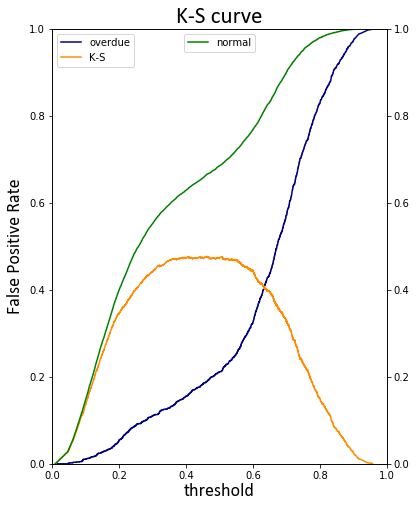

In [94]:
ks_curve(y_tr_test,y_predict_proba1[:,1])

# 交叉验证  
&ensp;&ensp;以上过程是建立在一次性二八分，用八份去通过myGridSearchCV得到最佳超参数，然后在此超参数下对这八份进行学习得到最佳模型，然后用最佳模型对那二份进行预测并计算AUC和KS。  
&ensp;&ensp;一次性二八分会否太单一？我认为可以在此超参数下使用交叉验证，多算几个验证分数。也就是把整个训练集X_tr, y_tr进行五折划分，在此超参数下学得5个模型，这5个模型对各自的验证集进行预测，得到5个auc和ks评分。可以看看这5个评分，算一下均分。

In [95]:
# 本来准备使用 sklearn cross_val_score 进行交叉验证，但是运行太慢。代码如下：
# modelXGB2 = XGBClassifier(**XGB_param8)  # XGB_param8是最佳超参数+固定参数
# scores2 = cross_val_score(modelXGB2, X_tr, y_tr,cv = 5, scoring="roc_auc")  # 或试试cv=10
# print("5Fold scores :", scores2)
# print("5Fold mean score :", np.mean(scores2))


# 准备手动交叉验证。

In [96]:
# 对训练集 X_tr，y_tr进行一次性五折划分。
# Xta 存储了 5个二维array，分别是5份训练集。     # a 表示 all，完整训练集
# Xva 存储了 5个二维array，分别是对应的5份验证集。
# Yta 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yva 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=9)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xta = []
Yta = []
Xva = []
Yva = []
for train_index, validation_index in skf.split(X_tr.values,y_tr.values):  
    Xta.append(X_tr.values[train_index])
    Yta.append(y_tr.values[train_index])
    Xva.append(X_tr.values[validation_index])
    Yva.append(y_tr.values[validation_index])

In [97]:
# 参数使用 最佳超参数 XGB_param8 。

In [98]:
# 对训练集的五折划分，每一折都训练一个XGB模型，每个模型分别对自己的训练集和验证集进行预测并计算 auc。
# Models2 保存了 5 个模型。 Scores2 保存了 5 个模型分别对各自的验证集进行预测算得的 auc。
# 并求 5 个验证集 auc 值 的均值。


timestart = time.time()
Scores2=[]
Models2=[XGBClassifier(**XGB_param8) for i in range(len(Xta))]  # 创建 5 个模型
for i in range(len(Xta)):
    Models2[i].fit(Xta[i],Yta[i], eval_set = [(Xta[i],Yta[i]),( Xva[i],Yva[i])],
                   eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
    Scores2.append(Models2[i].best_score)
    print("-------------------------------")
print("Time: {:.2f} seconds".format(time.time() - timestart))
print("Scores1 : ", Scores2)
print("The mean auc is :", np.mean(Scores2))

# 代码技巧：我之前是这样做的：Models2=[]，然后在for循环里 modelXGB2.fit数据集，再 Models2.append(modelXGB2)
# 但发现这样做，得到的 Models2 里的五个模型全相同，都是最终的模型。所以我认为，应该在每一轮创建新的模型，
# 而不是同一个模型 modelXGB2 反复 fit 不同的数据。所以上述代码是在每一轮创建新模型。

[0]	validation_0-logloss:0.67116	validation_0-auc:0.755038	validation_1-logloss:0.671703	validation_1-auc:0.745682
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.653438	validation_0-auc:0.765326	validation_1-logloss:0.654655	validation_1-auc:0.750754
[2]	validation_0-logloss:0.63887	validation_0-auc:0.766305	validation_1-logloss:0.640524	validation_1-auc:0.751889
[3]	validation_0-logloss:0.626943	validation_0-auc:0.770044	validation_1-logloss:0.628854	validation_1-auc:0.755191
[4]	validation_0-logloss:0.617002	validation_0-auc:0.776999	validation_1-logloss:0.619303	validation_1-auc:0.764381
[5]	validation_0-logloss:0.608718	validation_0-auc:0.777727	validation_1-logloss:0.611454	validation_1-auc:0.765355
[6]	validation_0-logloss:0.601921	validation_0-auc:0.777692	validation_1-logloss:0.604949	validation_1-auc:0.764974
[7]	validation_0-logloss:0.596101

[69]	validation_0-logloss:0.527165	validation_0-auc:0.826635	validation_1-logloss:0.536949	validation_1-auc:0.803617
[70]	validation_0-logloss:0.526654	validation_0-auc:0.827077	validation_1-logloss:0.536703	validation_1-auc:0.803726
[71]	validation_0-logloss:0.526087	validation_0-auc:0.827494	validation_1-logloss:0.536199	validation_1-auc:0.803959
[72]	validation_0-logloss:0.525711	validation_0-auc:0.827647	validation_1-logloss:0.535888	validation_1-auc:0.803955
[73]	validation_0-logloss:0.525188	validation_0-auc:0.827968	validation_1-logloss:0.535395	validation_1-auc:0.804246
[74]	validation_0-logloss:0.524799	validation_0-auc:0.828392	validation_1-logloss:0.535024	validation_1-auc:0.804481
[75]	validation_0-logloss:0.52456	validation_0-auc:0.828635	validation_1-logloss:0.534872	validation_1-auc:0.804386
[76]	validation_0-logloss:0.524138	validation_0-auc:0.828974	validation_1-logloss:0.534567	validation_1-auc:0.804599
[77]	validation_0-logloss:0.523605	validation_0-auc:0.829705	vali

[139]	validation_0-logloss:0.501382	validation_0-auc:0.848064	validation_1-logloss:0.518555	validation_1-auc:0.811018
[140]	validation_0-logloss:0.501015	validation_0-auc:0.848386	validation_1-logloss:0.51832	validation_1-auc:0.811081
[141]	validation_0-logloss:0.500671	validation_0-auc:0.848702	validation_1-logloss:0.517992	validation_1-auc:0.811292
[142]	validation_0-logloss:0.500425	validation_0-auc:0.848865	validation_1-logloss:0.517858	validation_1-auc:0.811288
[143]	validation_0-logloss:0.50012	validation_0-auc:0.849141	validation_1-logloss:0.517656	validation_1-auc:0.81118
[144]	validation_0-logloss:0.499894	validation_0-auc:0.849315	validation_1-logloss:0.517446	validation_1-auc:0.811275
[145]	validation_0-logloss:0.499721	validation_0-auc:0.849487	validation_1-logloss:0.517331	validation_1-auc:0.811253
[146]	validation_0-logloss:0.499505	validation_0-auc:0.849671	validation_1-logloss:0.517189	validation_1-auc:0.811299
[147]	validation_0-logloss:0.499094	validation_0-auc:0.8500

[43]	validation_0-logloss:0.542025	validation_0-auc:0.814426	validation_1-logloss:0.55167	validation_1-auc:0.792016
[44]	validation_0-logloss:0.541415	validation_0-auc:0.815081	validation_1-logloss:0.551113	validation_1-auc:0.792402
[45]	validation_0-logloss:0.540805	validation_0-auc:0.815421	validation_1-logloss:0.550494	validation_1-auc:0.792783
[46]	validation_0-logloss:0.540098	validation_0-auc:0.815887	validation_1-logloss:0.55002	validation_1-auc:0.792811
[47]	validation_0-logloss:0.539306	validation_0-auc:0.816334	validation_1-logloss:0.549367	validation_1-auc:0.79316
[48]	validation_0-logloss:0.538573	validation_0-auc:0.817124	validation_1-logloss:0.548767	validation_1-auc:0.793716
[49]	validation_0-logloss:0.537975	validation_0-auc:0.817753	validation_1-logloss:0.548329	validation_1-auc:0.793787
[50]	validation_0-logloss:0.536754	validation_0-auc:0.818903	validation_1-logloss:0.547136	validation_1-auc:0.795267
[51]	validation_0-logloss:0.536104	validation_0-auc:0.819448	valida

[4]	validation_0-logloss:0.617605	validation_0-auc:0.774272	validation_1-logloss:0.616817	validation_1-auc:0.761561
[5]	validation_0-logloss:0.60924	validation_0-auc:0.779108	validation_1-logloss:0.608362	validation_1-auc:0.766247
[6]	validation_0-logloss:0.6023	validation_0-auc:0.779936	validation_1-logloss:0.601234	validation_1-auc:0.767866
[7]	validation_0-logloss:0.596443	validation_0-auc:0.781305	validation_1-logloss:0.59521	validation_1-auc:0.7687
[8]	validation_0-logloss:0.59146	validation_0-auc:0.784382	validation_1-logloss:0.590319	validation_1-auc:0.770871
[9]	validation_0-logloss:0.587193	validation_0-auc:0.78531	validation_1-logloss:0.585891	validation_1-auc:0.772151
[10]	validation_0-logloss:0.583481	validation_0-auc:0.786545	validation_1-logloss:0.582471	validation_1-auc:0.77317
[11]	validation_0-logloss:0.580282	validation_0-auc:0.78747	validation_1-logloss:0.579285	validation_1-auc:0.773577
[12]	validation_0-logloss:0.577526	validation_0-auc:0.790186	validation_1-loglos

[75]	validation_0-logloss:0.521246	validation_0-auc:0.832118	validation_1-logloss:0.531563	validation_1-auc:0.796384
[76]	validation_0-logloss:0.5208	validation_0-auc:0.832485	validation_1-logloss:0.531338	validation_1-auc:0.796544
[77]	validation_0-logloss:0.520377	validation_0-auc:0.832735	validation_1-logloss:0.531051	validation_1-auc:0.796564
[78]	validation_0-logloss:0.519904	validation_0-auc:0.833063	validation_1-logloss:0.53081	validation_1-auc:0.796207
[79]	validation_0-logloss:0.519464	validation_0-auc:0.833198	validation_1-logloss:0.530515	validation_1-auc:0.796346
[80]	validation_0-logloss:0.519128	validation_0-auc:0.833482	validation_1-logloss:0.530478	validation_1-auc:0.796181
[81]	validation_0-logloss:0.518835	validation_0-auc:0.833705	validation_1-logloss:0.530364	validation_1-auc:0.796181
[82]	validation_0-logloss:0.518455	validation_0-auc:0.834011	validation_1-logloss:0.530079	validation_1-auc:0.796304
[83]	validation_0-logloss:0.518011	validation_0-auc:0.834298	valida

[13]	validation_0-logloss:0.578325	validation_0-auc:0.78859	validation_1-logloss:0.580344	validation_1-auc:0.792821
[14]	validation_0-logloss:0.576075	validation_0-auc:0.790515	validation_1-logloss:0.5783	validation_1-auc:0.794962
[15]	validation_0-logloss:0.574082	validation_0-auc:0.791348	validation_1-logloss:0.576349	validation_1-auc:0.795215
[16]	validation_0-logloss:0.572342	validation_0-auc:0.792135	validation_1-logloss:0.574817	validation_1-auc:0.795274
[17]	validation_0-logloss:0.570654	validation_0-auc:0.792298	validation_1-logloss:0.573175	validation_1-auc:0.795681
[18]	validation_0-logloss:0.569147	validation_0-auc:0.793522	validation_1-logloss:0.571774	validation_1-auc:0.796516
[19]	validation_0-logloss:0.567743	validation_0-auc:0.79491	validation_1-logloss:0.570676	validation_1-auc:0.797471
[20]	validation_0-logloss:0.566516	validation_0-auc:0.794922	validation_1-logloss:0.569489	validation_1-auc:0.797762
[21]	validation_0-logloss:0.565394	validation_0-auc:0.795154	validat

[84]	validation_0-logloss:0.522695	validation_0-auc:0.830076	validation_1-logloss:0.53411	validation_1-auc:0.817137
[85]	validation_0-logloss:0.522315	validation_0-auc:0.830272	validation_1-logloss:0.533926	validation_1-auc:0.817083
[86]	validation_0-logloss:0.522019	validation_0-auc:0.830527	validation_1-logloss:0.53366	validation_1-auc:0.817252
[87]	validation_0-logloss:0.521619	validation_0-auc:0.830871	validation_1-logloss:0.533375	validation_1-auc:0.817187
[88]	validation_0-logloss:0.520881	validation_0-auc:0.831518	validation_1-logloss:0.532894	validation_1-auc:0.817338
[89]	validation_0-logloss:0.520511	validation_0-auc:0.831869	validation_1-logloss:0.532651	validation_1-auc:0.817466
[90]	validation_0-logloss:0.520154	validation_0-auc:0.832115	validation_1-logloss:0.532448	validation_1-auc:0.817406
[91]	validation_0-logloss:0.519805	validation_0-auc:0.832391	validation_1-logloss:0.53233	validation_1-auc:0.81742
[92]	validation_0-logloss:0.519541	validation_0-auc:0.832685	validat

[154]	validation_0-logloss:0.4992	validation_0-auc:0.849547	validation_1-logloss:0.518975	validation_1-auc:0.821558
[155]	validation_0-logloss:0.49894	validation_0-auc:0.849778	validation_1-logloss:0.518751	validation_1-auc:0.821718
[156]	validation_0-logloss:0.498669	validation_0-auc:0.850013	validation_1-logloss:0.518581	validation_1-auc:0.821801
[157]	validation_0-logloss:0.498461	validation_0-auc:0.850186	validation_1-logloss:0.518473	validation_1-auc:0.821792
[158]	validation_0-logloss:0.498185	validation_0-auc:0.850406	validation_1-logloss:0.518296	validation_1-auc:0.821761
[159]	validation_0-logloss:0.497999	validation_0-auc:0.850599	validation_1-logloss:0.518188	validation_1-auc:0.82175
[160]	validation_0-logloss:0.497651	validation_0-auc:0.850939	validation_1-logloss:0.517981	validation_1-auc:0.82183
[161]	validation_0-logloss:0.49721	validation_0-auc:0.851354	validation_1-logloss:0.517777	validation_1-auc:0.821977
[162]	validation_0-logloss:0.497027	validation_0-auc:0.851528	

[26]	validation_0-logloss:0.558302	validation_0-auc:0.801034	validation_1-logloss:0.558013	validation_1-auc:0.793555
[27]	validation_0-logloss:0.556812	validation_0-auc:0.802897	validation_1-logloss:0.556587	validation_1-auc:0.795841
[28]	validation_0-logloss:0.555486	validation_0-auc:0.803865	validation_1-logloss:0.555336	validation_1-auc:0.796564
[29]	validation_0-logloss:0.554706	validation_0-auc:0.804186	validation_1-logloss:0.554677	validation_1-auc:0.796668
[30]	validation_0-logloss:0.553948	validation_0-auc:0.804983	validation_1-logloss:0.554095	validation_1-auc:0.796816
[31]	validation_0-logloss:0.553105	validation_0-auc:0.805635	validation_1-logloss:0.553325	validation_1-auc:0.797072
[32]	validation_0-logloss:0.552038	validation_0-auc:0.806343	validation_1-logloss:0.552317	validation_1-auc:0.797901
[33]	validation_0-logloss:0.551141	validation_0-auc:0.806808	validation_1-logloss:0.551458	validation_1-auc:0.798343
[34]	validation_0-logloss:0.550396	validation_0-auc:0.807357	val

[97]	validation_0-logloss:0.516196	validation_0-auc:0.836325	validation_1-logloss:0.524841	validation_1-auc:0.809005
[98]	validation_0-logloss:0.515854	validation_0-auc:0.836669	validation_1-logloss:0.524628	validation_1-auc:0.809084
[99]	validation_0-logloss:0.515451	validation_0-auc:0.837087	validation_1-logloss:0.52445	validation_1-auc:0.808985
[100]	validation_0-logloss:0.515077	validation_0-auc:0.837344	validation_1-logloss:0.524207	validation_1-auc:0.809008
[101]	validation_0-logloss:0.514787	validation_0-auc:0.837549	validation_1-logloss:0.524076	validation_1-auc:0.808995
[102]	validation_0-logloss:0.514419	validation_0-auc:0.837817	validation_1-logloss:0.523778	validation_1-auc:0.809199
[103]	validation_0-logloss:0.514209	validation_0-auc:0.838004	validation_1-logloss:0.523773	validation_1-auc:0.809048
[104]	validation_0-logloss:0.513931	validation_0-auc:0.838256	validation_1-logloss:0.523539	validation_1-auc:0.809258
[105]	validation_0-logloss:0.513667	validation_0-auc:0.83842

In [99]:
Models2

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=6.7441006816990035, seed=1,
        silent=True, subsample=1.0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=6.7441006816990035, seed=1,
        silent=True, subsample=1.0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma

In [100]:
# 将五折训练出的 五个模型 的具体情况 做成表。
# model_round 是第几个模型，一共 5 个模型，按计算顺序排列。best_iteration 给出了训练此模型时的最佳轮数
# （因为设置了 early stopping）。
# train_auc 是此模型对其训练集进行预测计算出的 auc 值，validation_auc 是此模型对其验证集进行预测计算出的 auc 值。

roundXGB2=[]  
train_auc2=[]  
validation_auc2=[]  
best_iteration2=[]

for i in range(len(Scores2)):
    
    # round 表是 五折中的第几个模型。一共 5 个模型。
    roundXGB2.append(i+1)
    
    # 找出第 i个模型的最佳轮模型在自己训练集上预测时计算得到的auc值。
    train_auc2.append(Models2[i].evals_result()["validation_0"]["auc"][ Models2[i].best_iteration])
    
    # 找出第i个模型的最佳轮模型在自己验证集上预测时计算得到的auc值。
    validation_auc2.append(Models2[i].evals_result()["validation_1"]["auc"][ Models2[i].best_iteration])
    
    # i个模型的最佳轮是第几轮
    best_iteration2.append(Models2[i].best_iteration)

d = {"model_round":roundXGB2, "train_auc": train_auc2 , "validation_auc": validation_auc2 , "best_iteration": best_iteration2 }
auc_result2 = pd.DataFrame(d,index=[1,2,3,4,5])


In [101]:
# 验证集 auc 在 0.809 左右。

auc_result2 

,best_iteration,model_round,train_auc,validation_auc
1,153,1,0.851469,0.811503
2,96,2,0.836735,0.803040
3,119,3,0.845618,0.798981
4,185,4,0.856251,0.822927
5,113,5,0.840871,0.810098


In [102]:
np.mean(auc_result2["validation_auc"])

0.8093098

# 训练最终XGB模型并预测未知样本集

In [103]:
# 训练最终XGB模型并预测未知样本集

modelXGB3 = XGBClassifier(**XGB_param8)  # XGB_param8是最佳超参数+固定参数
modelXGB3.fit(X_tr, y_tr)
proba_prediction3 = modelXGB3.predict_proba(X_te)

In [104]:
# 将预测结果整合成表

XGBpre = pd.DataFrame(proba_prediction3[:,1],index=X_te.index,columns=["positive_proba"]).reset_index()
XGBpre.columns = ["userid","probability"]  # 按官网提交示例修改列名

In [105]:
XGBpre

,userid,probability
0,55597,0.518512
1,55598,0.009946
2,55599,0.076432
3,55600,0.636005
4,55601,0.628687
5,55602,0.635022
6,55603,0.632378
7,55604,0.146656
8,55605,0.588855
9,55606,0.203247


In [106]:
# 保存预测结果

XGBpre.to_csv(r'F:\RiskPre2\result\Data Clean 2\XGBpre.csv',index=False)

In [107]:
# 保存模型

joblib.dump(modelXGB3, r'F:\RiskPre2\result\Data Clean 2\modelXGB3.pkl')

['F:\\RiskPre2\\result\\Data Clean 2\\modelXGB3.pkl']

# 提交结果

In [1]:
# 提交 XGBpre 结果：计算的 ks 值是： 0.40***7 。历史最高。